In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

In [36]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(16, 60, kernel_size=(4, 4))
        
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(60)
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        #x = self.bn3(x)
        return x
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(60, 16, kernel_size=(4, 4))
        self.deconv2 = nn.ConvTranspose2d(16, 16, kernel_size=(5, 5))
        self.deconv3 = nn.ConvTranspose2d(16, 6, kernel_size=(5, 5))
        self.deconv4 = nn.ConvTranspose2d(6, 6, kernel_size=(13, 13))
        self.deconv5 = nn.ConvTranspose2d(6, 1, kernel_size=(5, 5))
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(6)
    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = self.bn1(x)
        x = F.relu(self.deconv2(x))
        x = self.bn1(x)
        x = F.relu(self.deconv3(x))
        x = self.bn2(x)
        x = F.relu(self.deconv4(x))
        x = self.bn2(x)
        x = F.relu(self.deconv5(x))
        return x

In [37]:
def assess(model, data, labels):
    total, correct = 0.0, 0.0
    for x, y, in zip(data, labels):
        if torch.argmax(model(x)) == y:
            correct += 1
        total += 1
    return correct / total

In [38]:
data_train = np.fromfile("MNIST/images_train", dtype=np.ubyte).reshape(-1, 28, 28)
labels_train = np.fromfile("MNIST/labels_train", dtype=np.ubyte)
data_test = np.fromfile("MNIST/images_test", dtype=np.ubyte).reshape(-1, 28, 28)
labels_test = np.fromfile("MNIST/labels_test", dtype=np.ubyte)

indices = np.random.choice(np.arange(len(labels_train)), len(labels_train), replace=False)
data_train = data_train[indices]
labels_train = labels_train[indices]

data_train = torch.tensor(data_train, dtype=torch.float)
data_test = torch.tensor(data_test, dtype=torch.float)
labels_train = torch.tensor(labels_train, dtype=torch.long).unsqueeze(1)
labels_test = torch.tensor(labels_test, dtype=torch.long).unsqueeze(1)

In [56]:
encoder = Encoder()
decoder = Decoder()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

tensor(10803.8984, grad_fn=<MseLossBackward>)


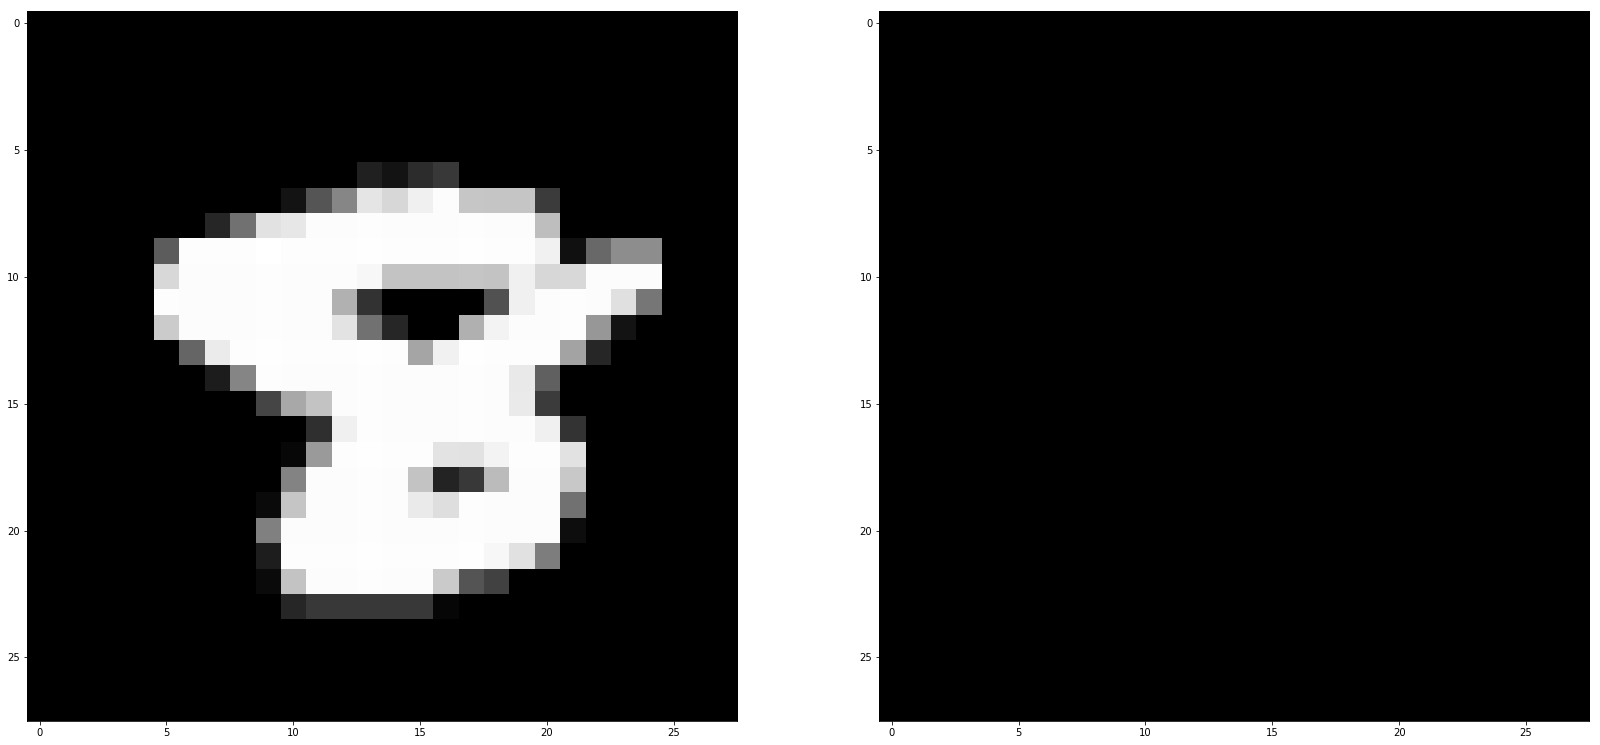

tensor(10229.7910, grad_fn=<MseLossBackward>)


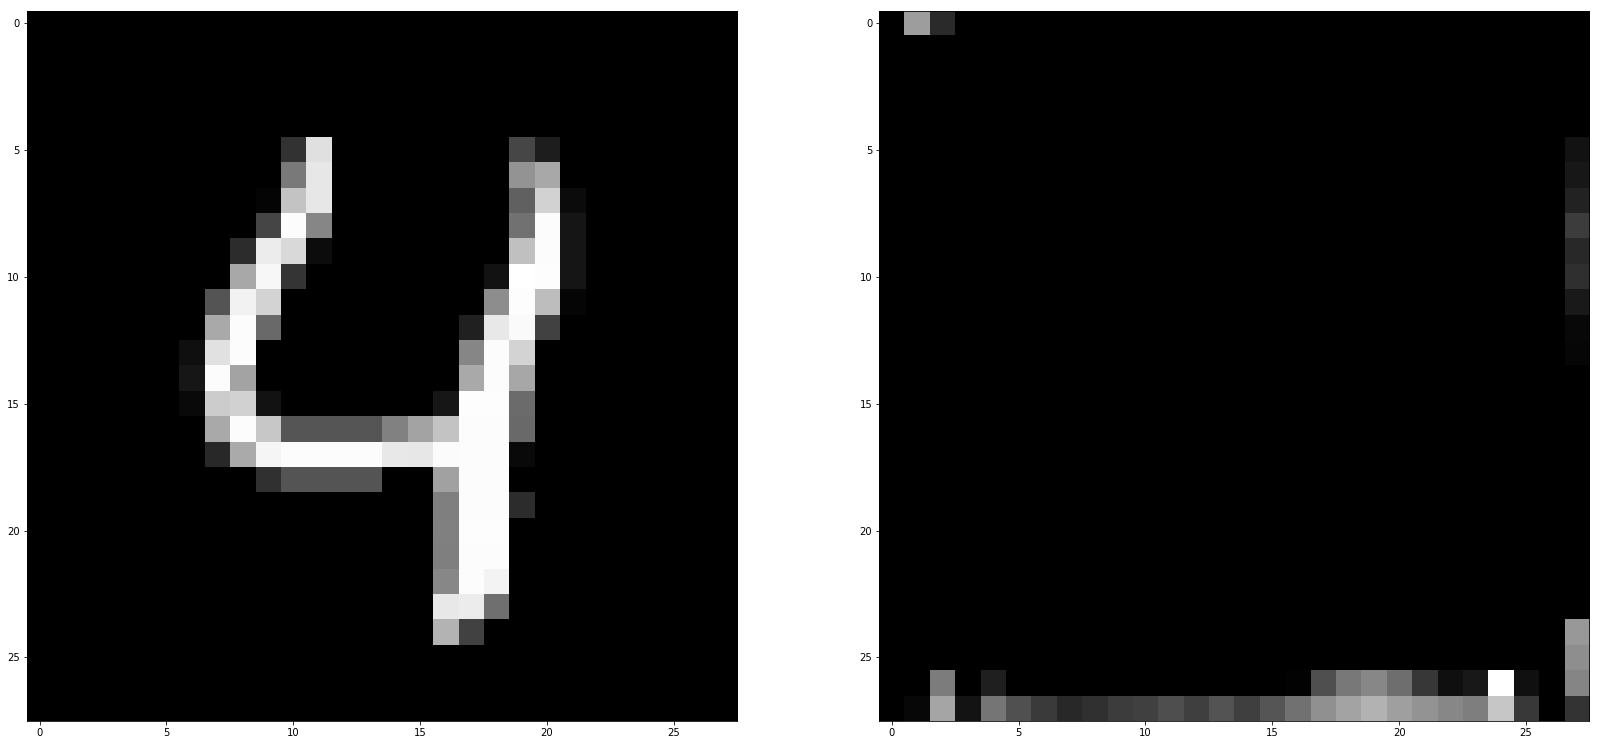

tensor(8756.4326, grad_fn=<MseLossBackward>)


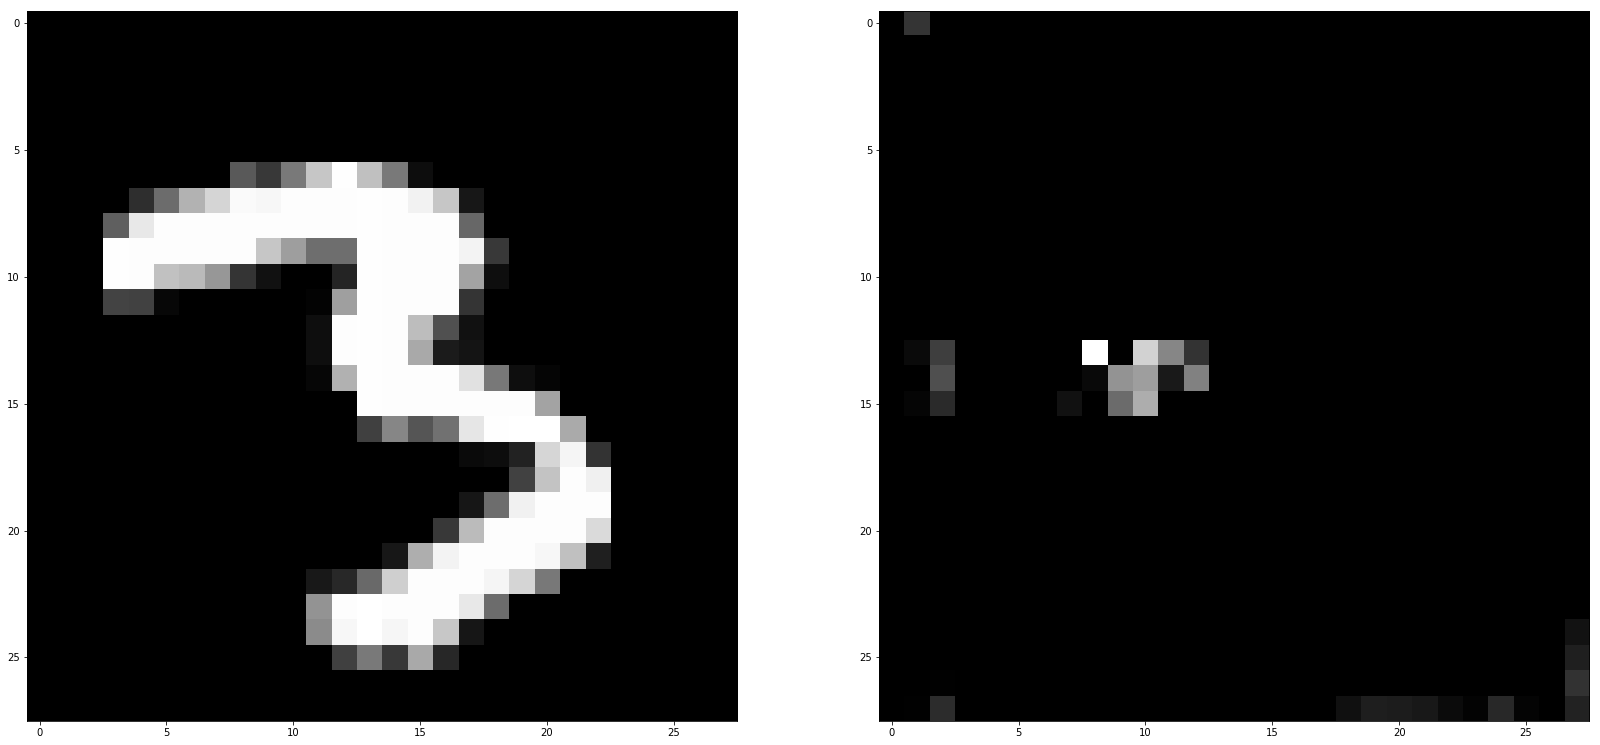

tensor(8633.4961, grad_fn=<MseLossBackward>)


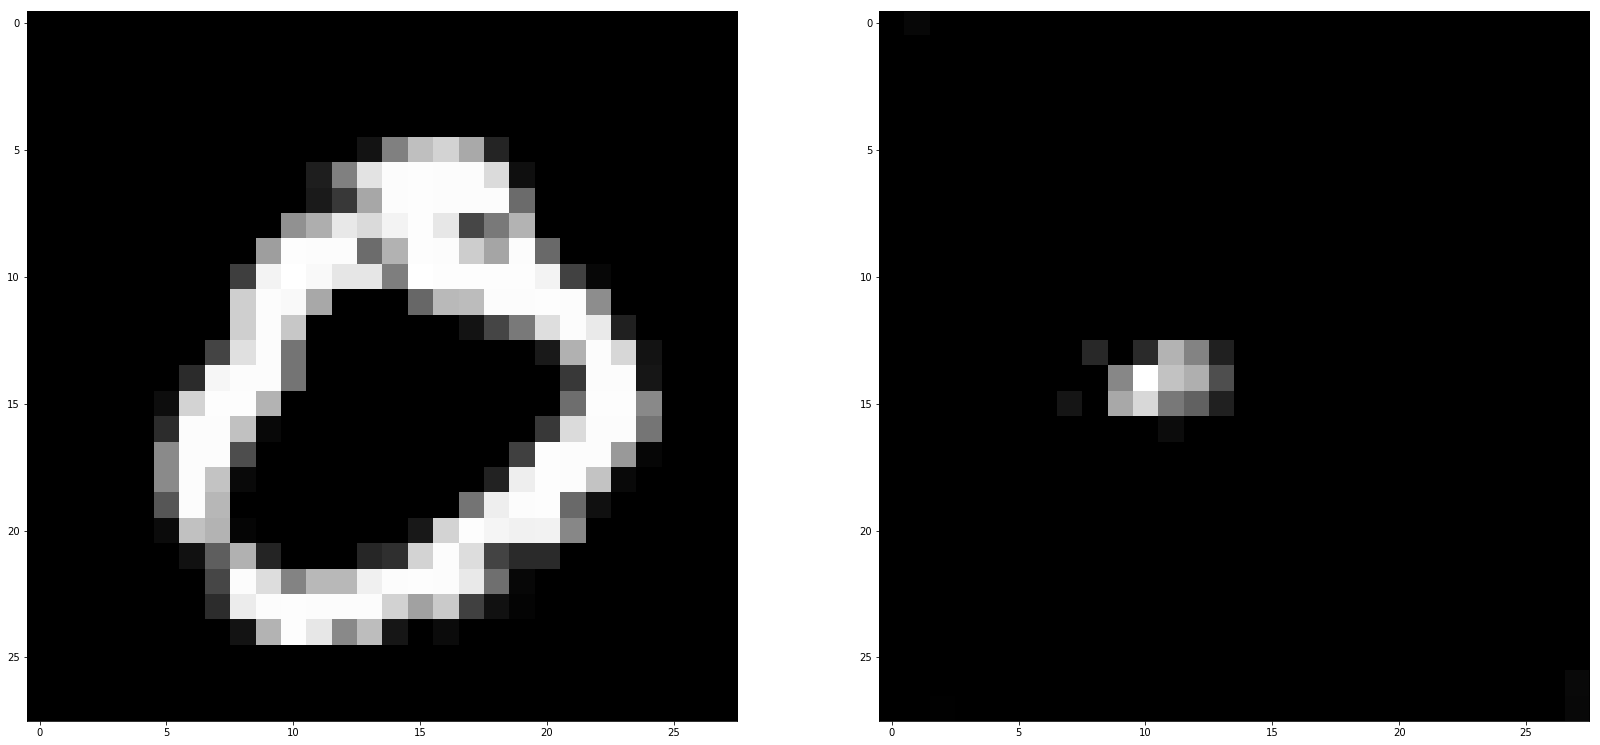

tensor(8535.1475, grad_fn=<MseLossBackward>)


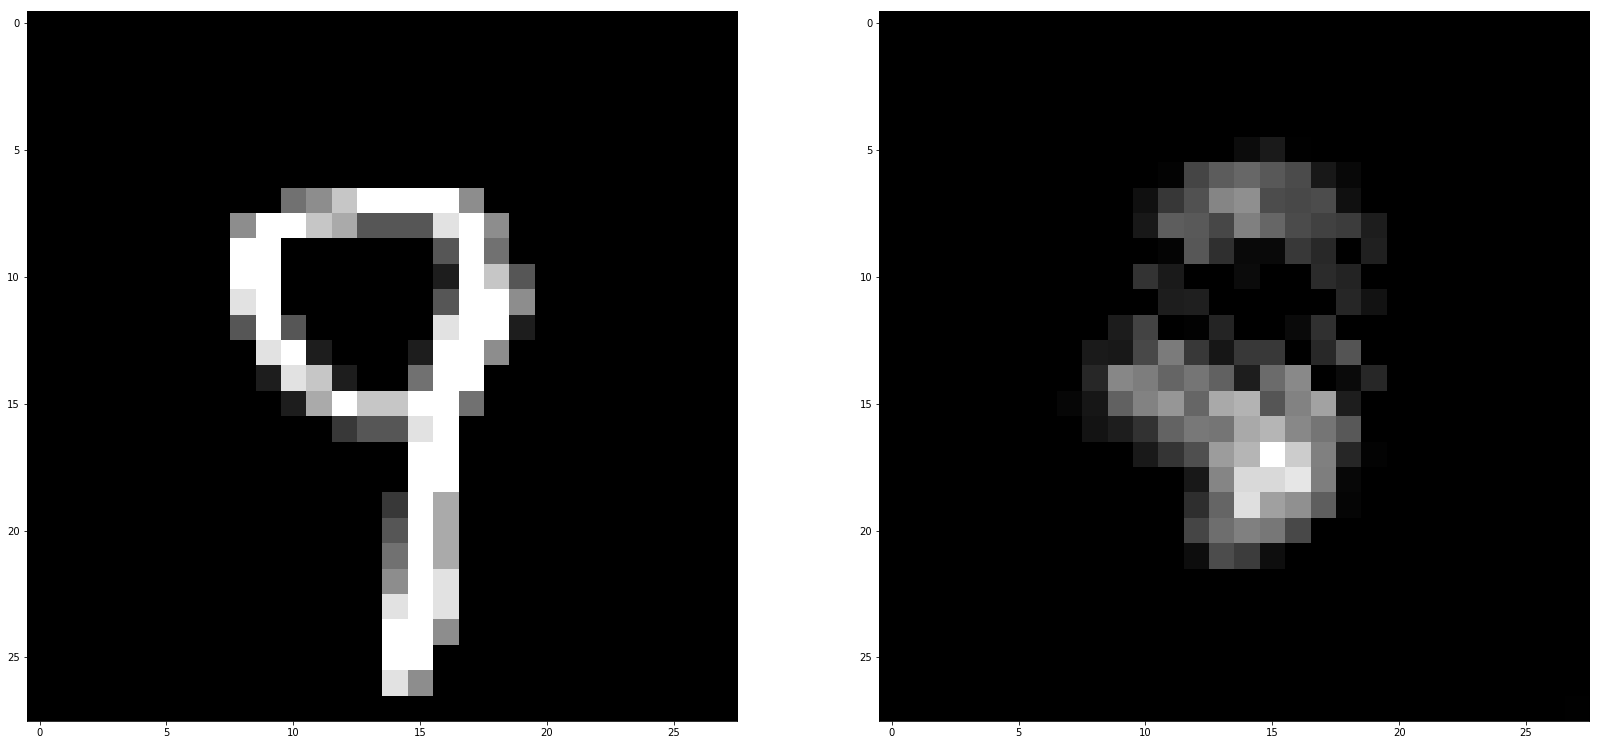

tensor(6743.0239, grad_fn=<MseLossBackward>)


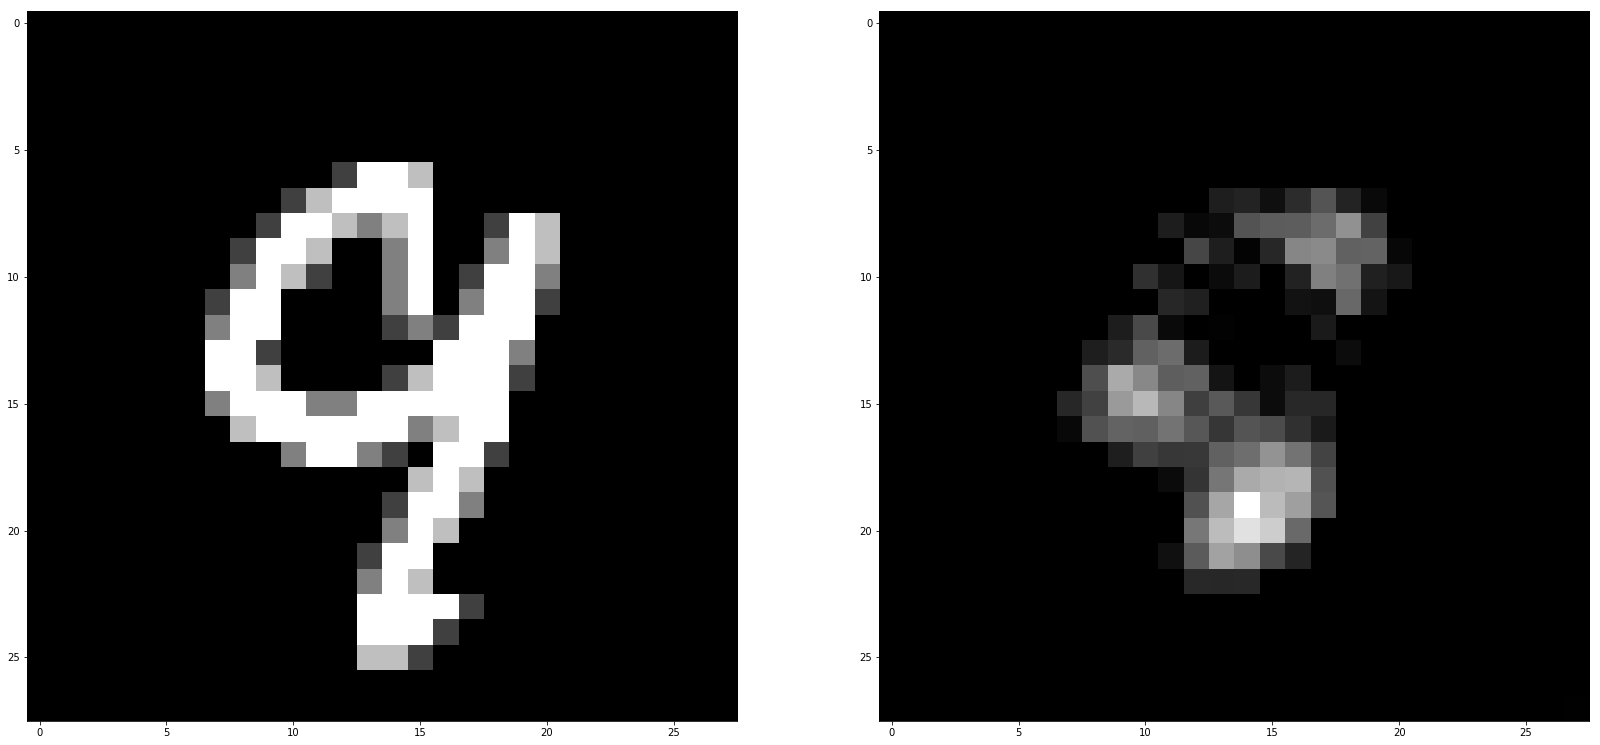

tensor(7665.6597, grad_fn=<MseLossBackward>)


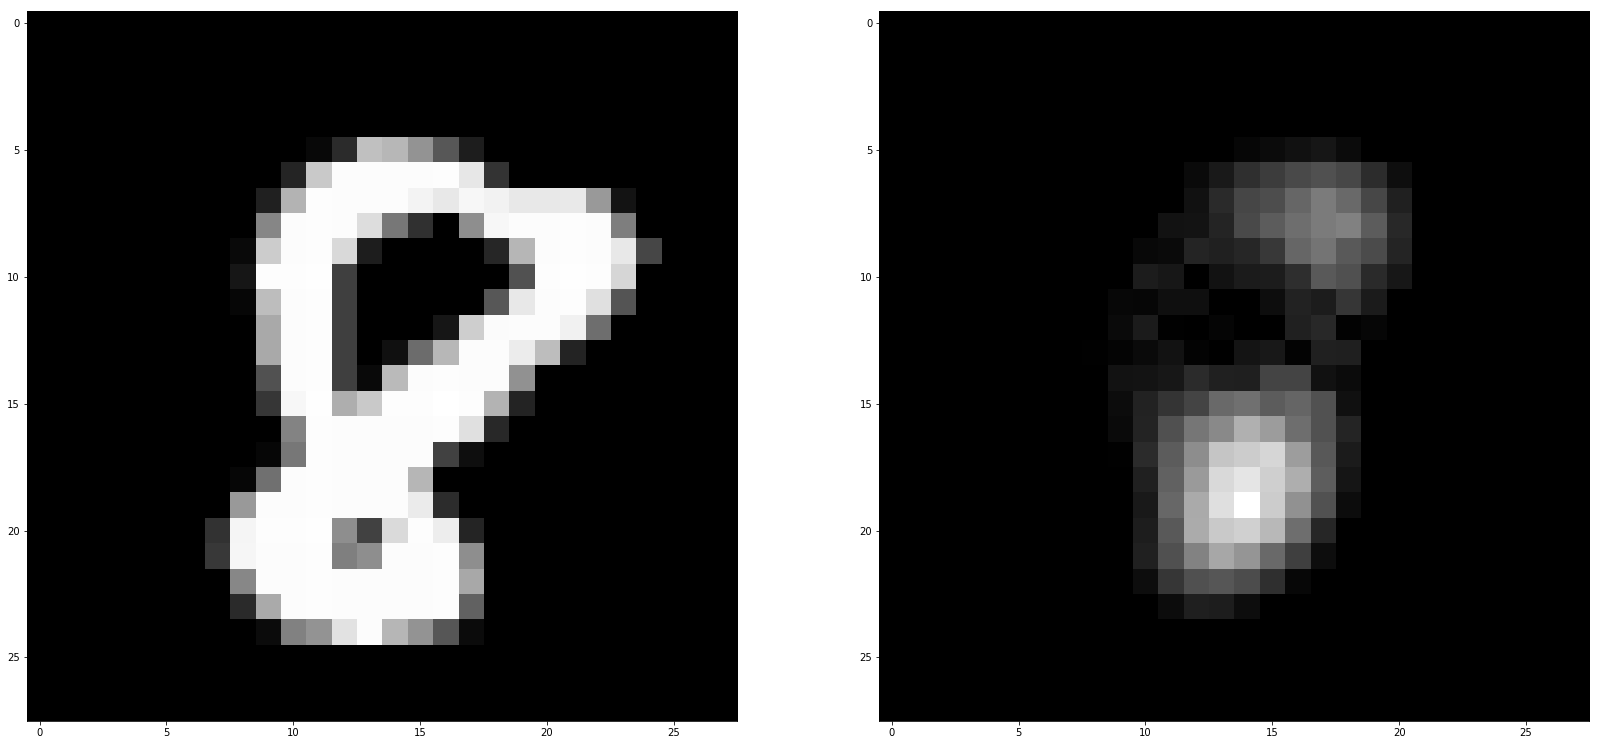

tensor(8166.1255, grad_fn=<MseLossBackward>)


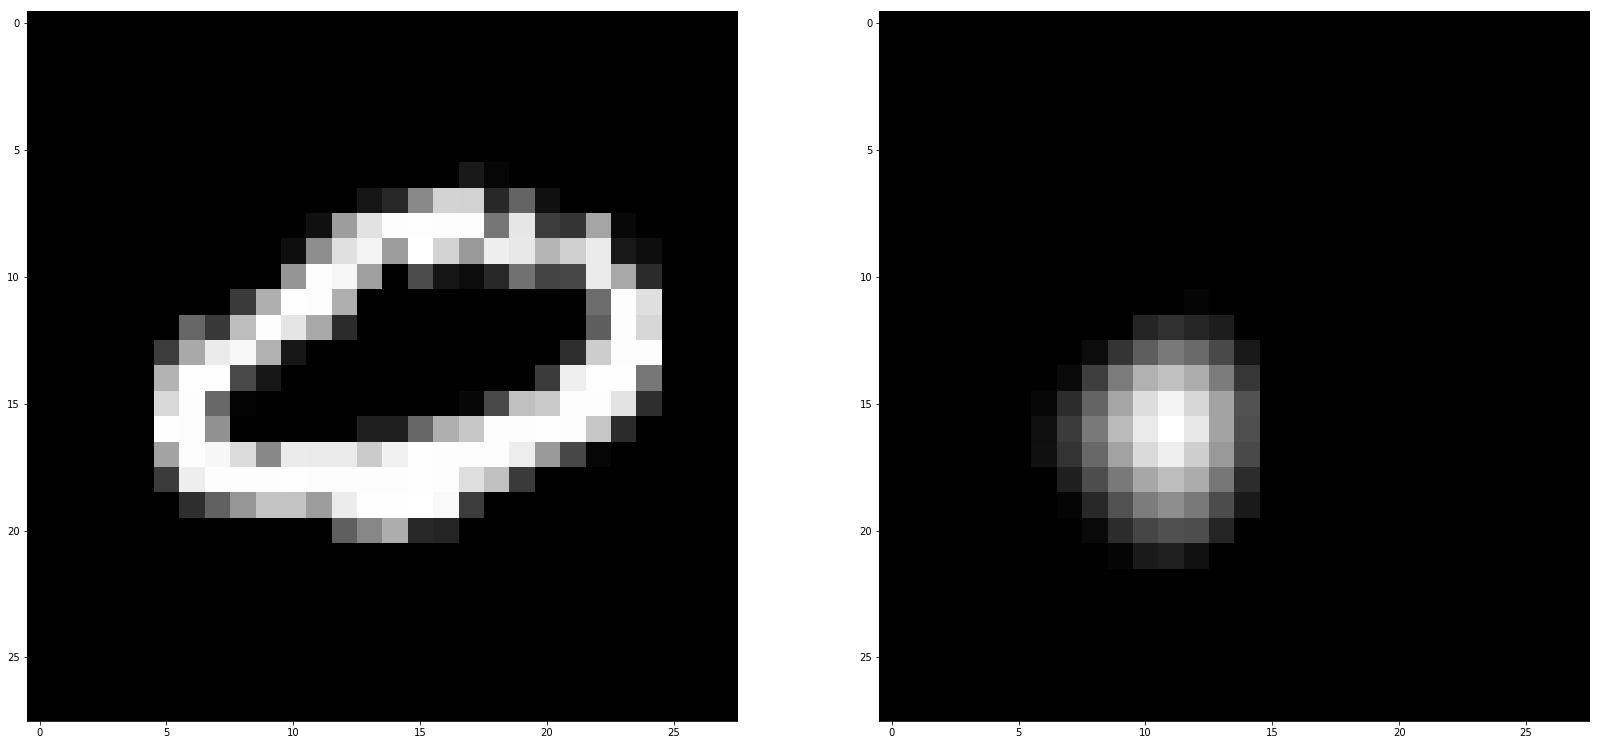

tensor(2224.3794, grad_fn=<MseLossBackward>)


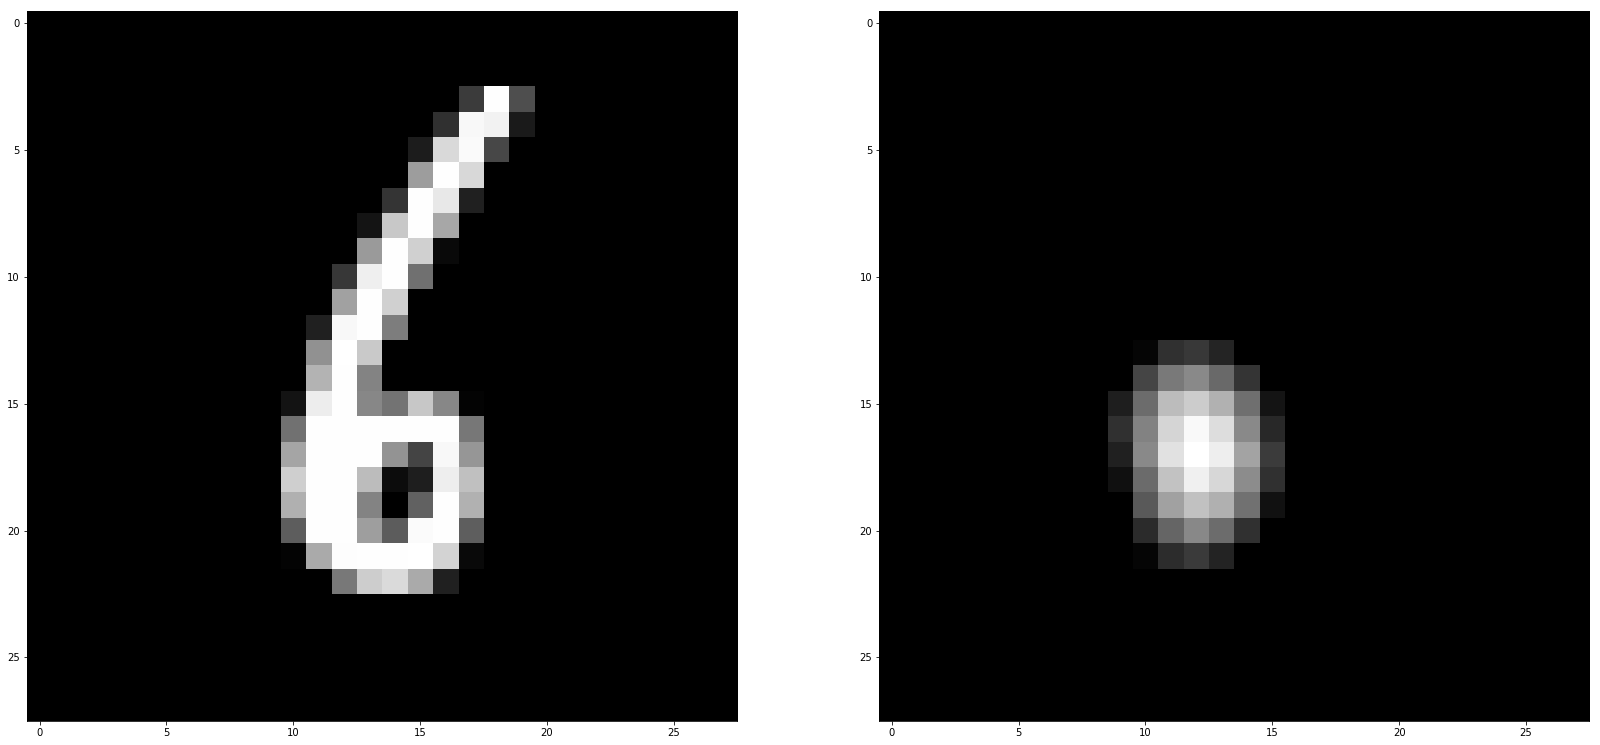

tensor(6333.3750, grad_fn=<MseLossBackward>)


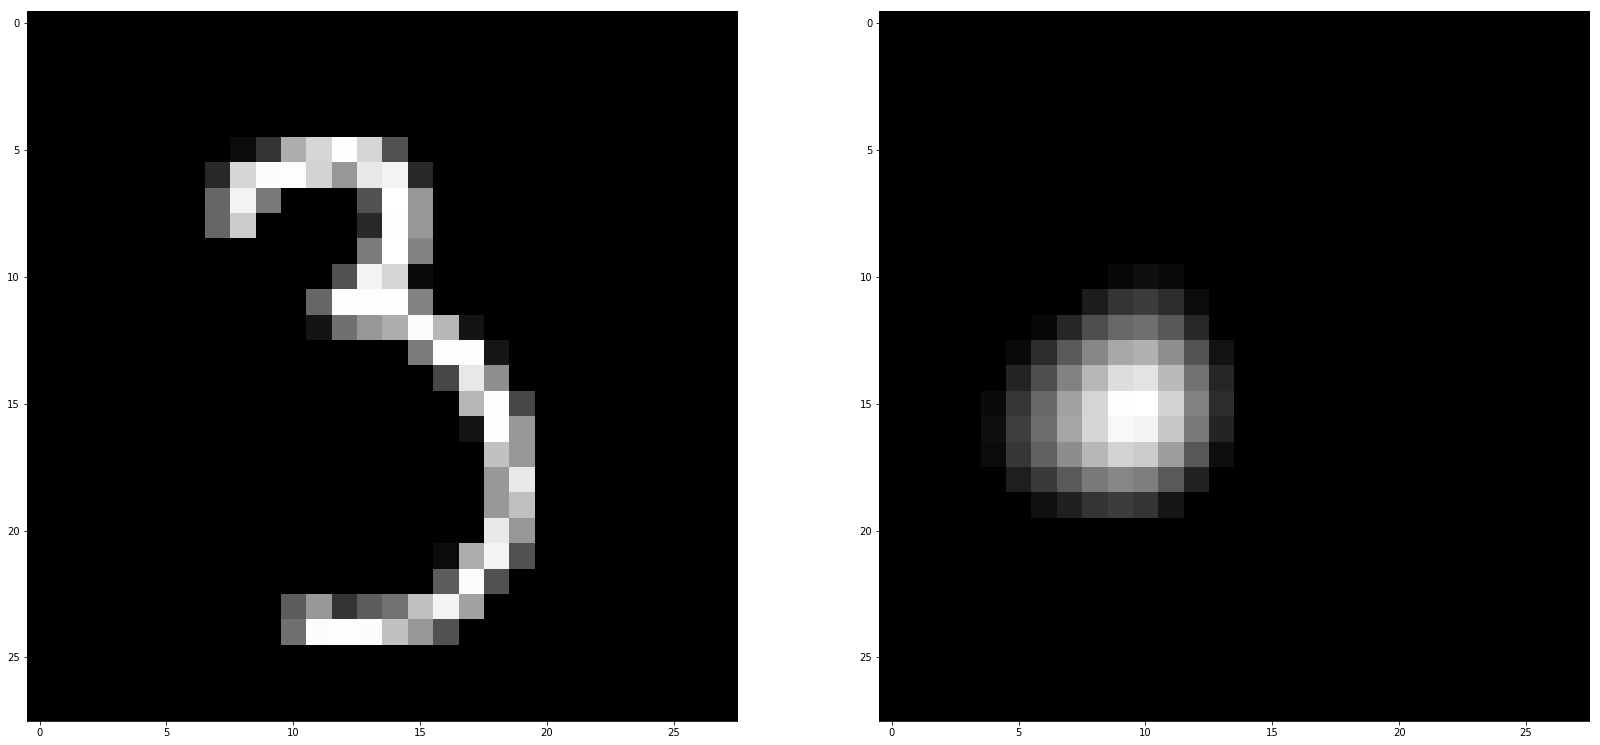

tensor(1875.9971, grad_fn=<MseLossBackward>)


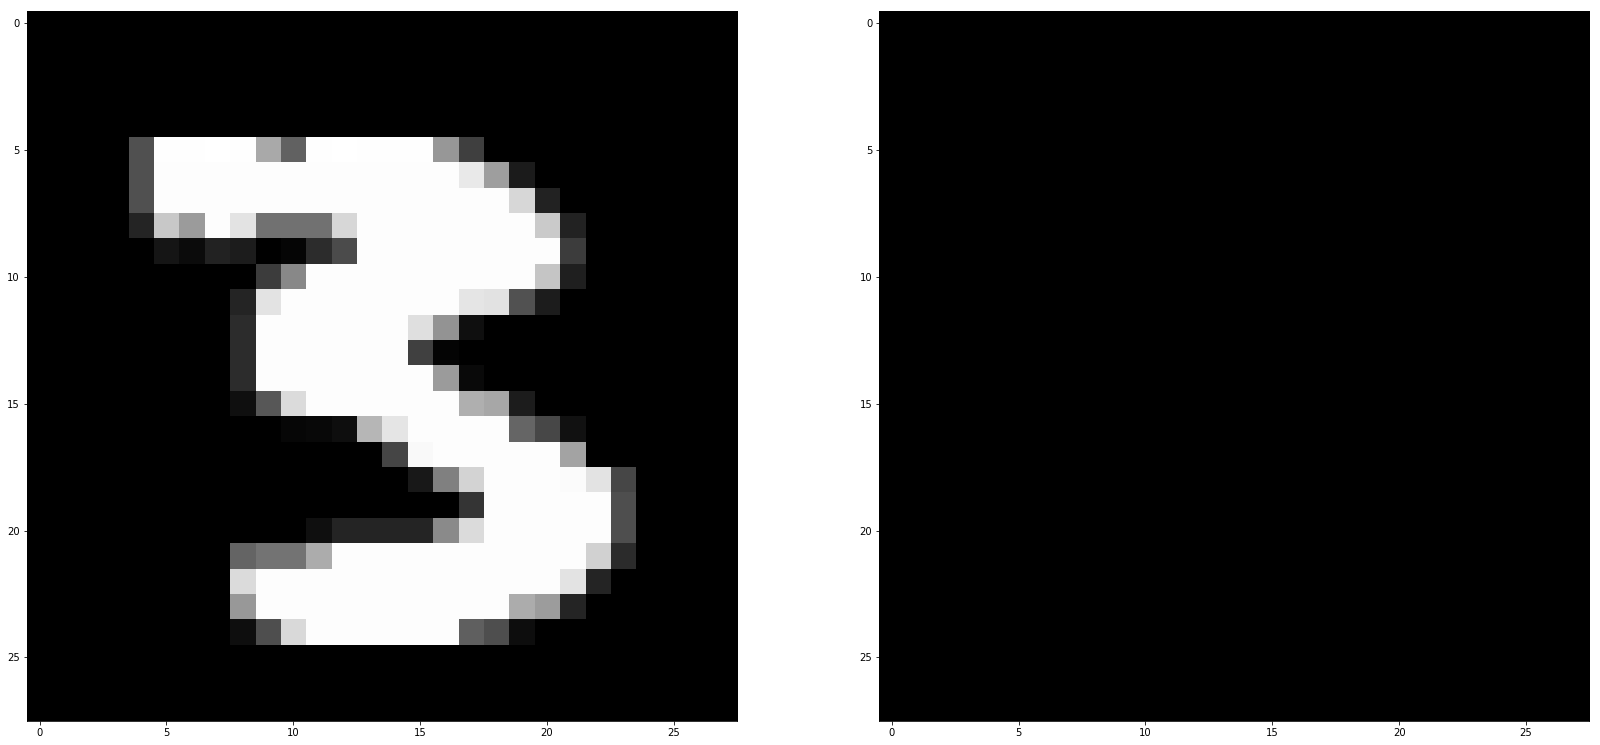

tensor(7600.8452, grad_fn=<MseLossBackward>)


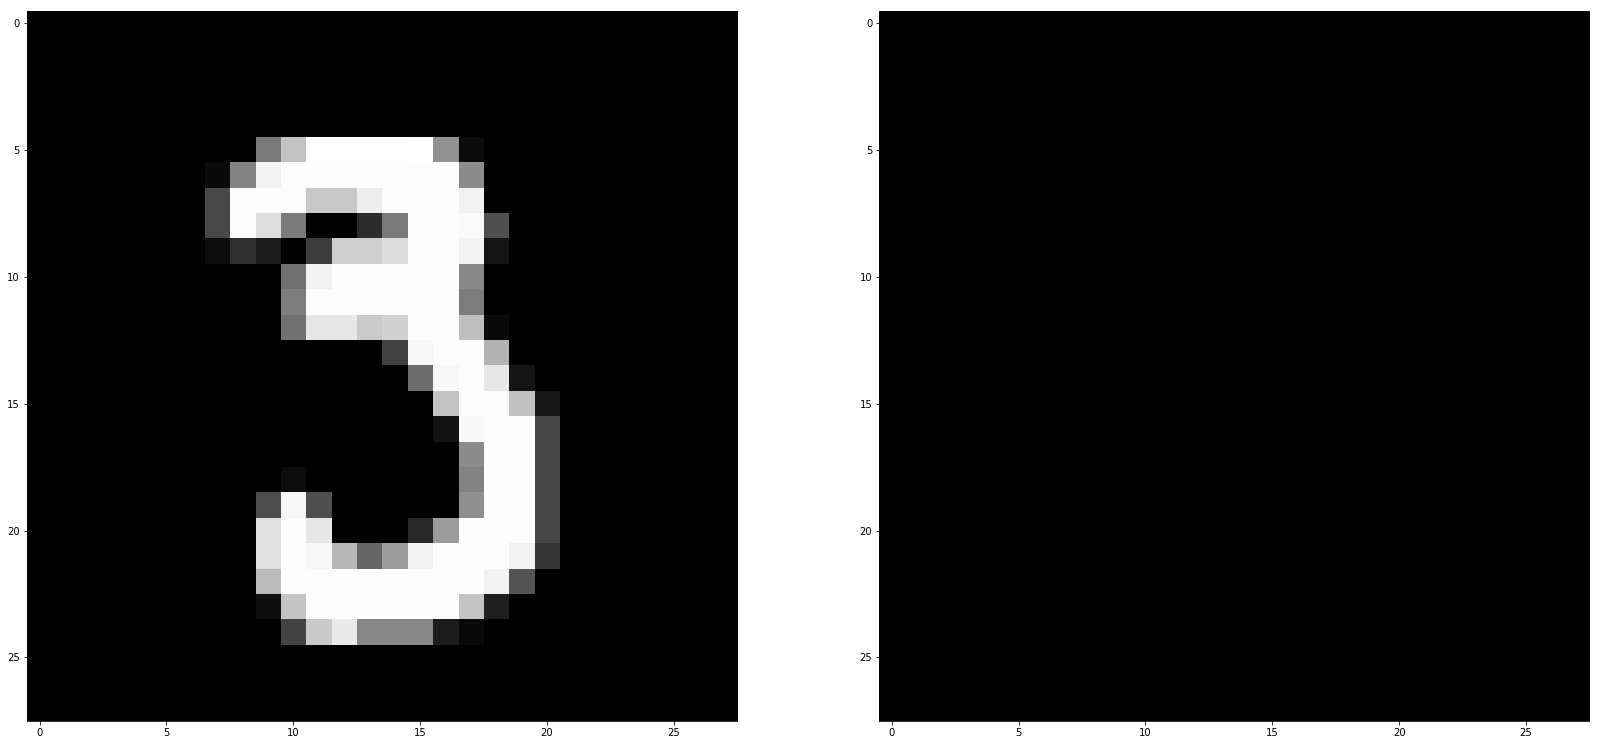

tensor(3615.1421, grad_fn=<MseLossBackward>)


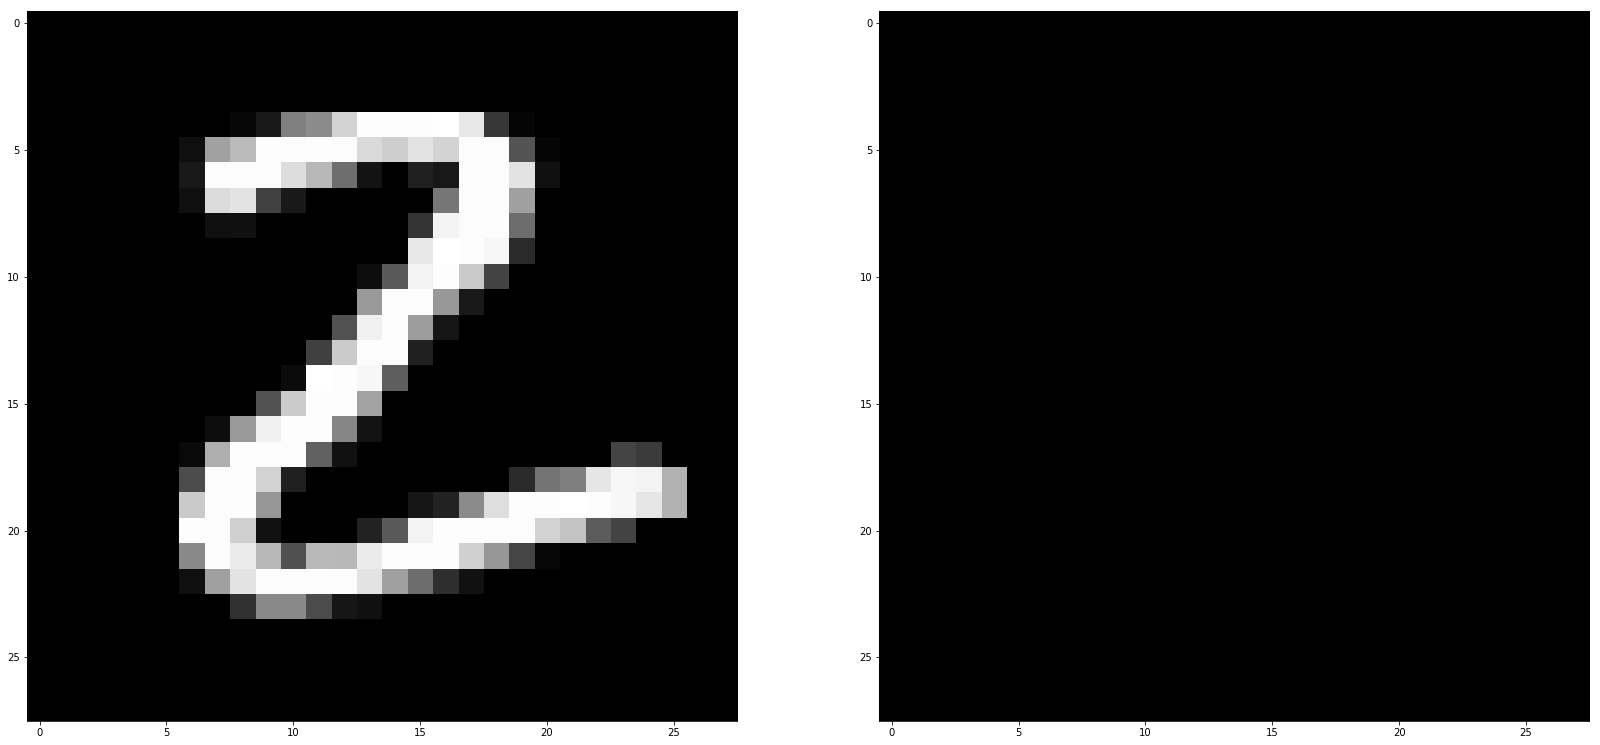

tensor(6166.2402, grad_fn=<MseLossBackward>)


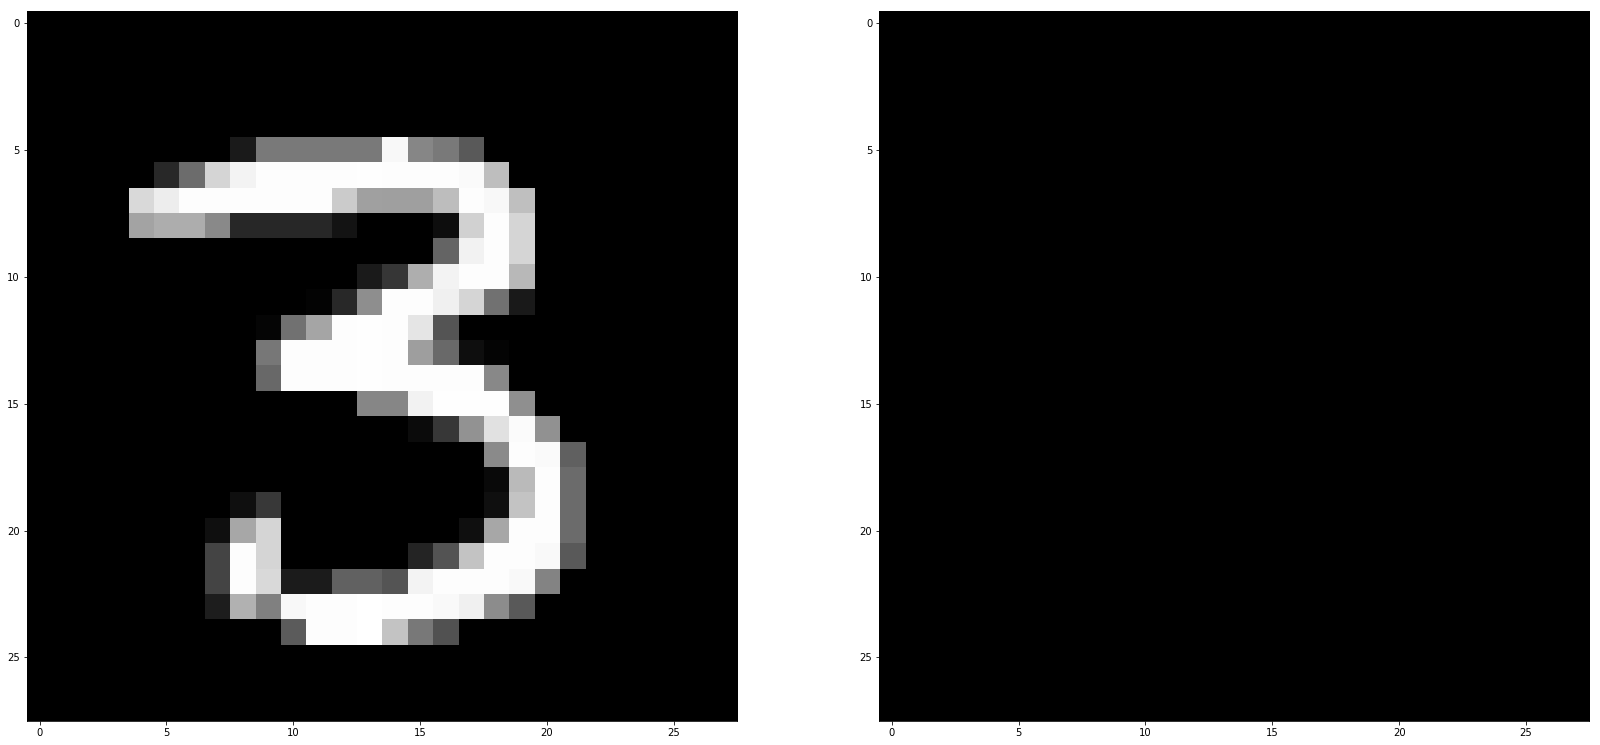

tensor(3898.9507, grad_fn=<MseLossBackward>)


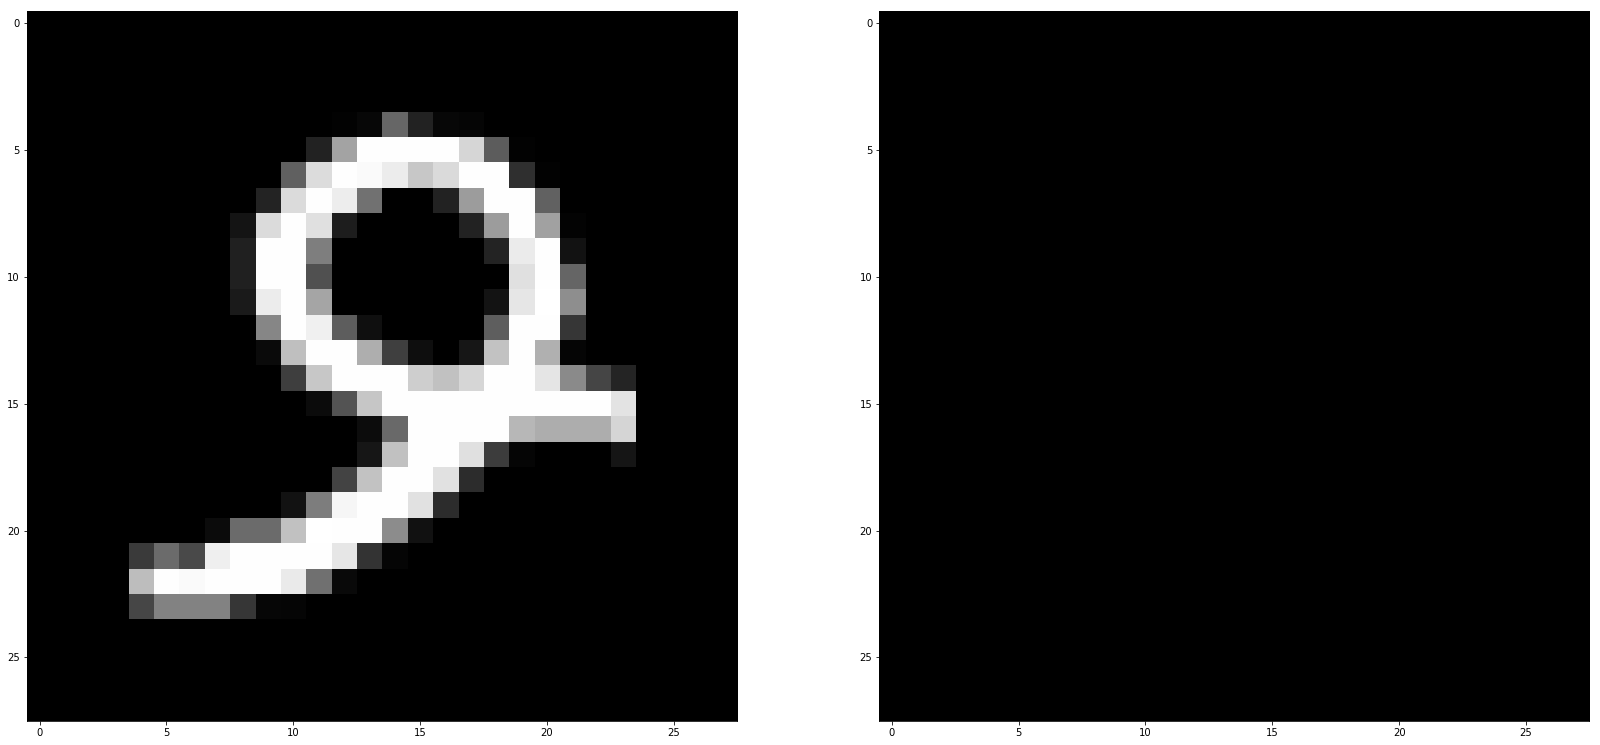

tensor(3459.9443, grad_fn=<MseLossBackward>)


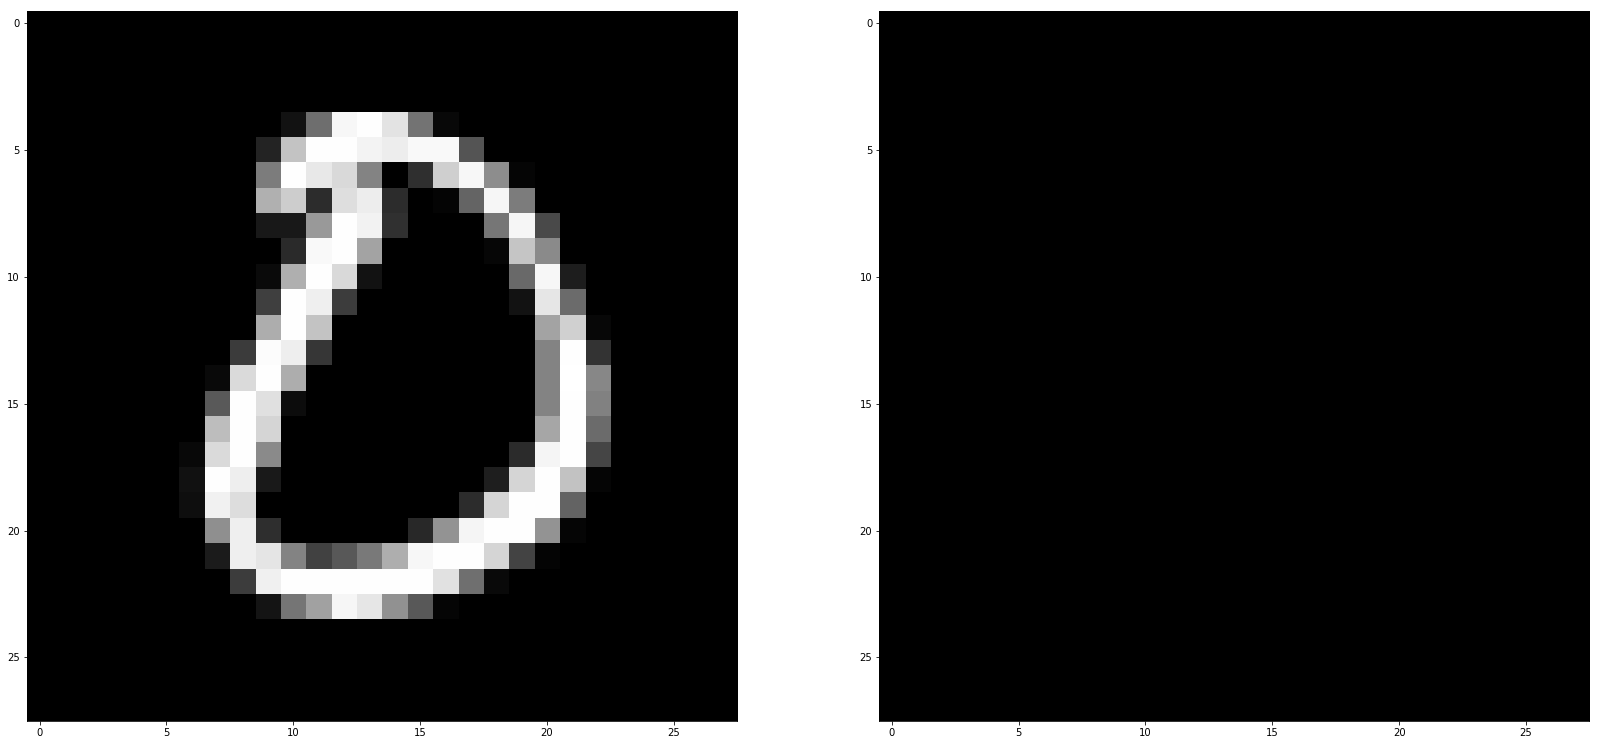

tensor(4034.8103, grad_fn=<MseLossBackward>)


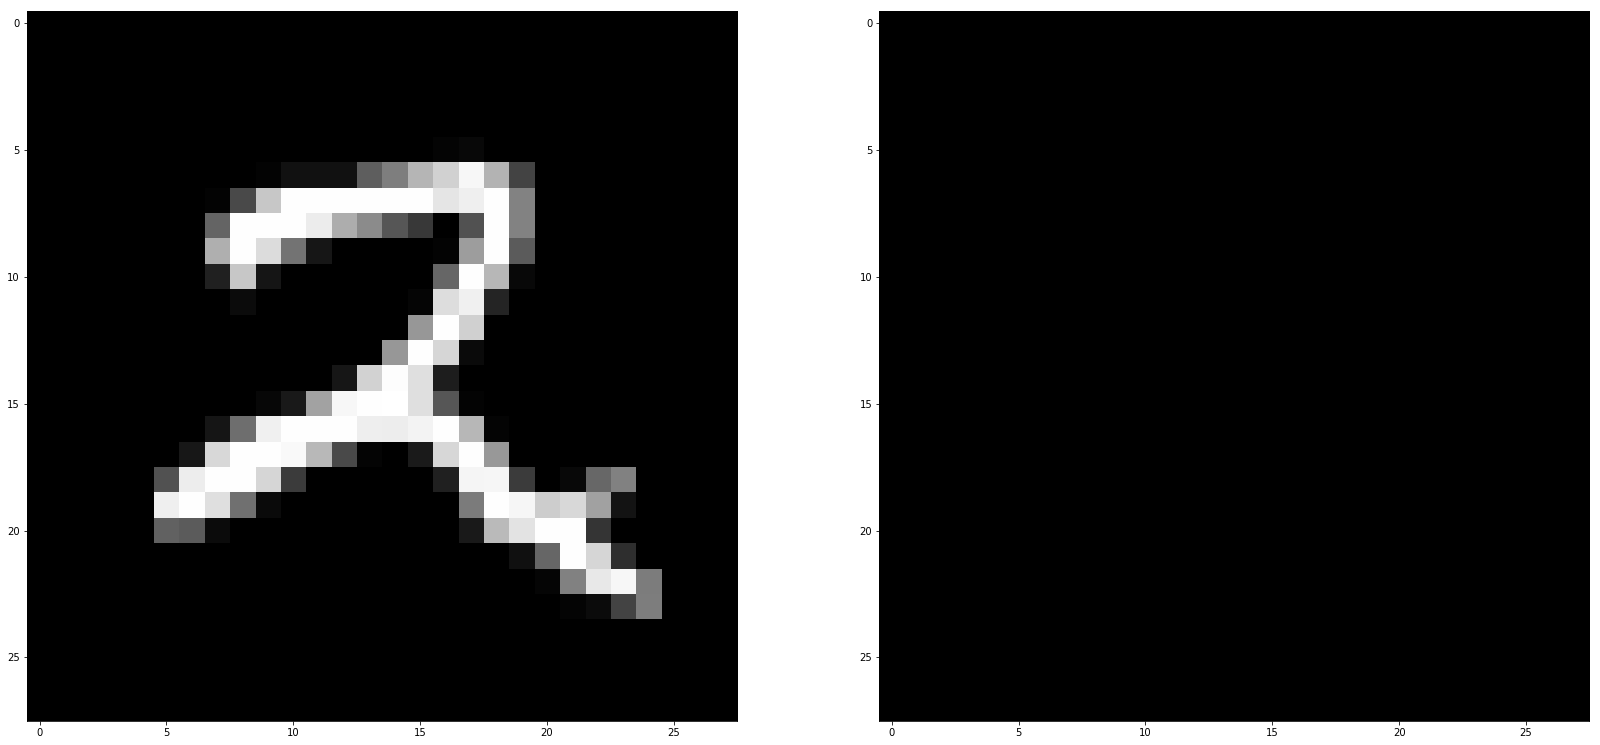

tensor(5506.4253, grad_fn=<MseLossBackward>)


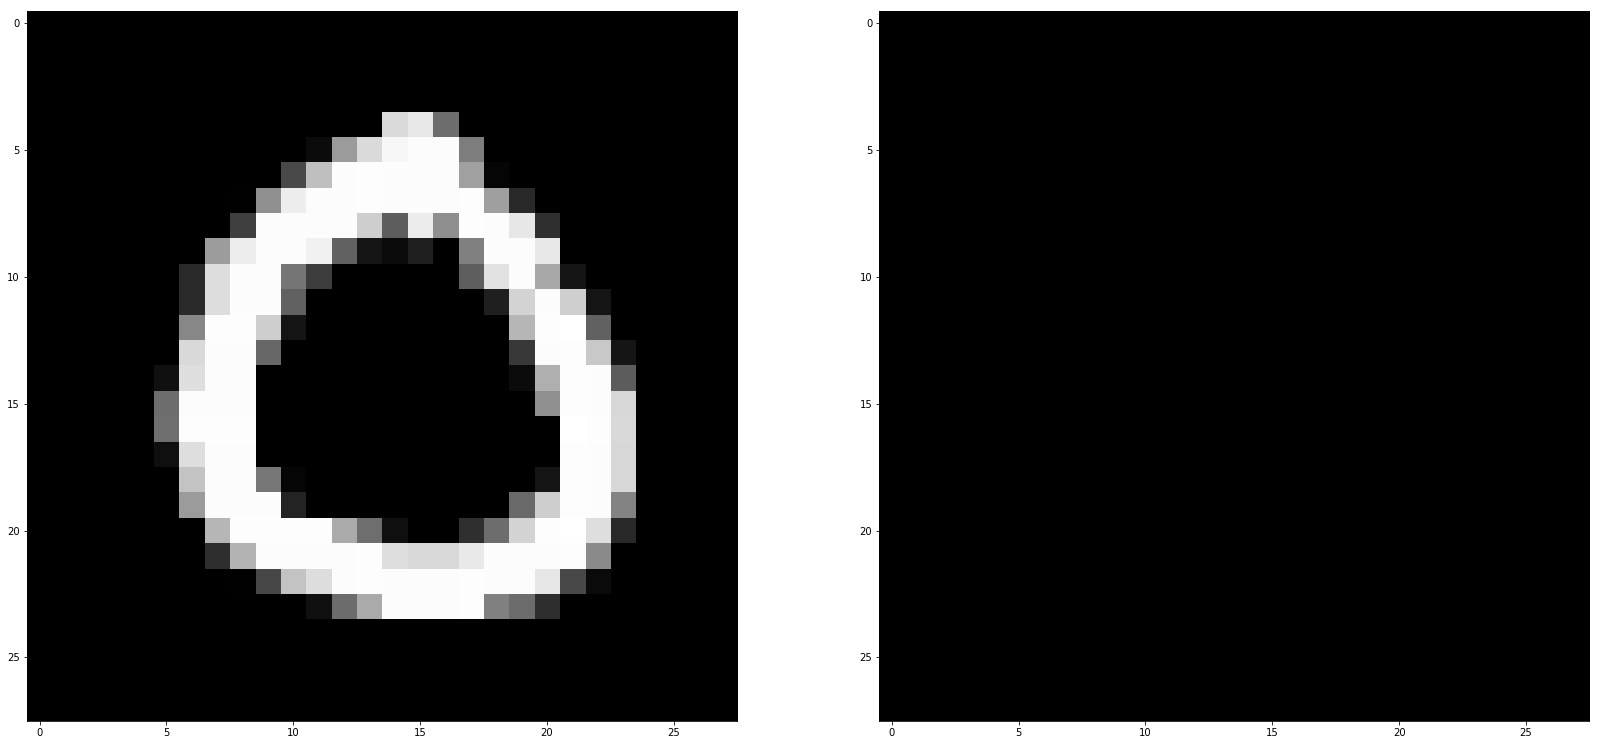

tensor(7893.7422, grad_fn=<MseLossBackward>)


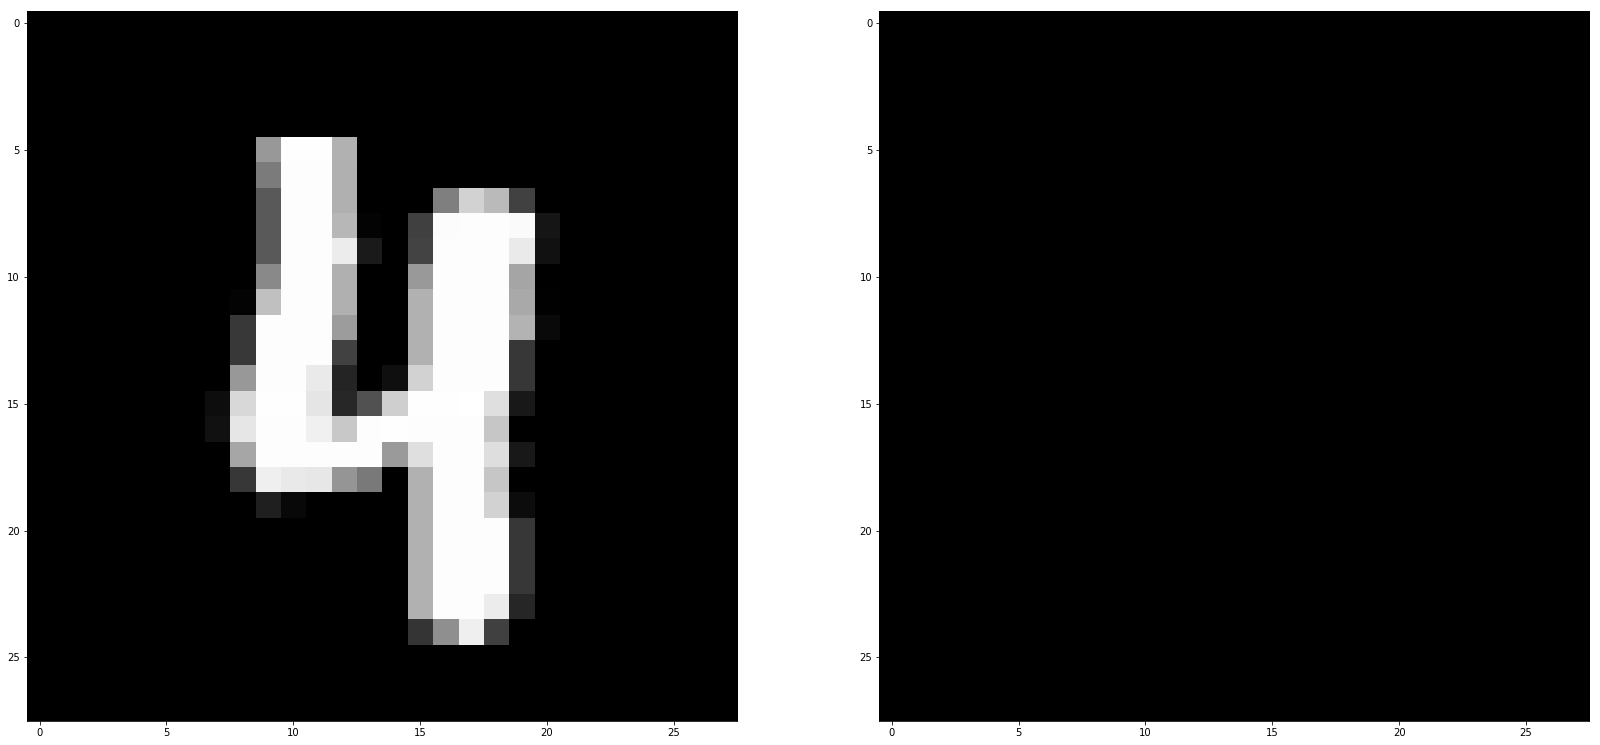

tensor(9202.8340, grad_fn=<MseLossBackward>)


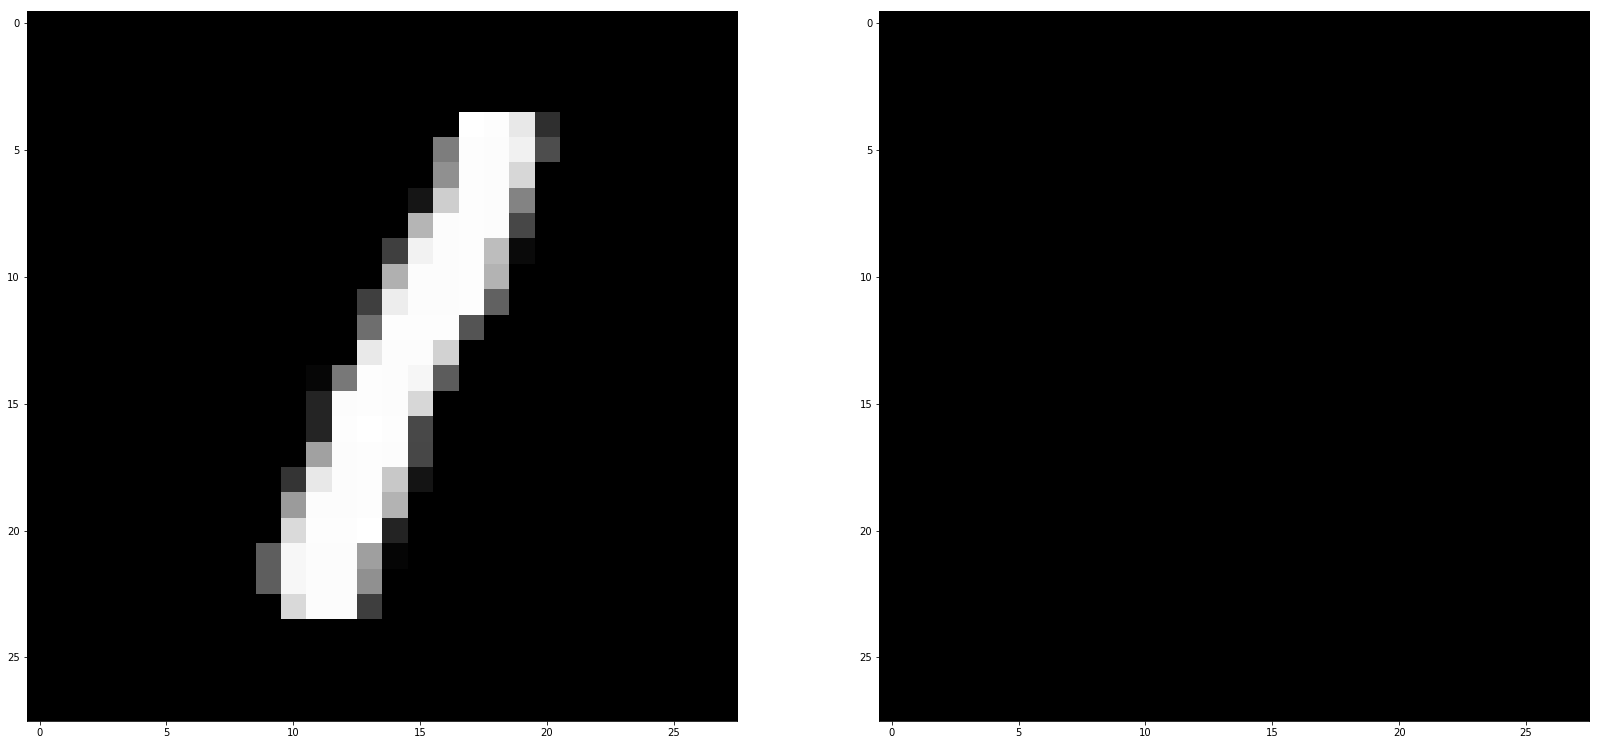

tensor(10663.2168, grad_fn=<MseLossBackward>)


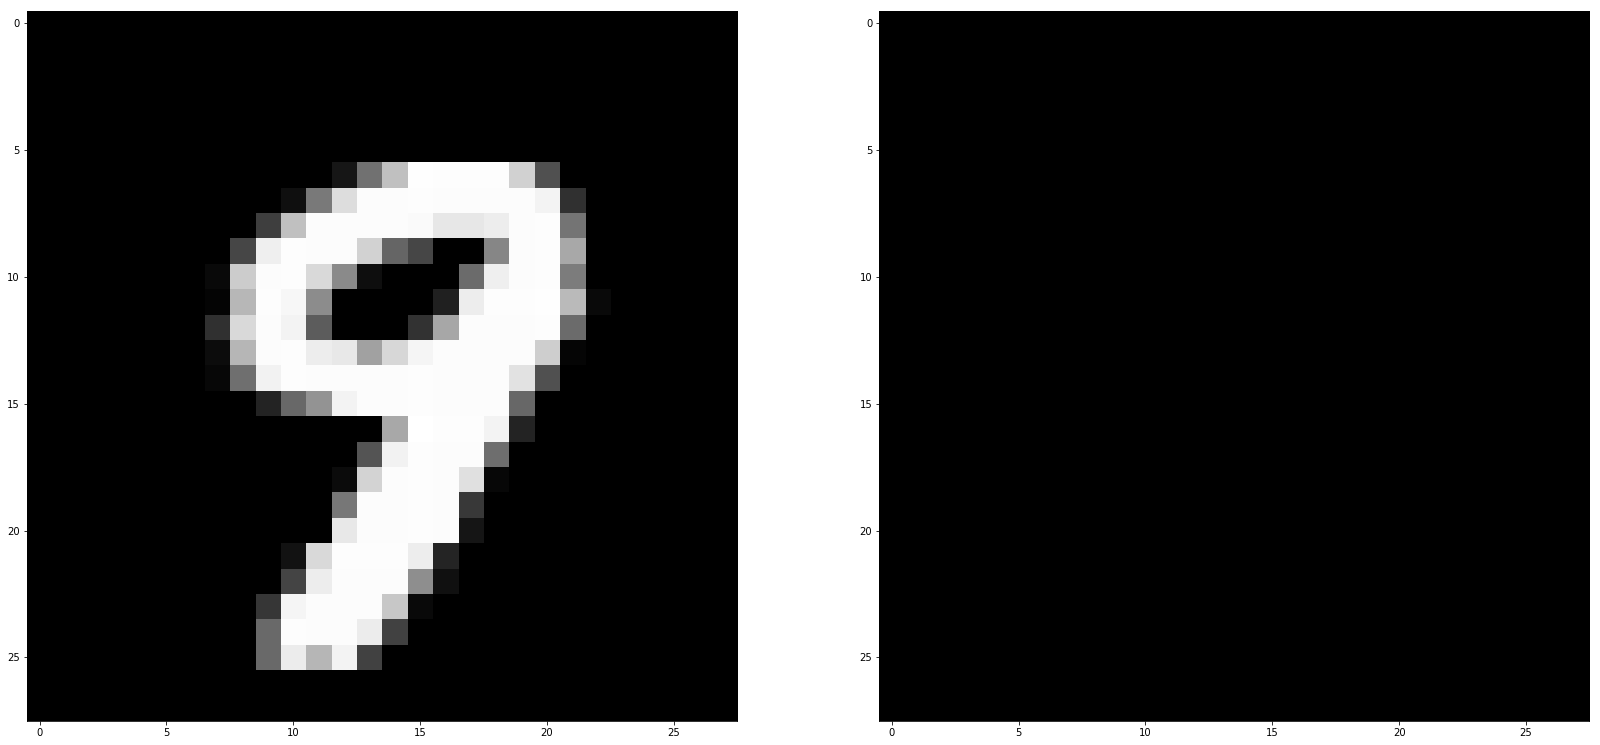

tensor(3946.1885, grad_fn=<MseLossBackward>)


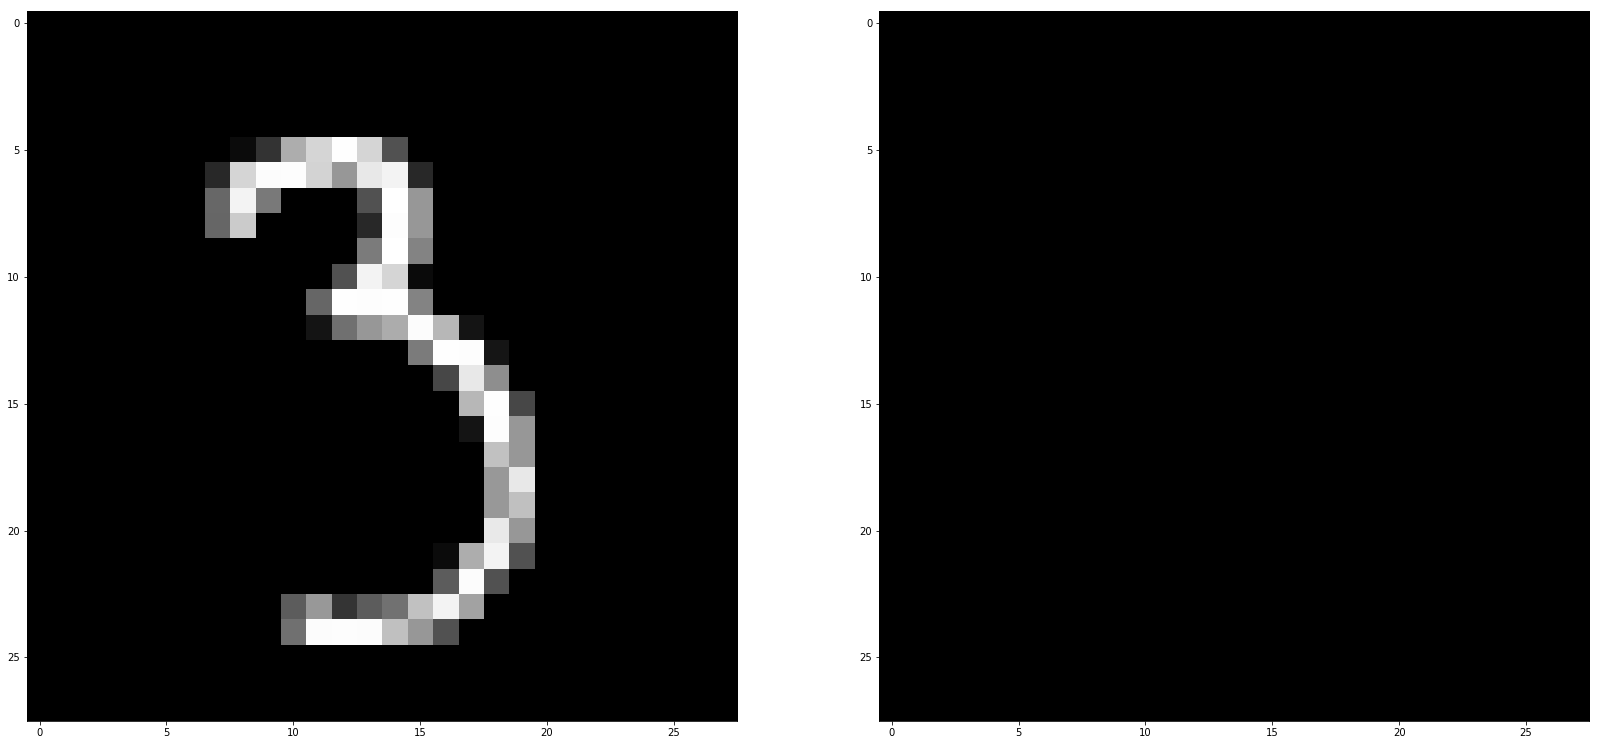

tensor(2296.8557, grad_fn=<MseLossBackward>)


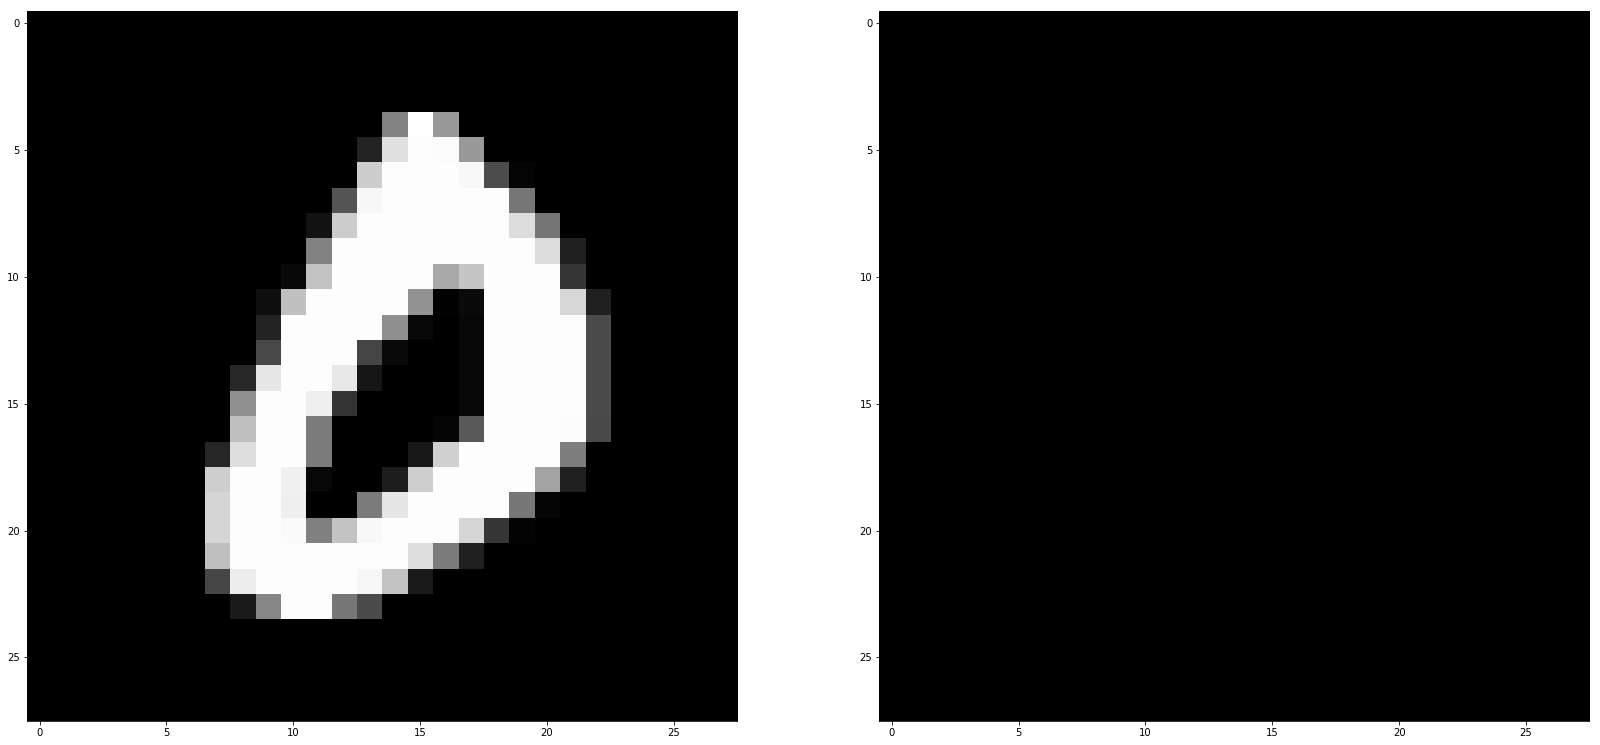

tensor(8917.7607, grad_fn=<MseLossBackward>)


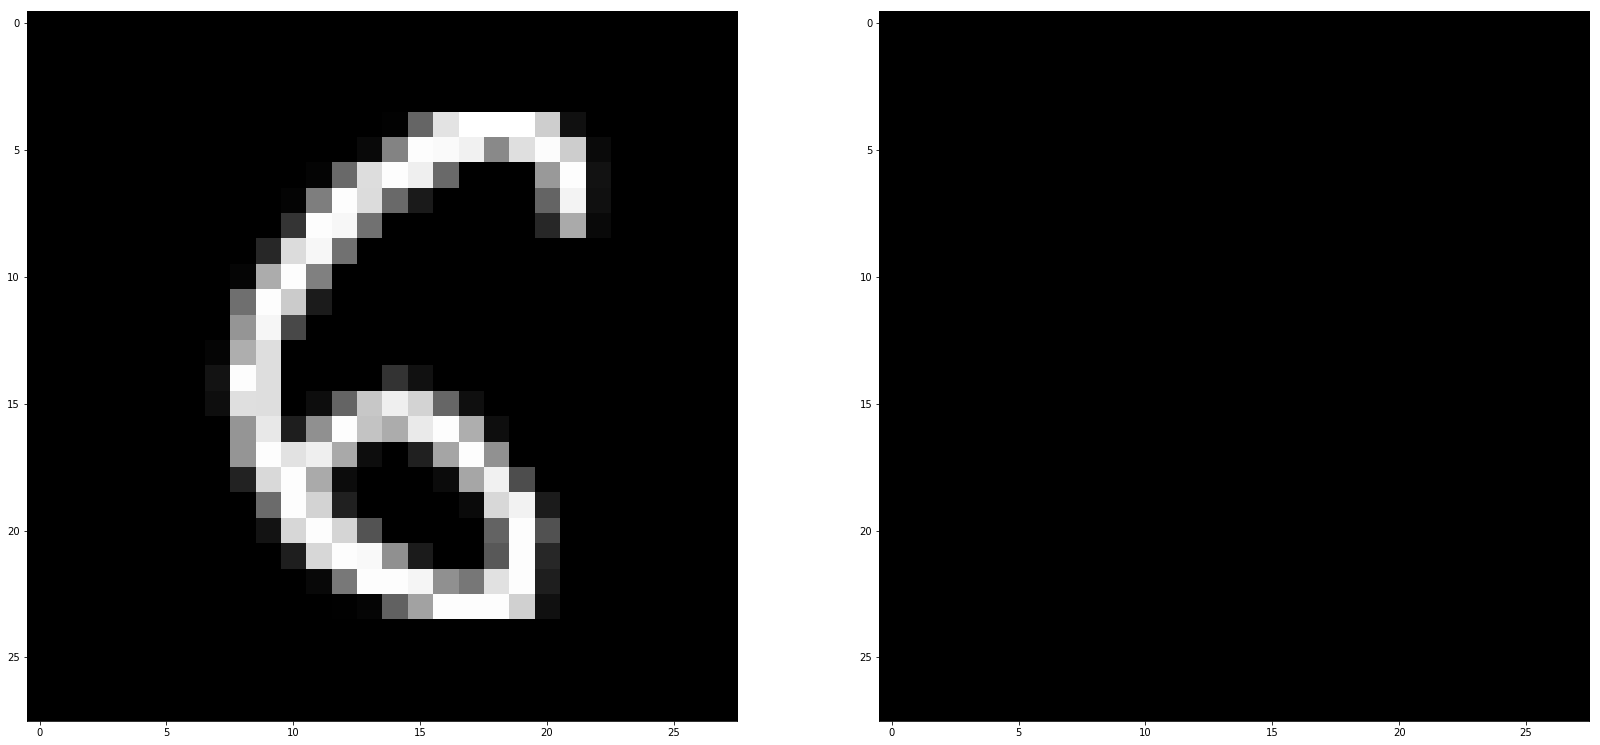

tensor(5827.9775, grad_fn=<MseLossBackward>)


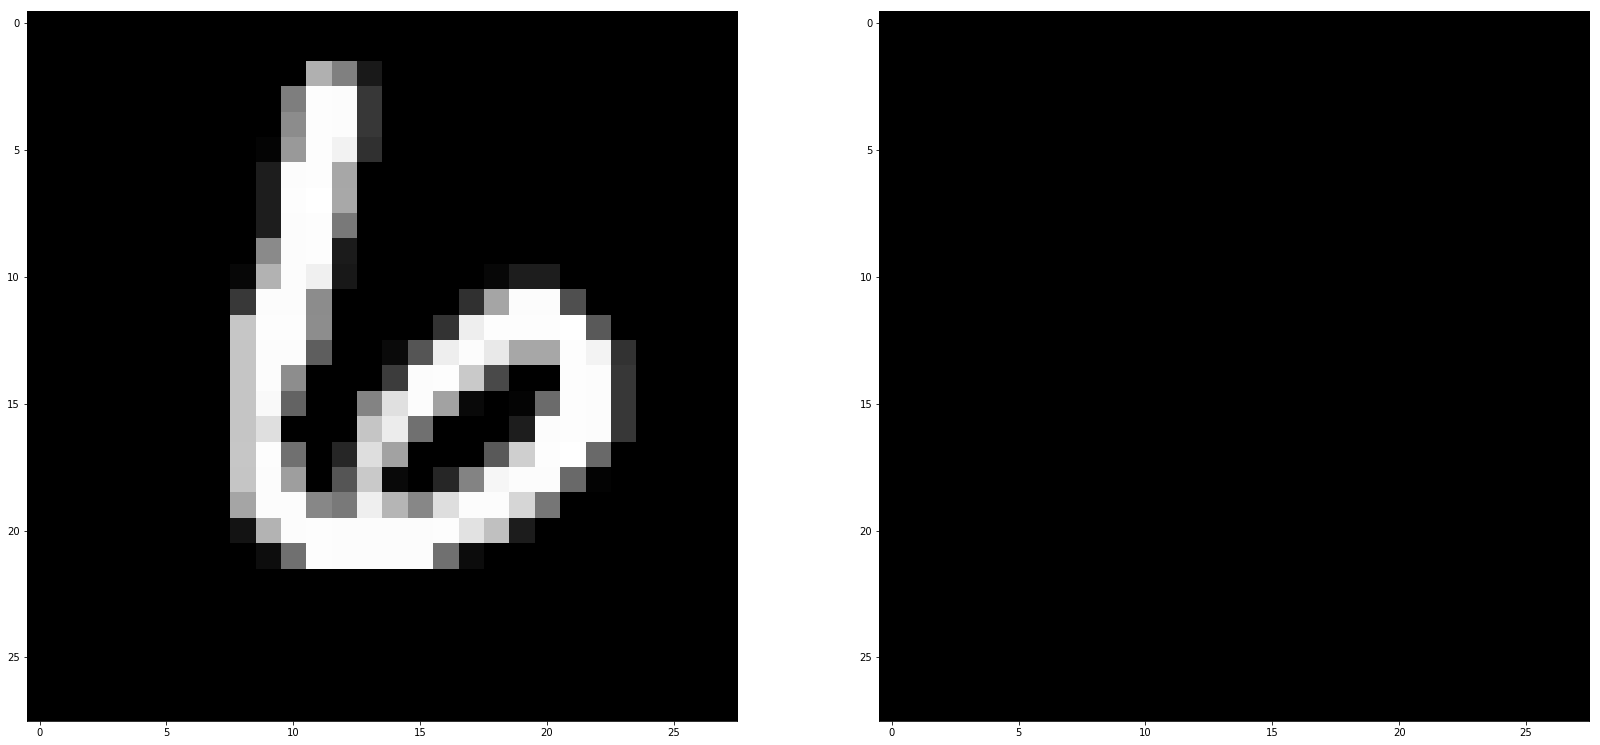

tensor(8654.4365, grad_fn=<MseLossBackward>)


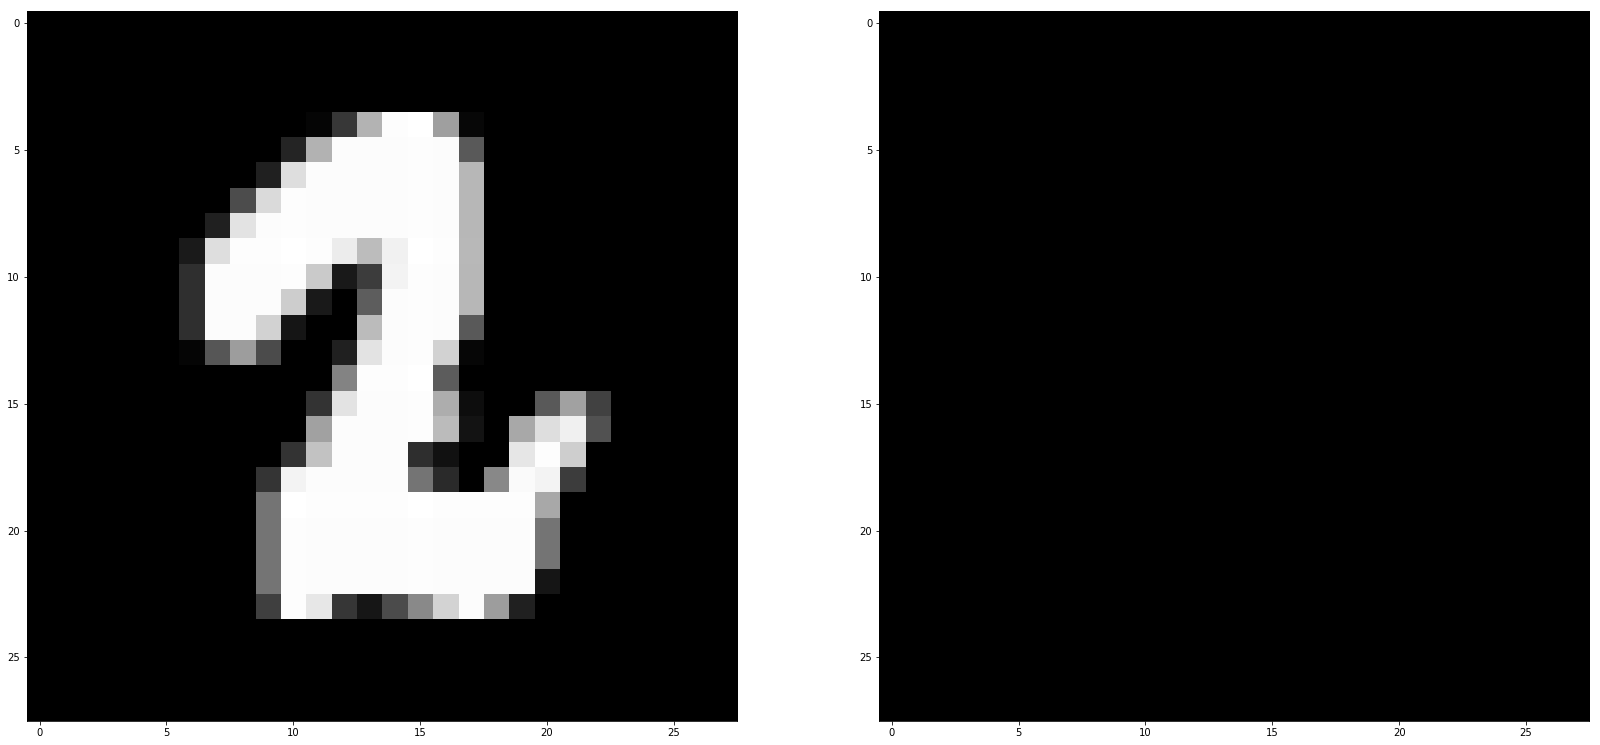

tensor(5661.6226, grad_fn=<MseLossBackward>)


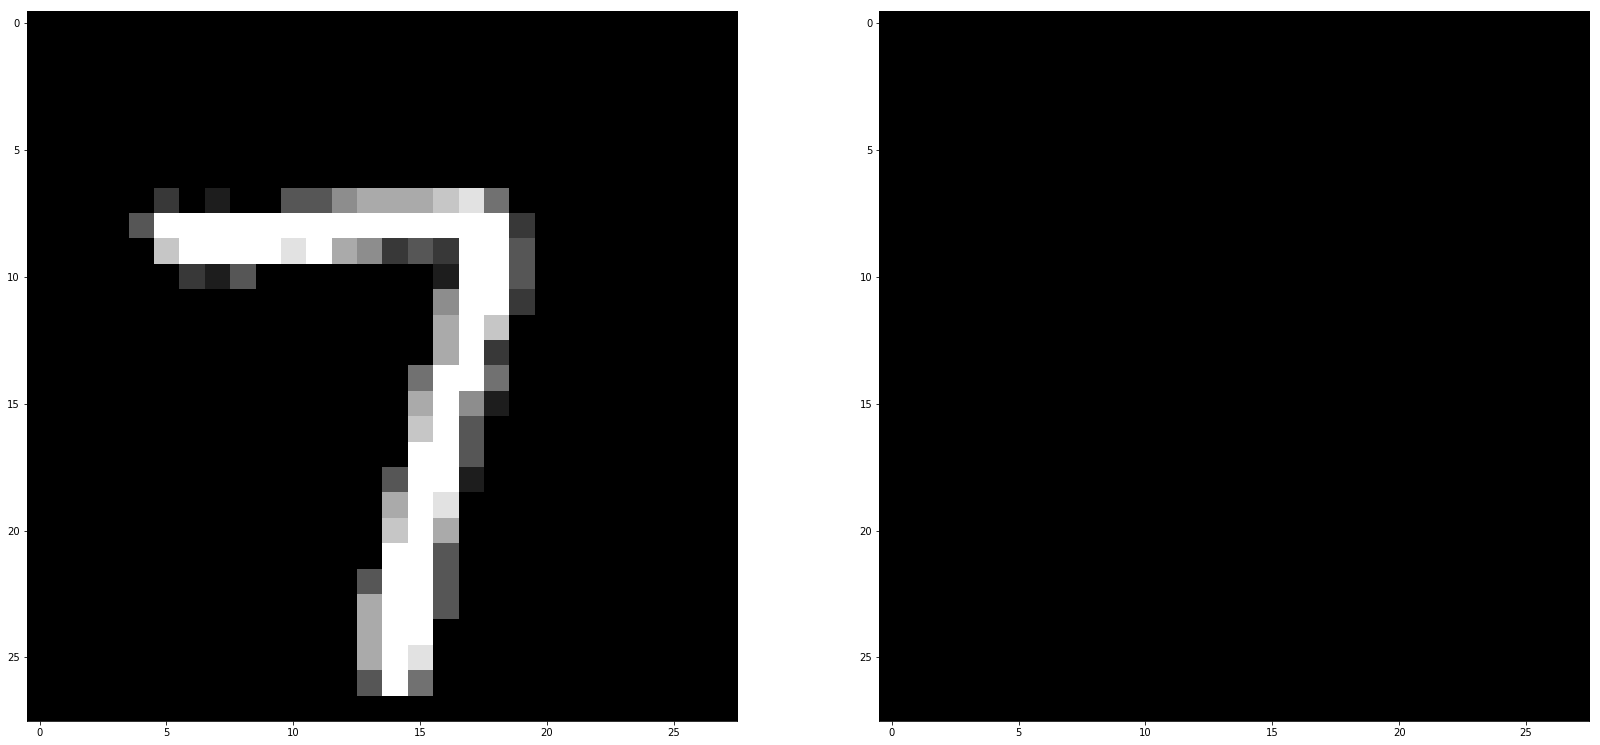

tensor(5593.0322, grad_fn=<MseLossBackward>)


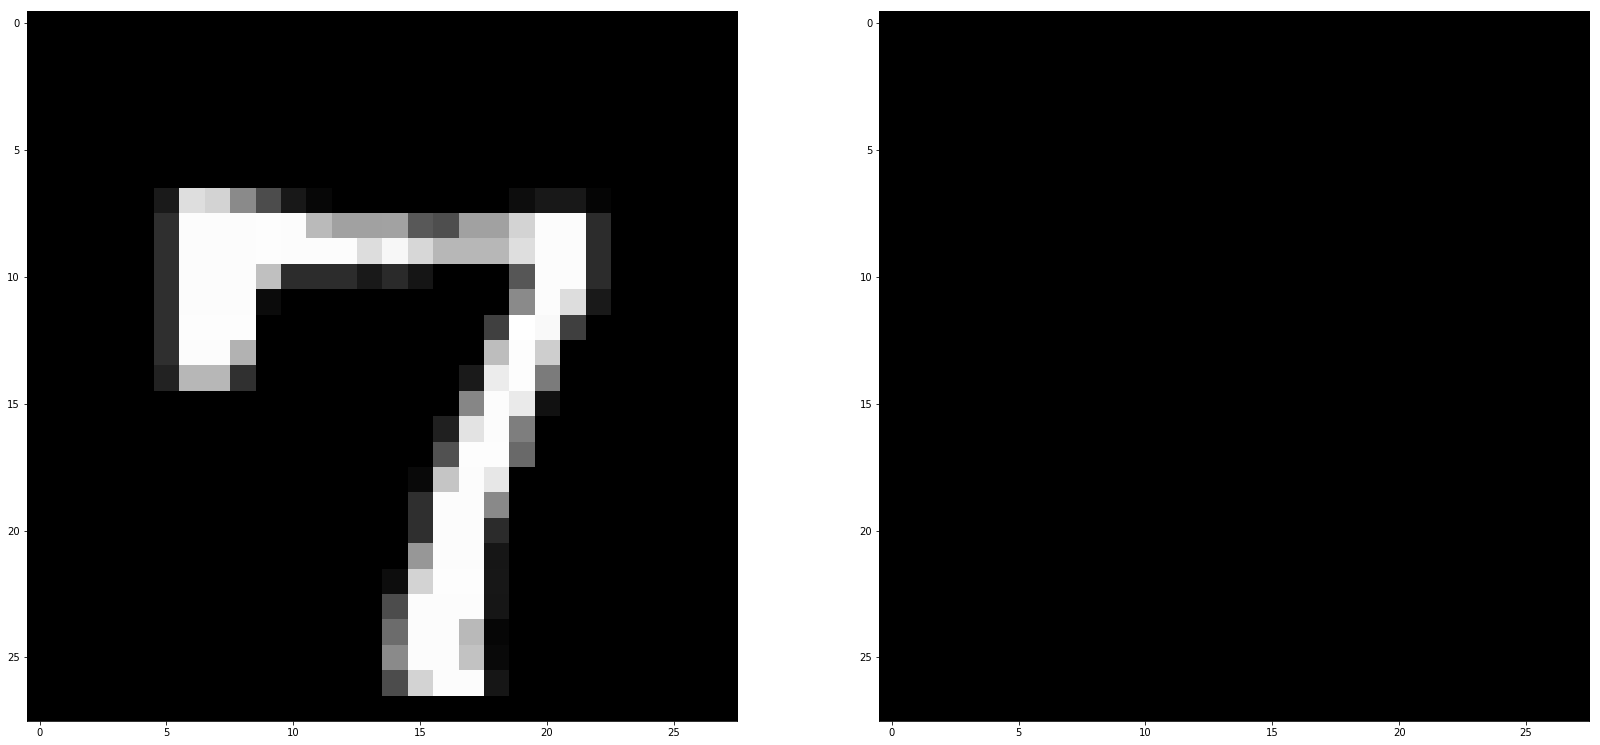

tensor(3043.1677, grad_fn=<MseLossBackward>)


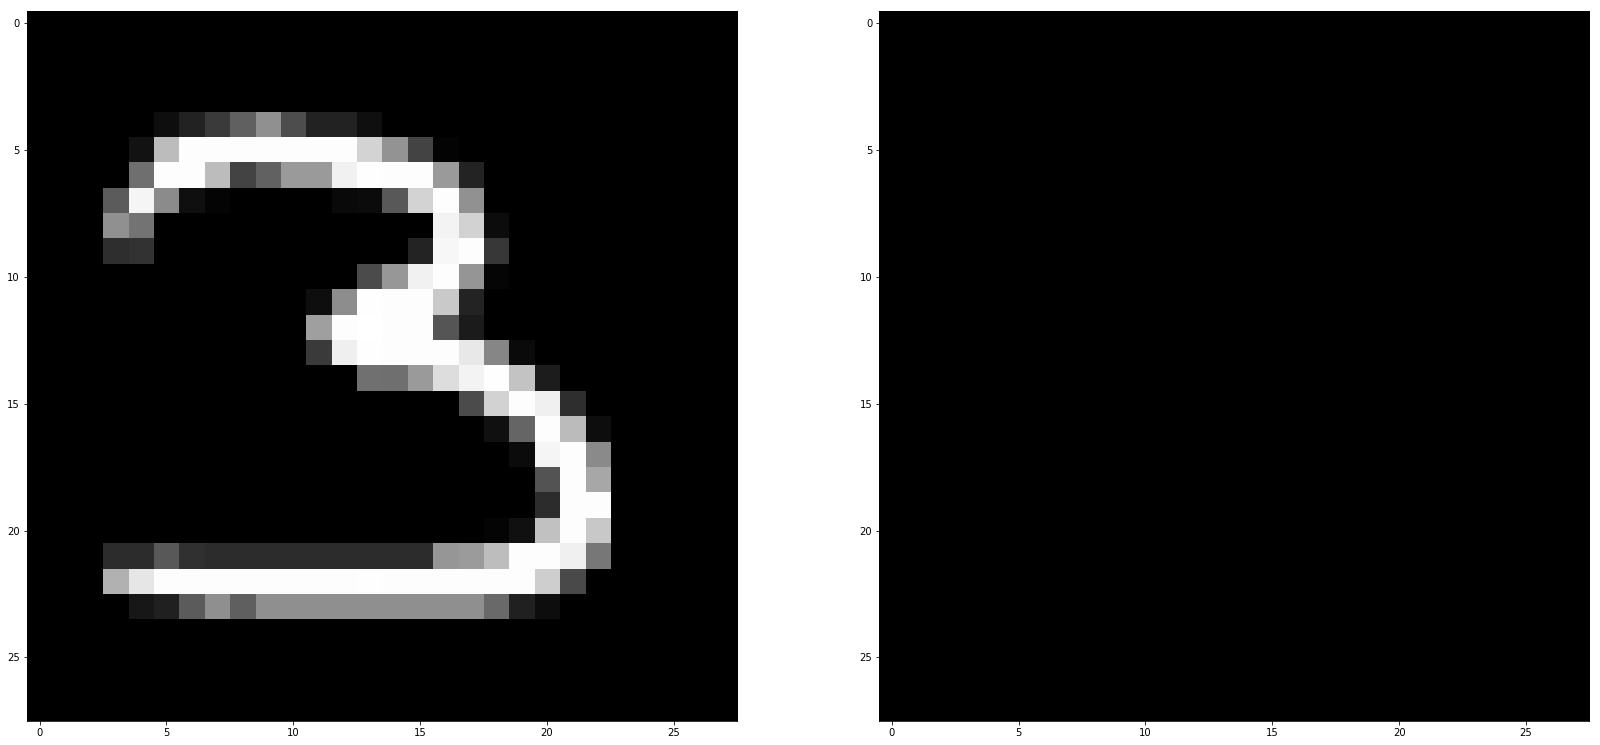

tensor(5713.4102, grad_fn=<MseLossBackward>)


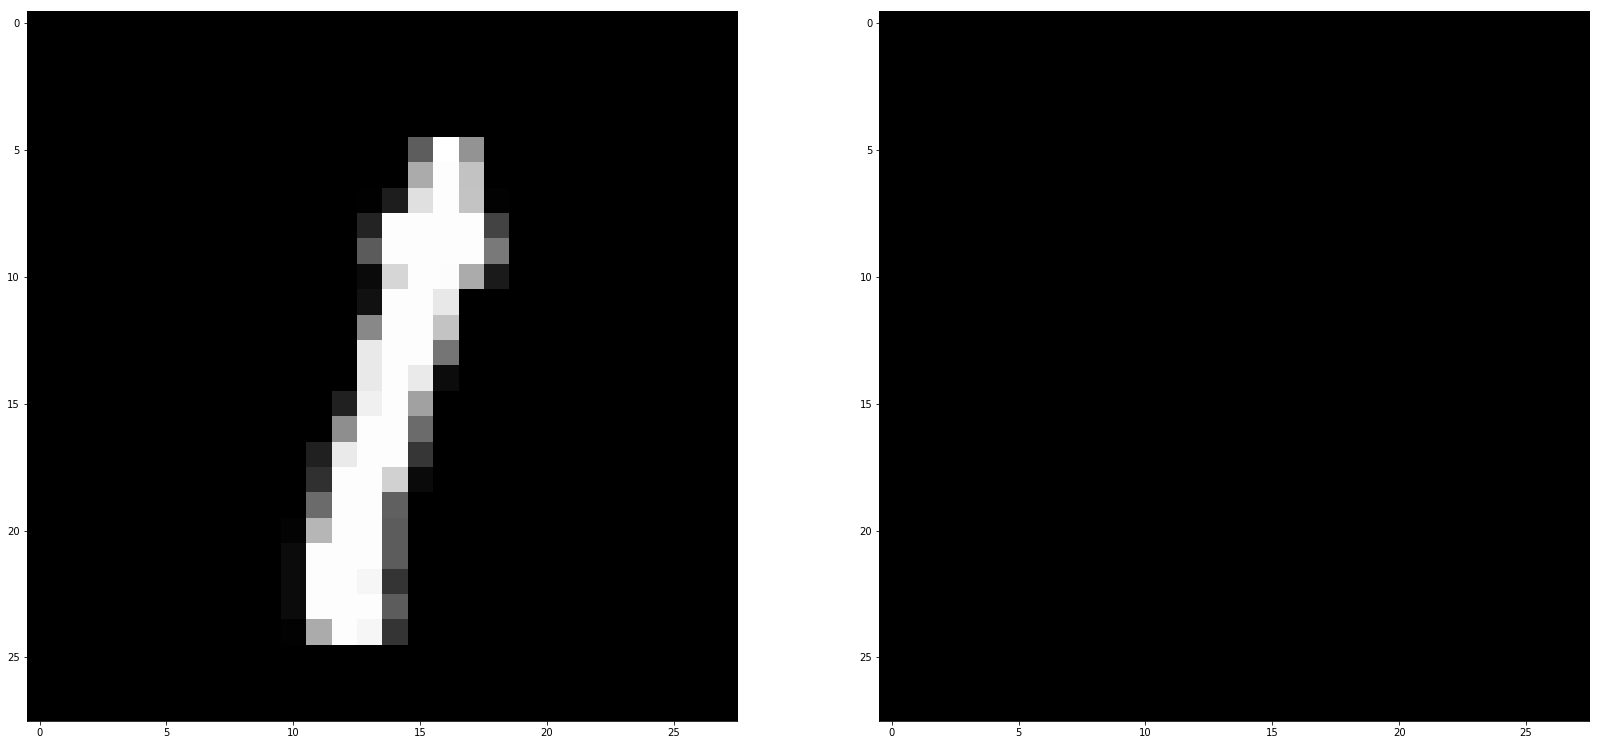

tensor(6076.7207, grad_fn=<MseLossBackward>)


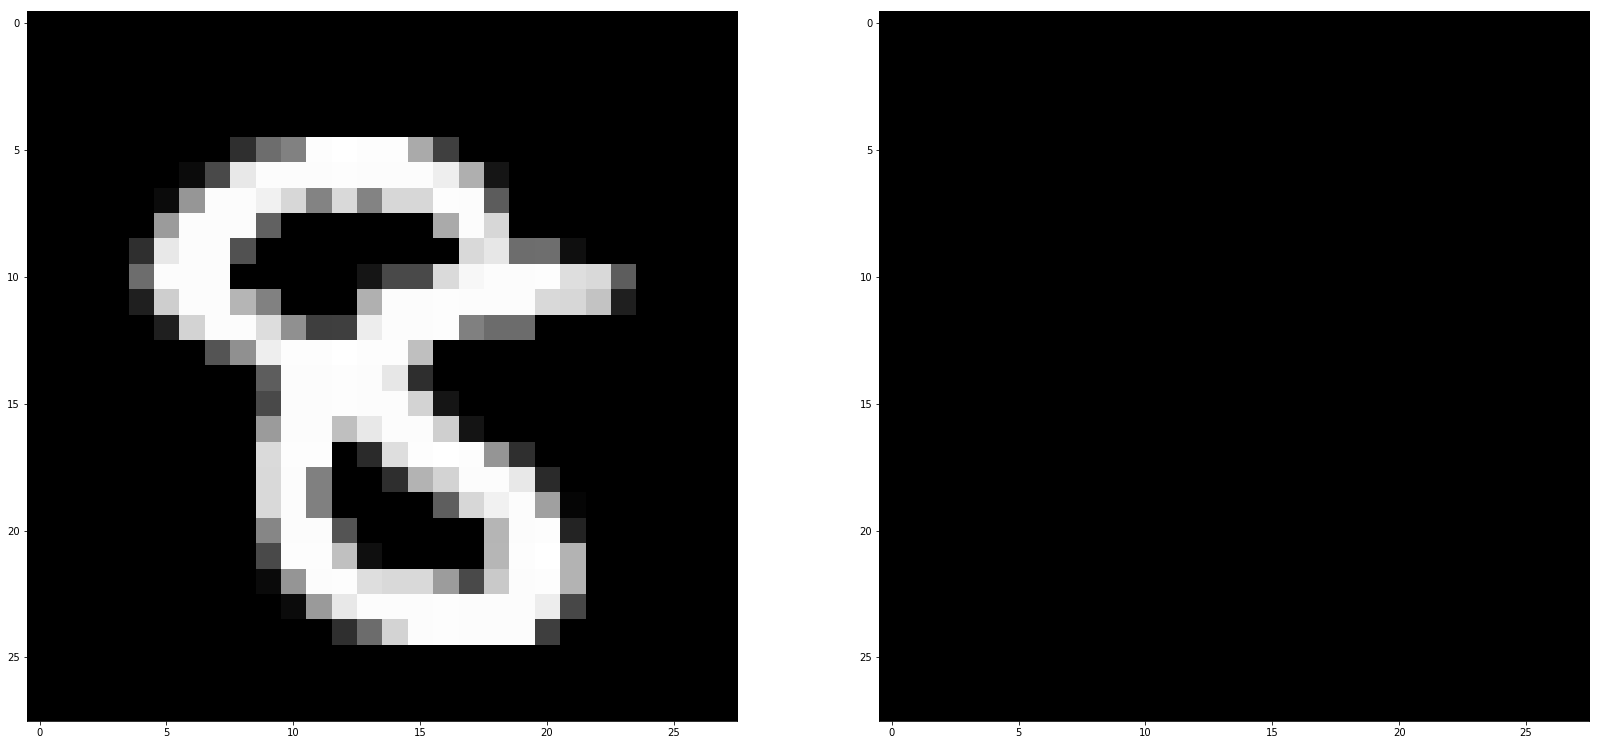

tensor(4945.3647, grad_fn=<MseLossBackward>)


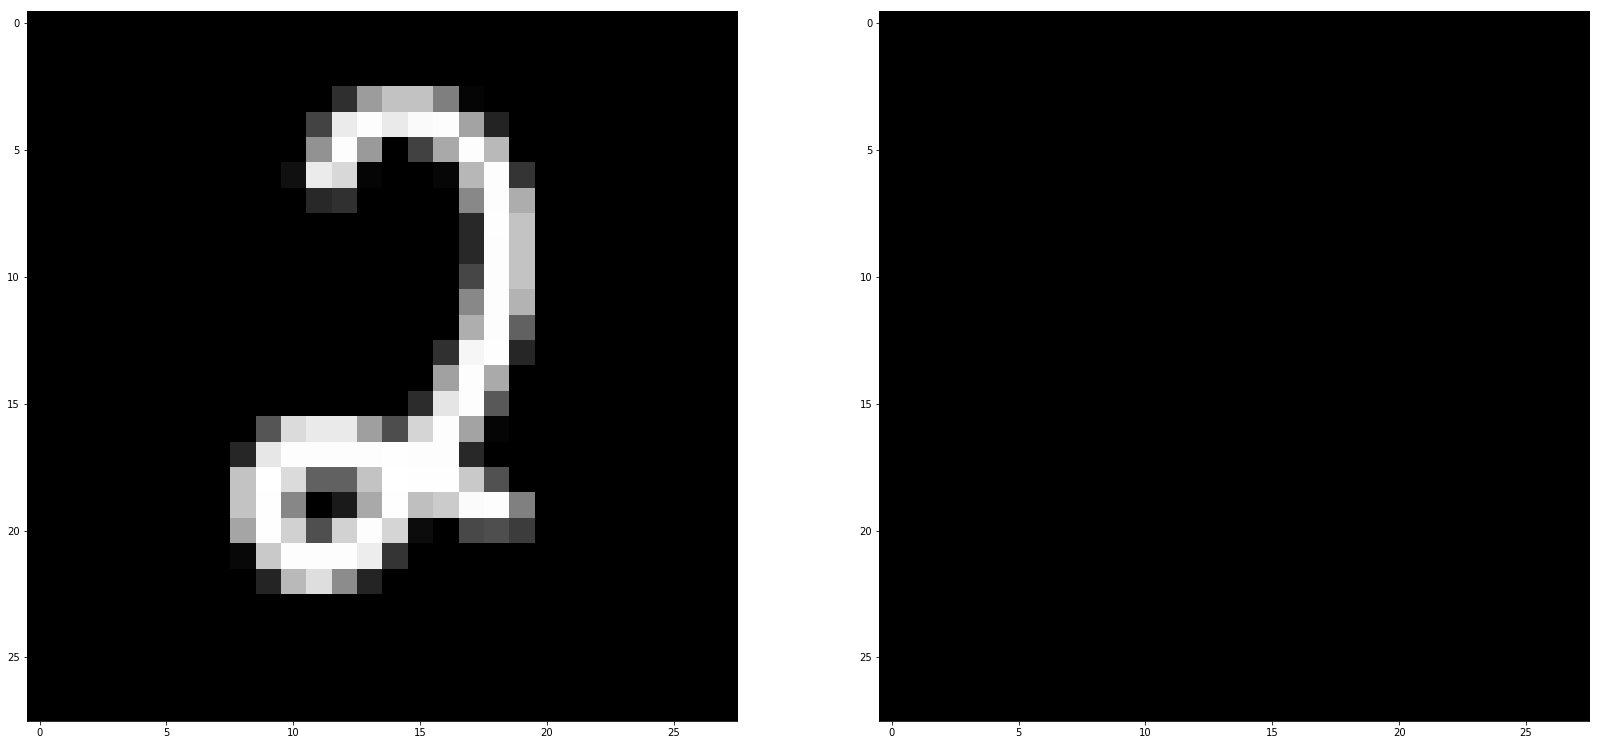

tensor(3953.7070, grad_fn=<MseLossBackward>)


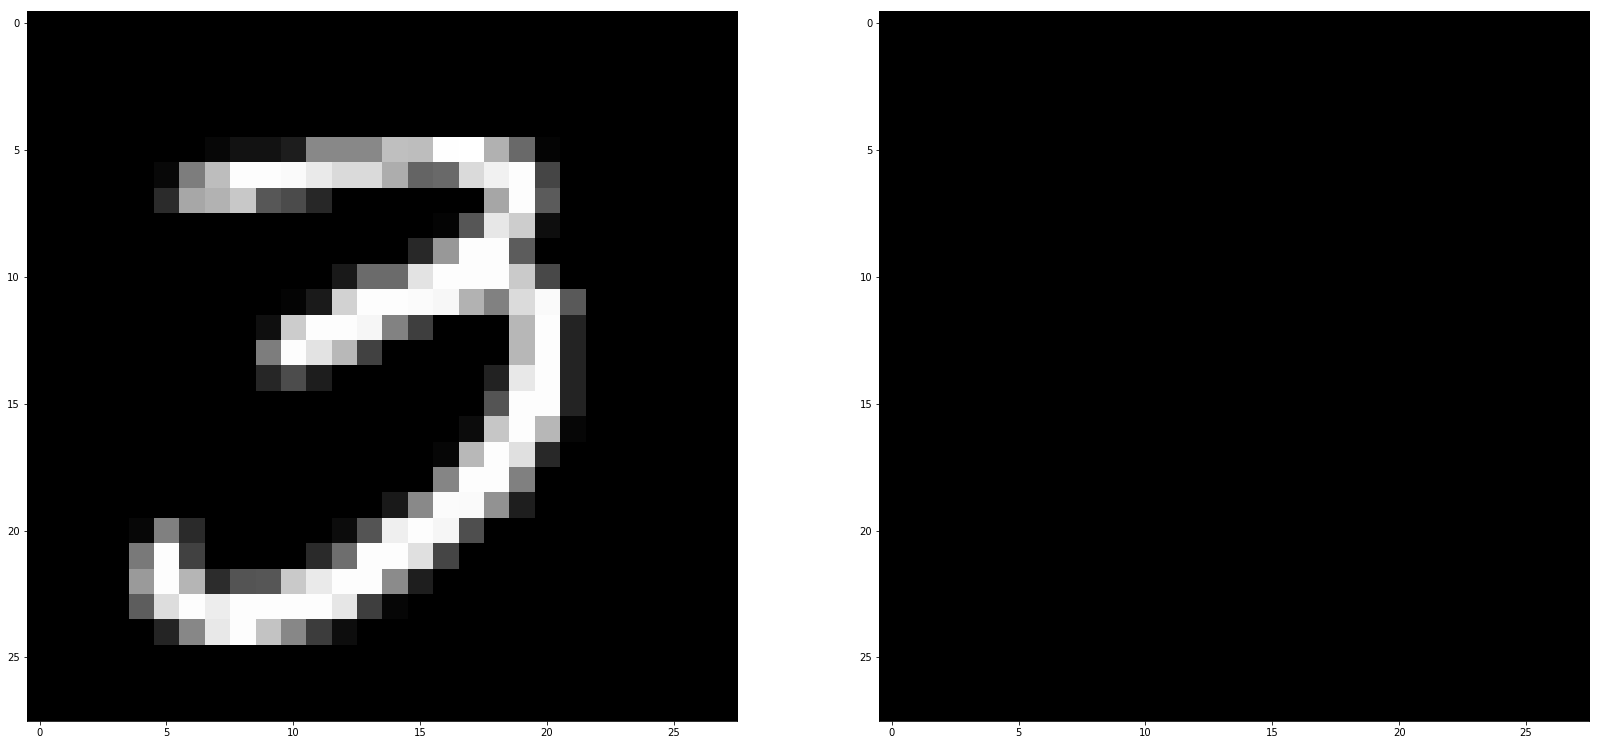

tensor(3745.4446, grad_fn=<MseLossBackward>)


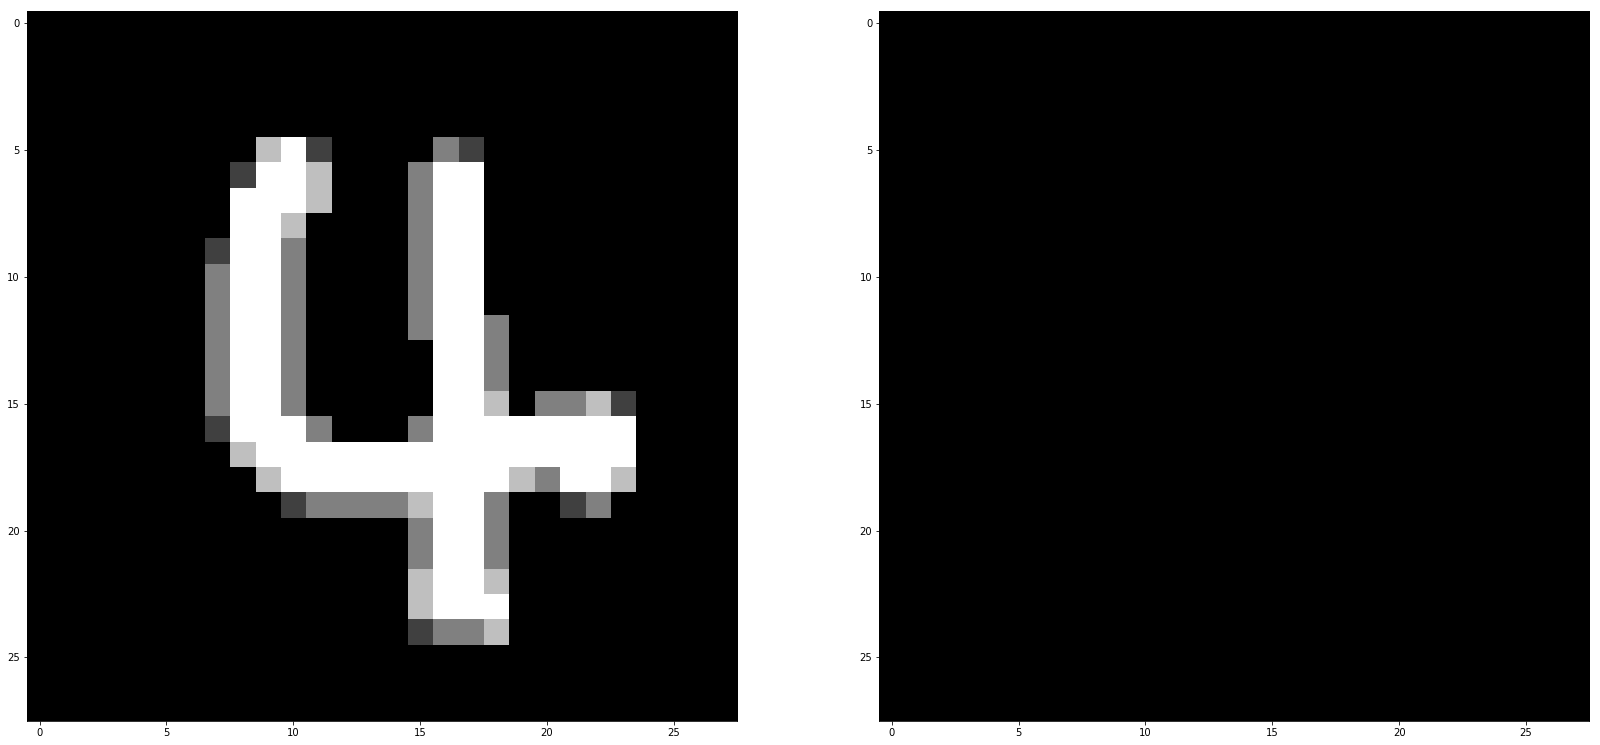

tensor(4380.5820, grad_fn=<MseLossBackward>)


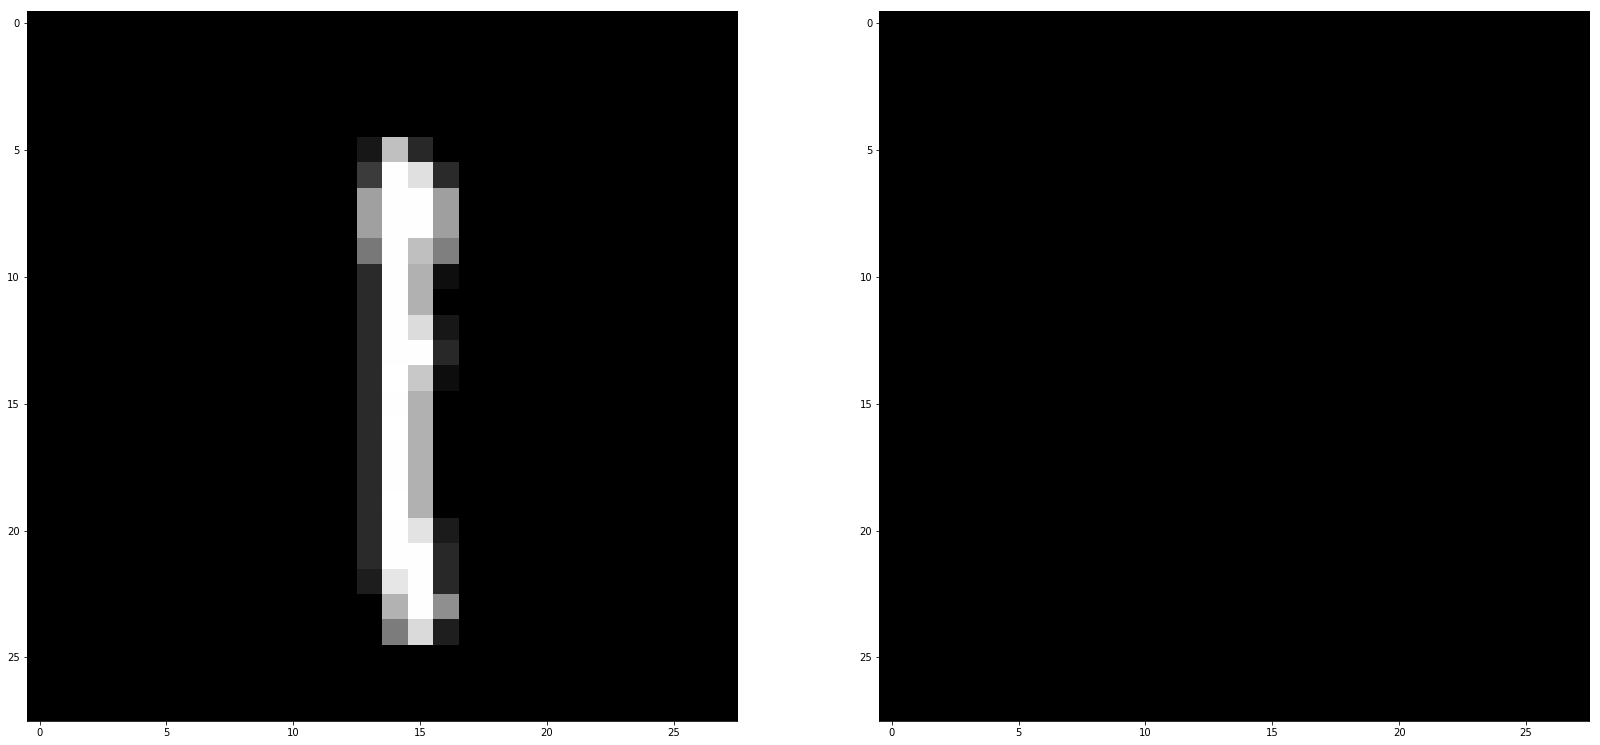

tensor(2917.1804, grad_fn=<MseLossBackward>)


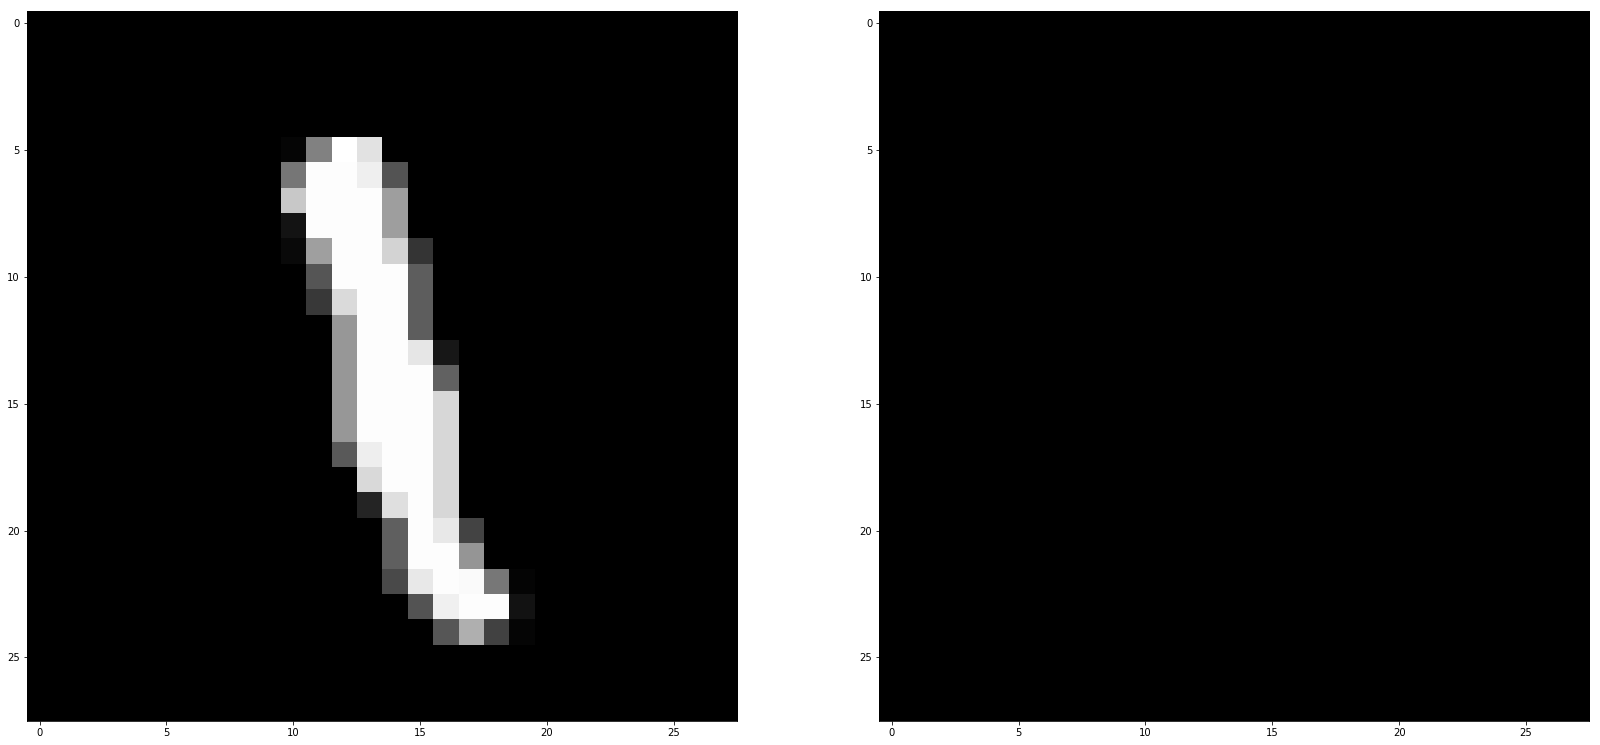

tensor(2271.5637, grad_fn=<MseLossBackward>)


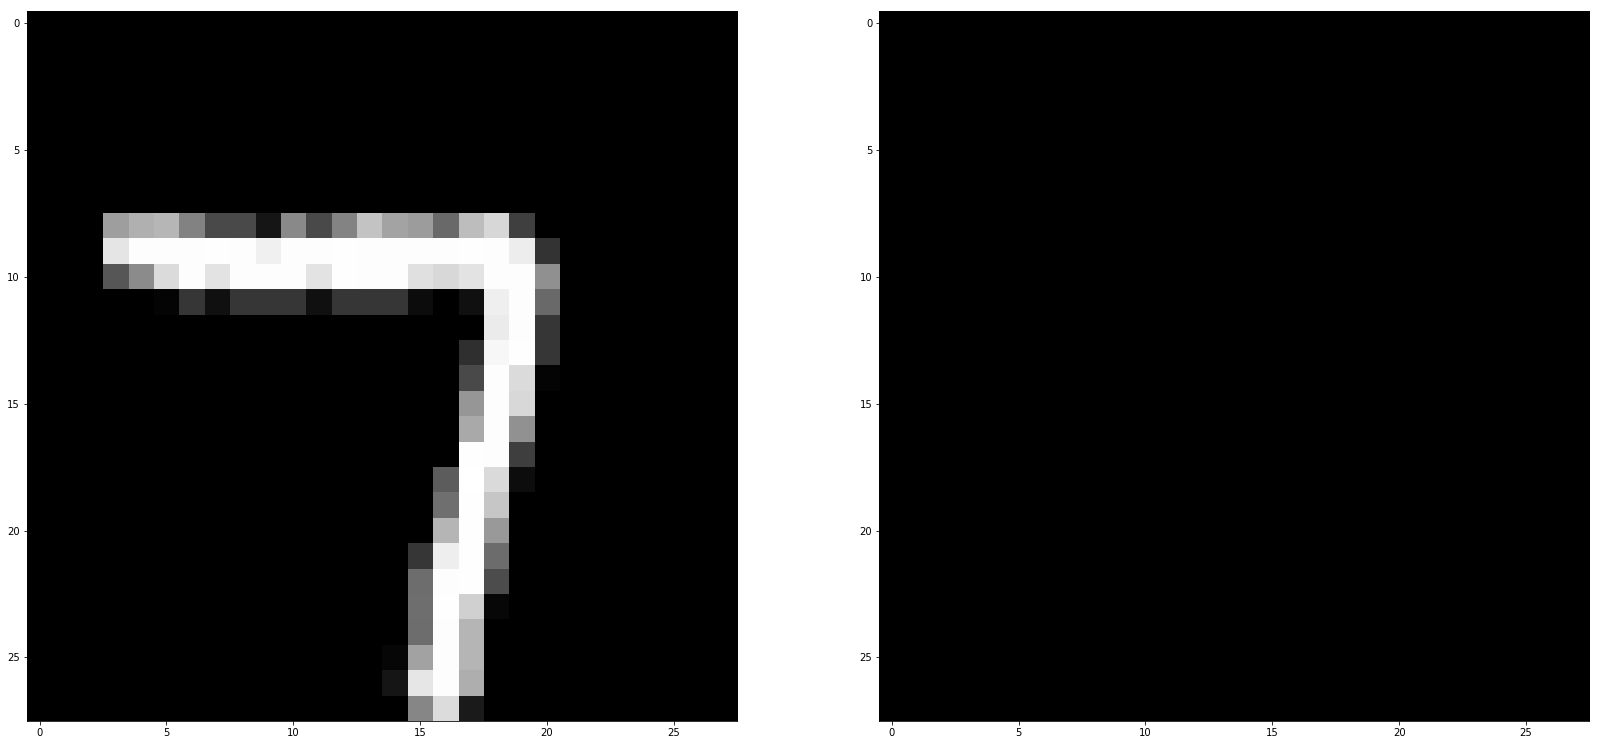

tensor(2529.7019, grad_fn=<MseLossBackward>)


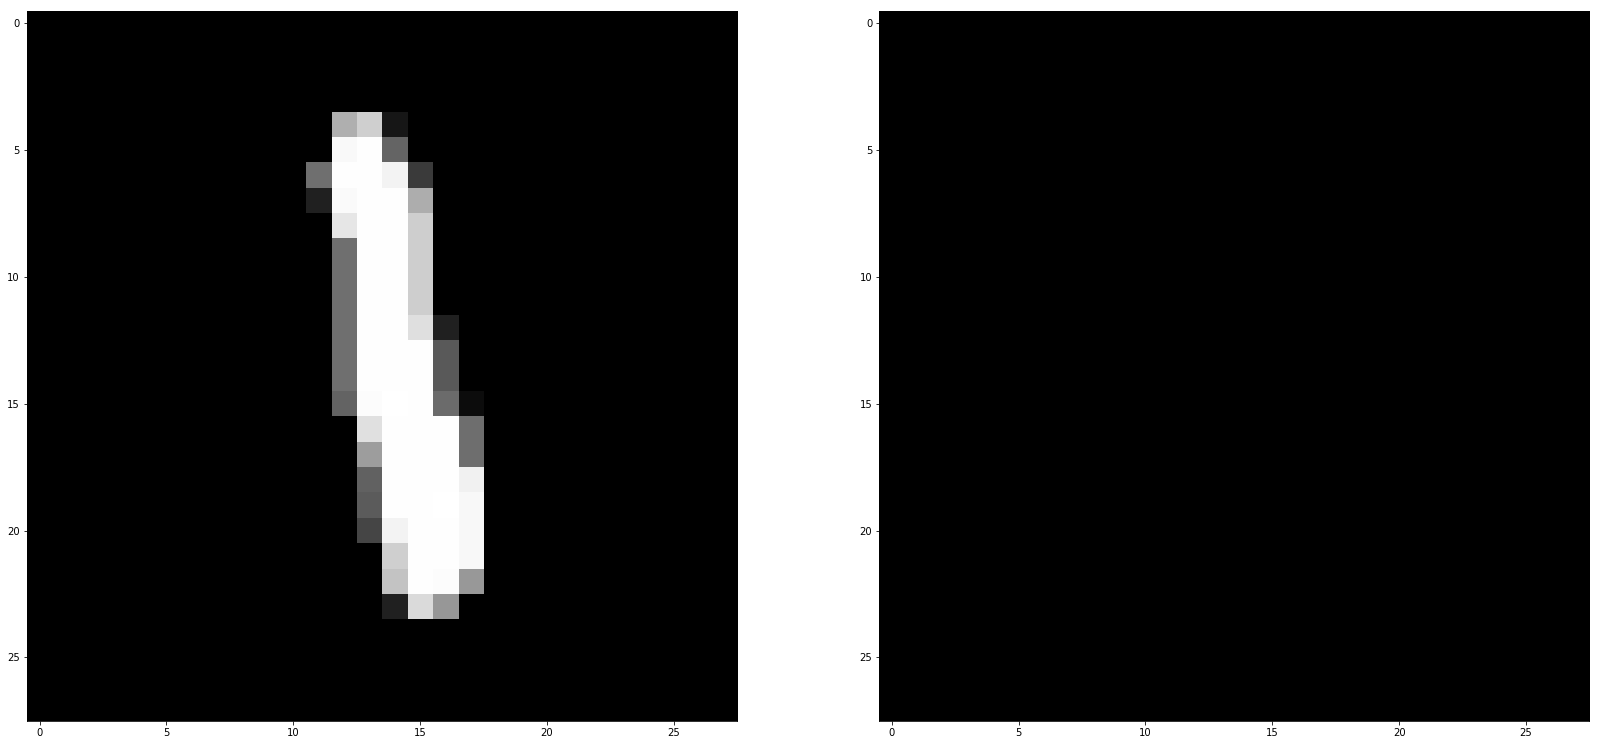

tensor(4118.4009, grad_fn=<MseLossBackward>)


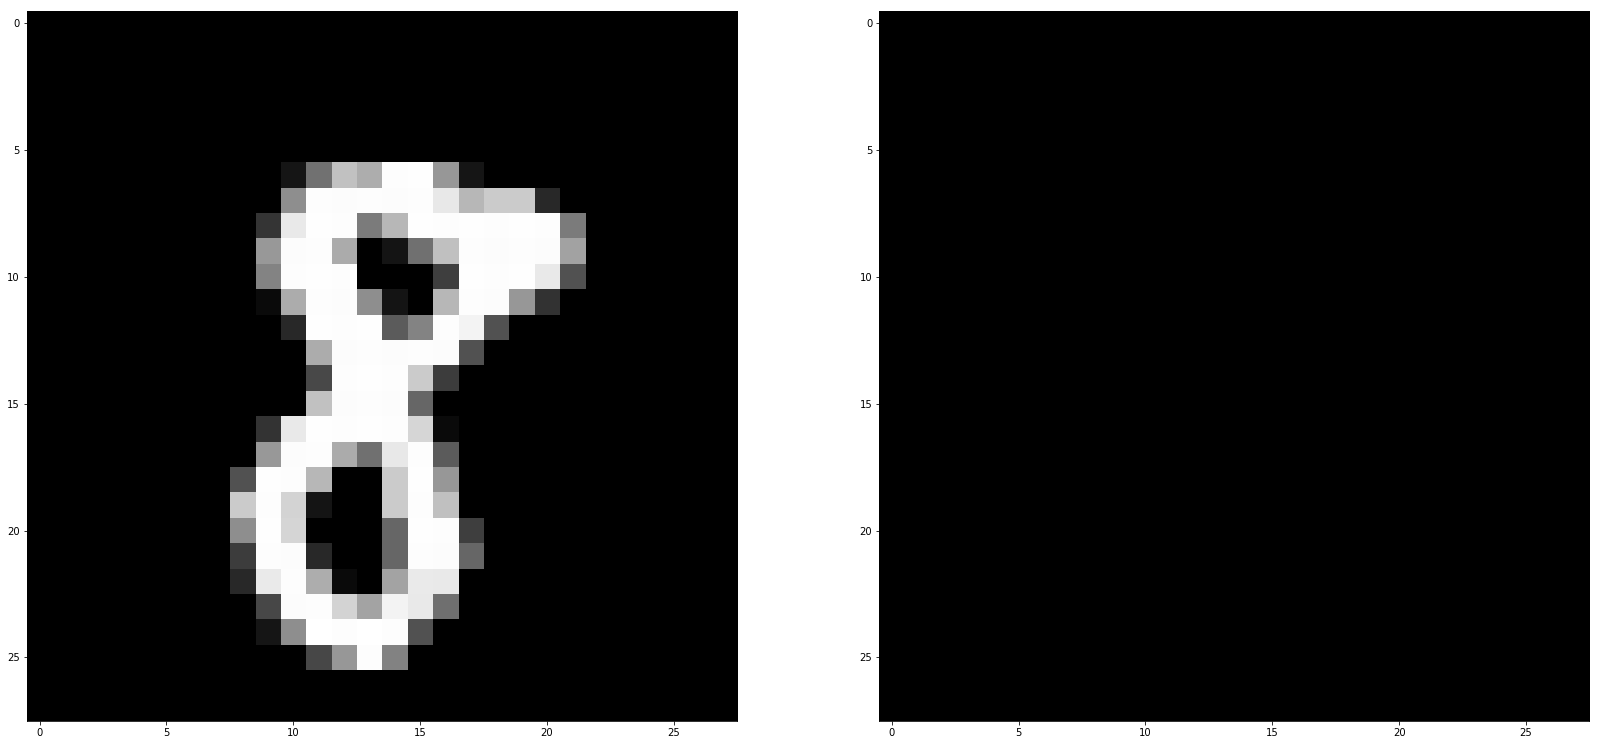

tensor(2402.1040, grad_fn=<MseLossBackward>)


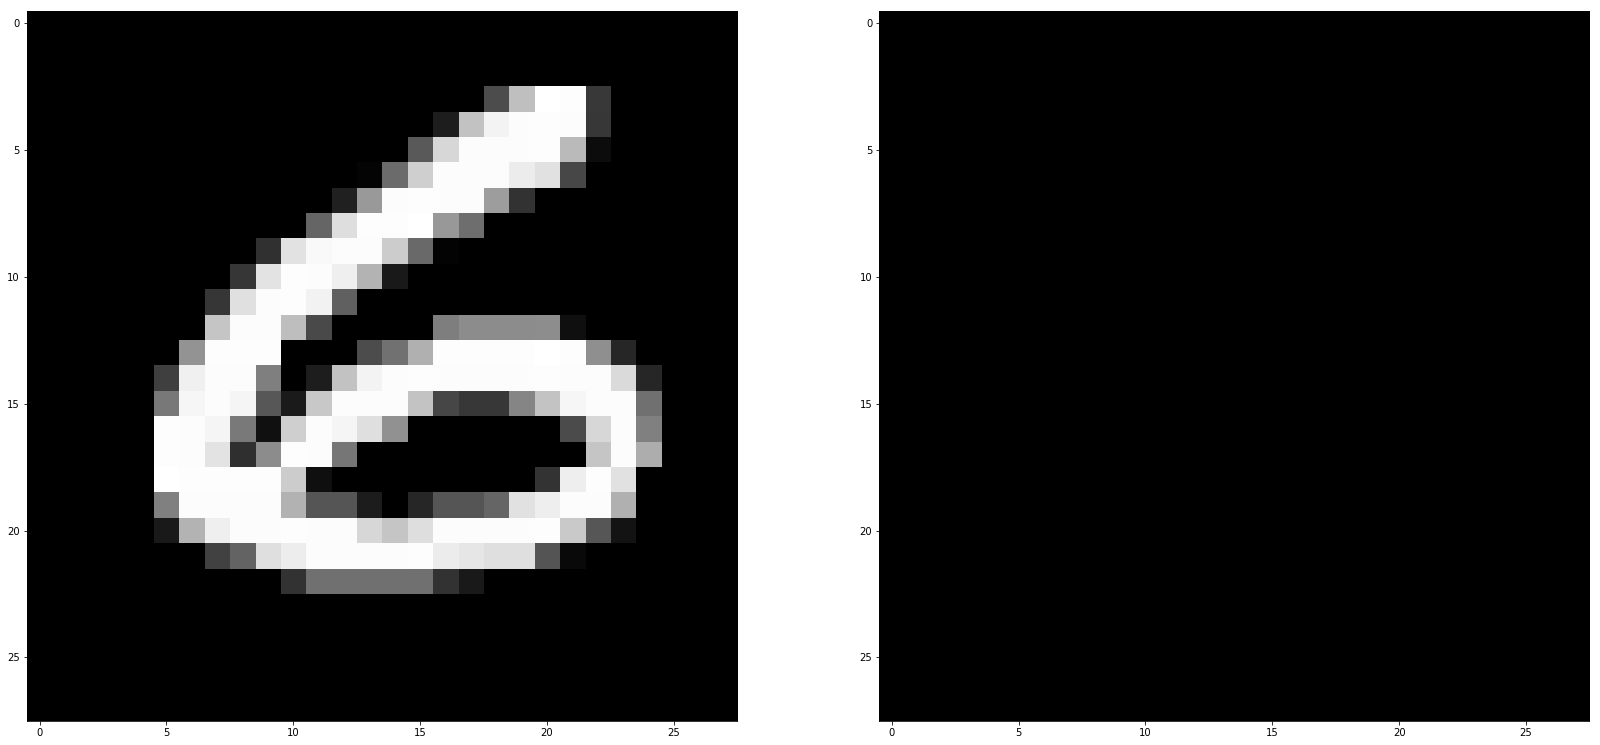

tensor(3173.6516, grad_fn=<MseLossBackward>)


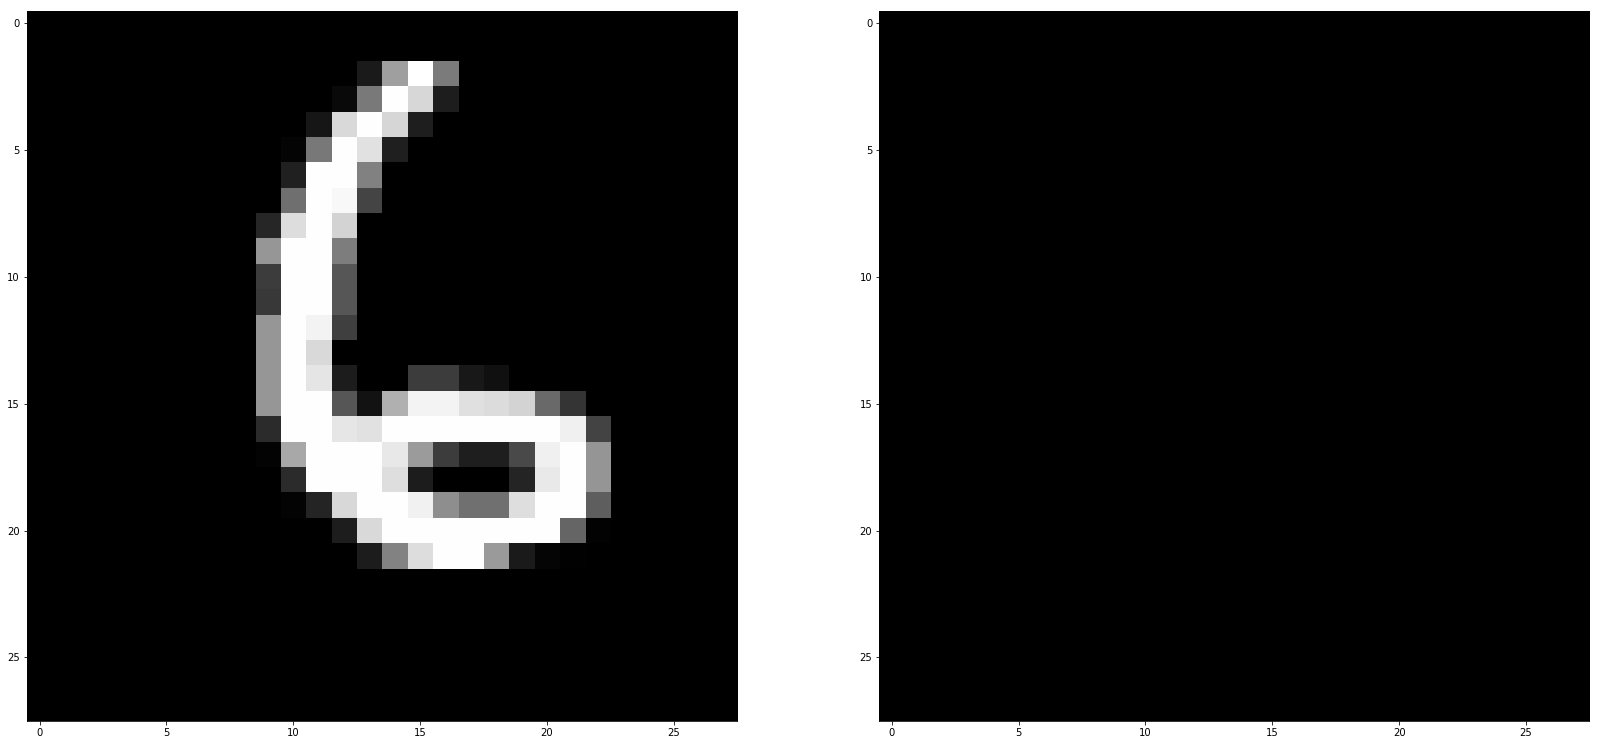

tensor(7091.0811, grad_fn=<MseLossBackward>)


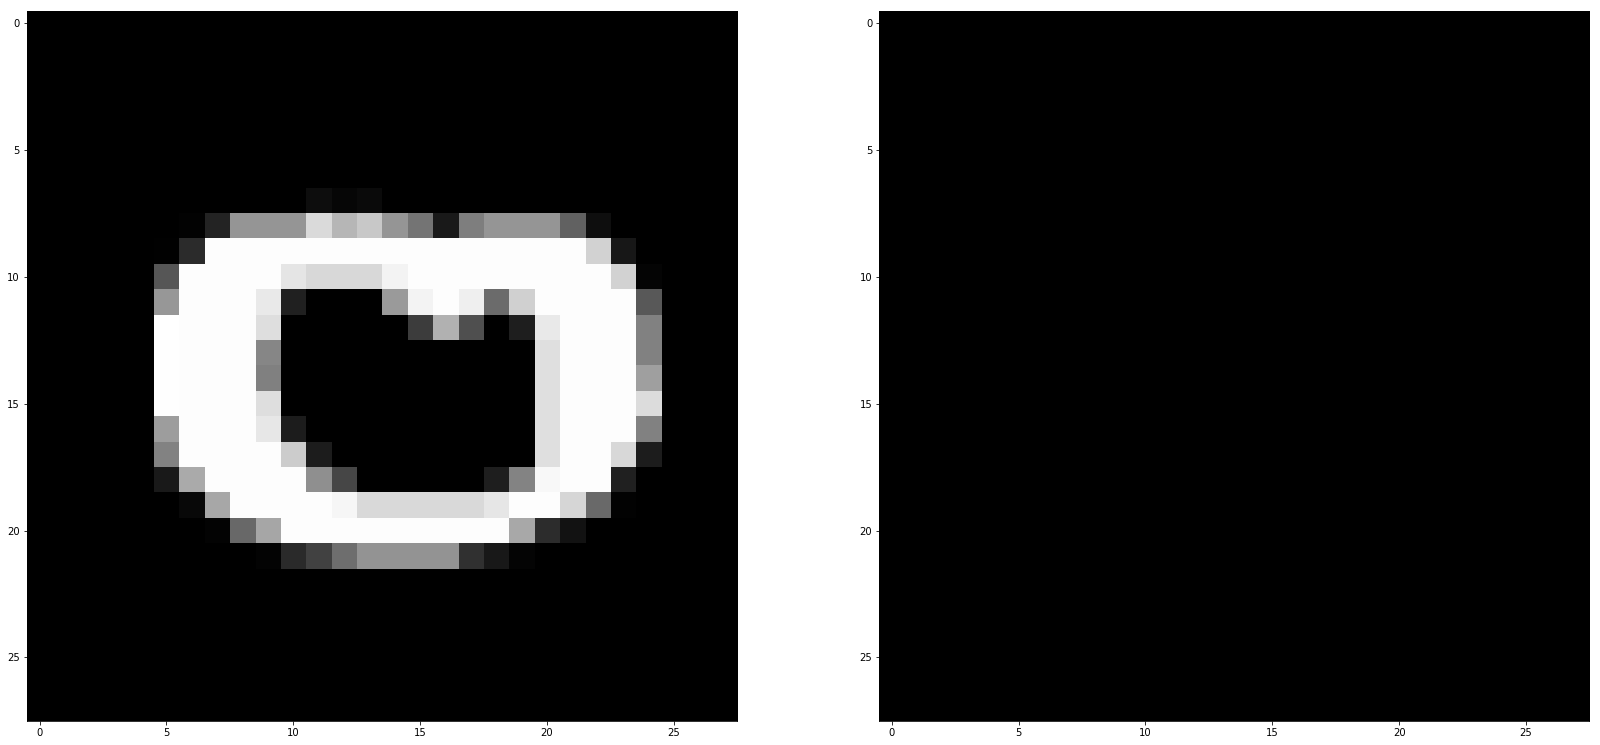

tensor(4176.0430, grad_fn=<MseLossBackward>)


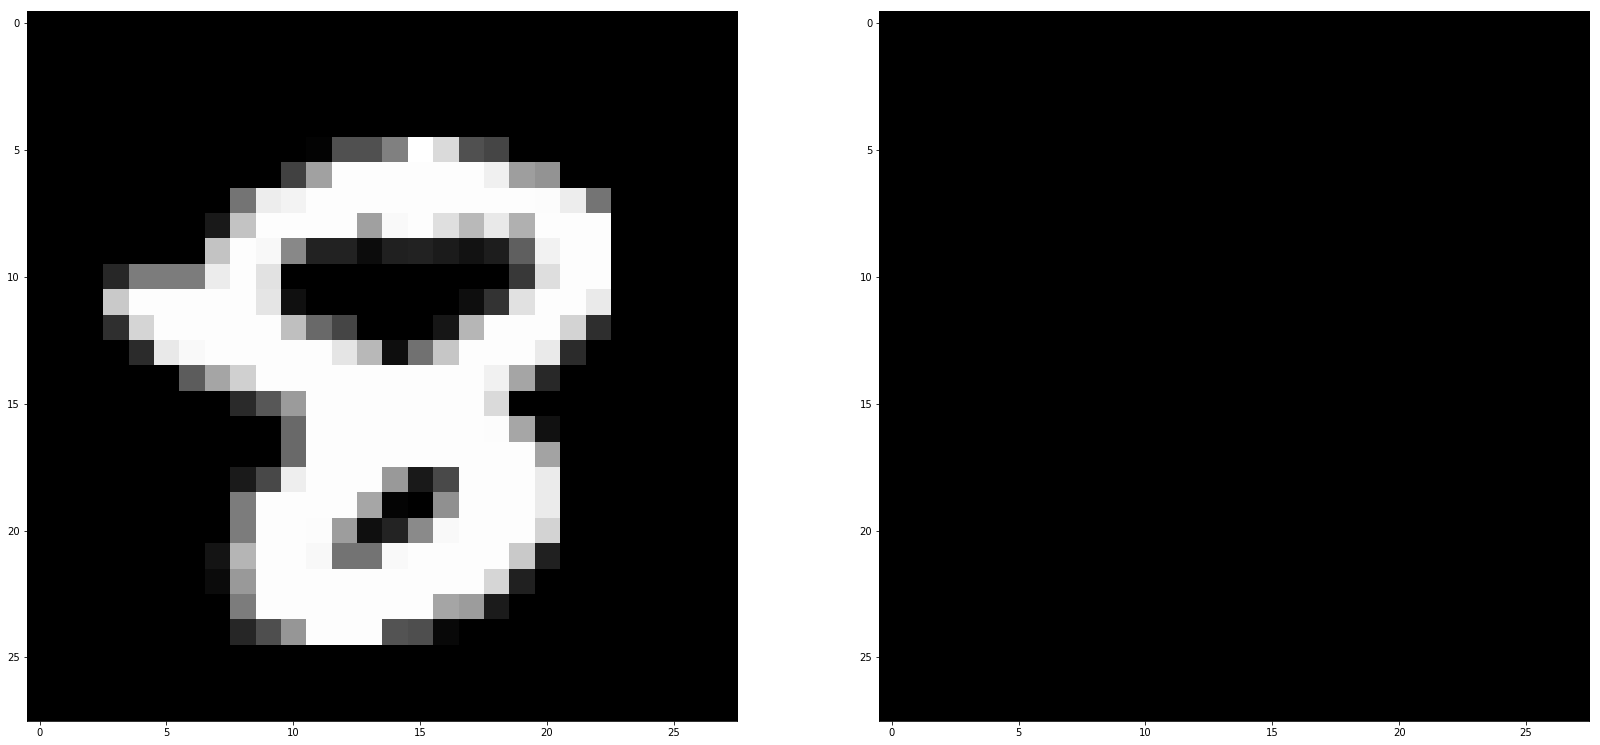

tensor(1659.8451, grad_fn=<MseLossBackward>)


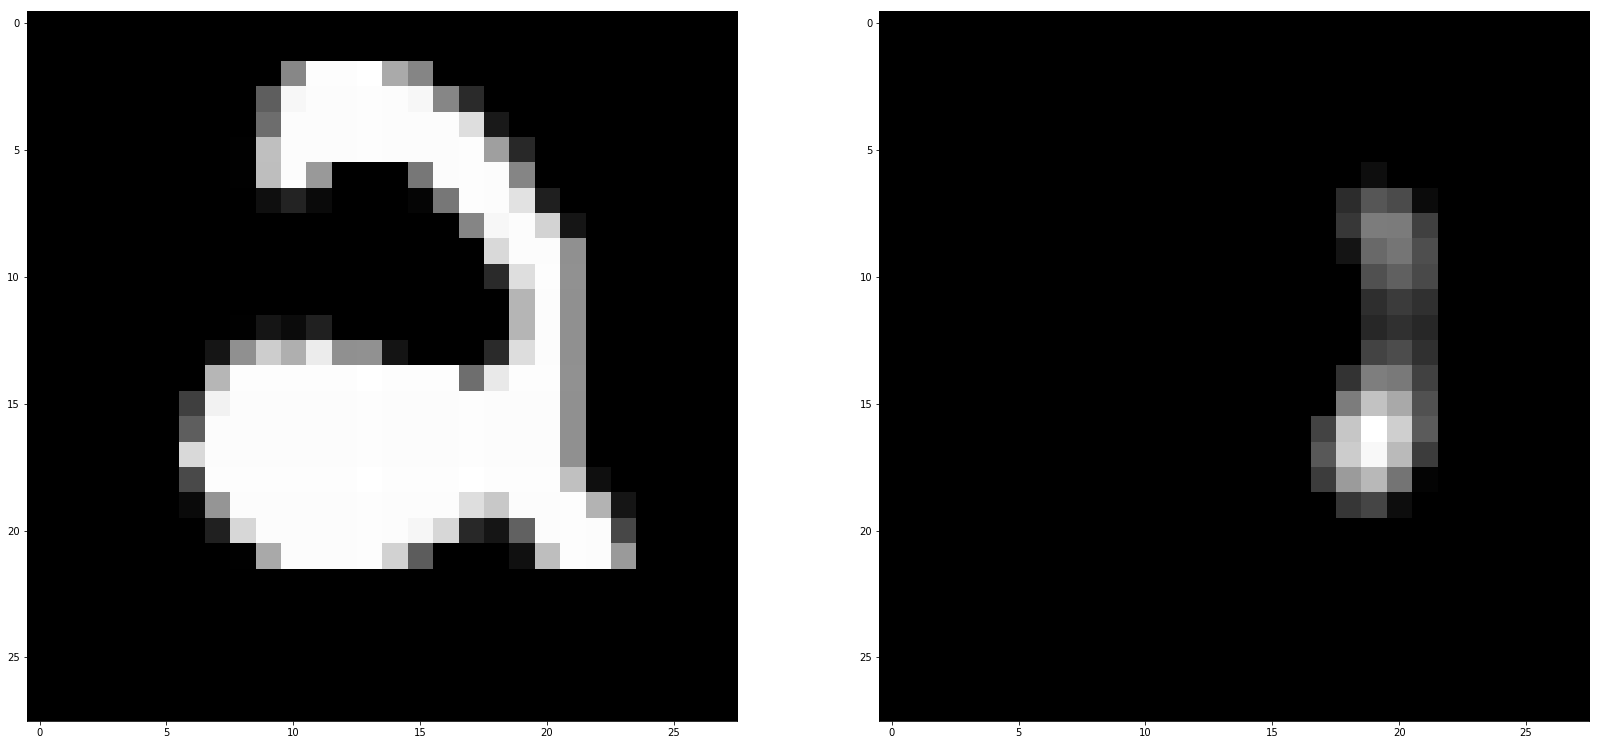

tensor(2921.0562, grad_fn=<MseLossBackward>)


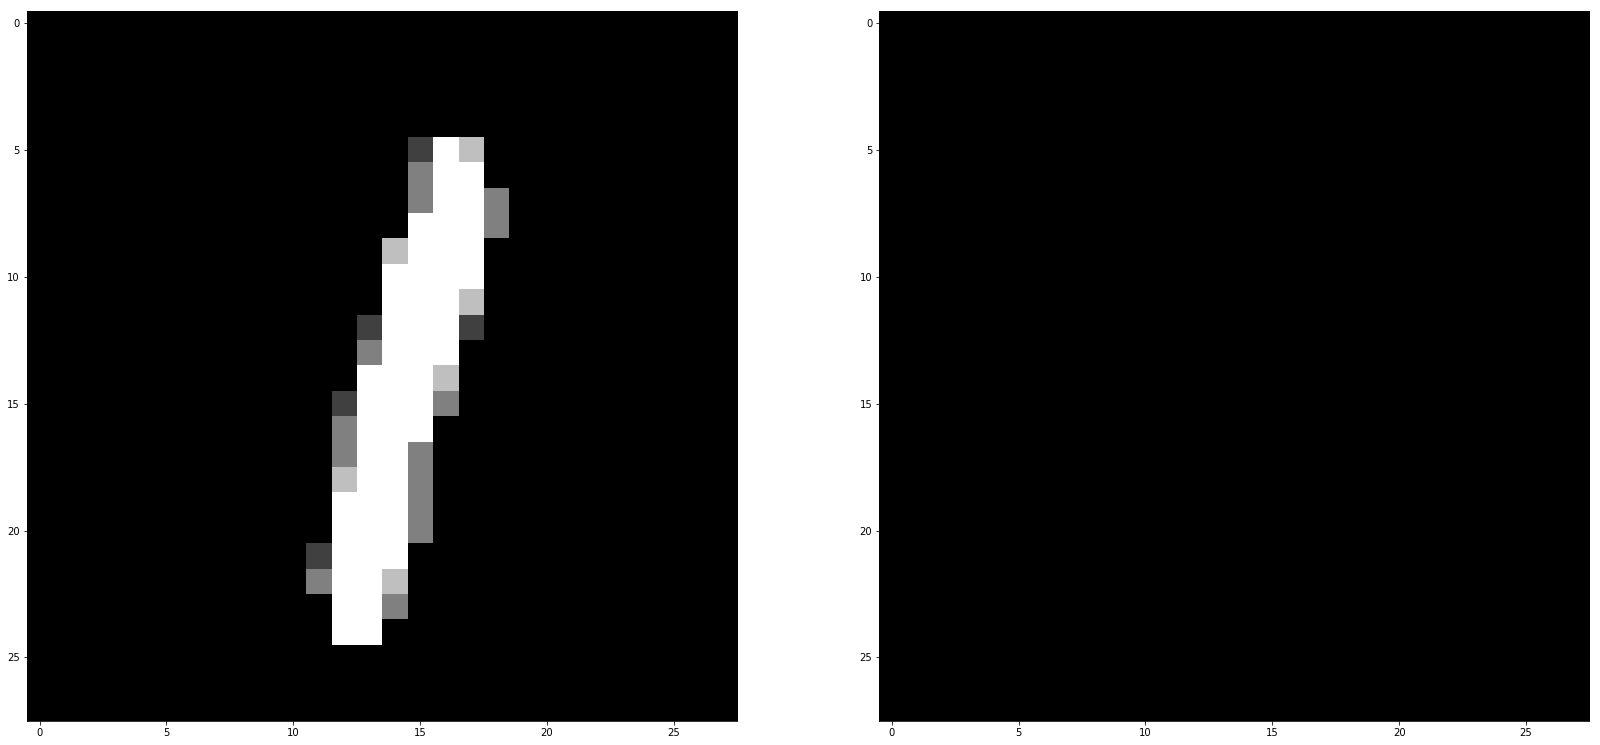

tensor(3396.5066, grad_fn=<MseLossBackward>)


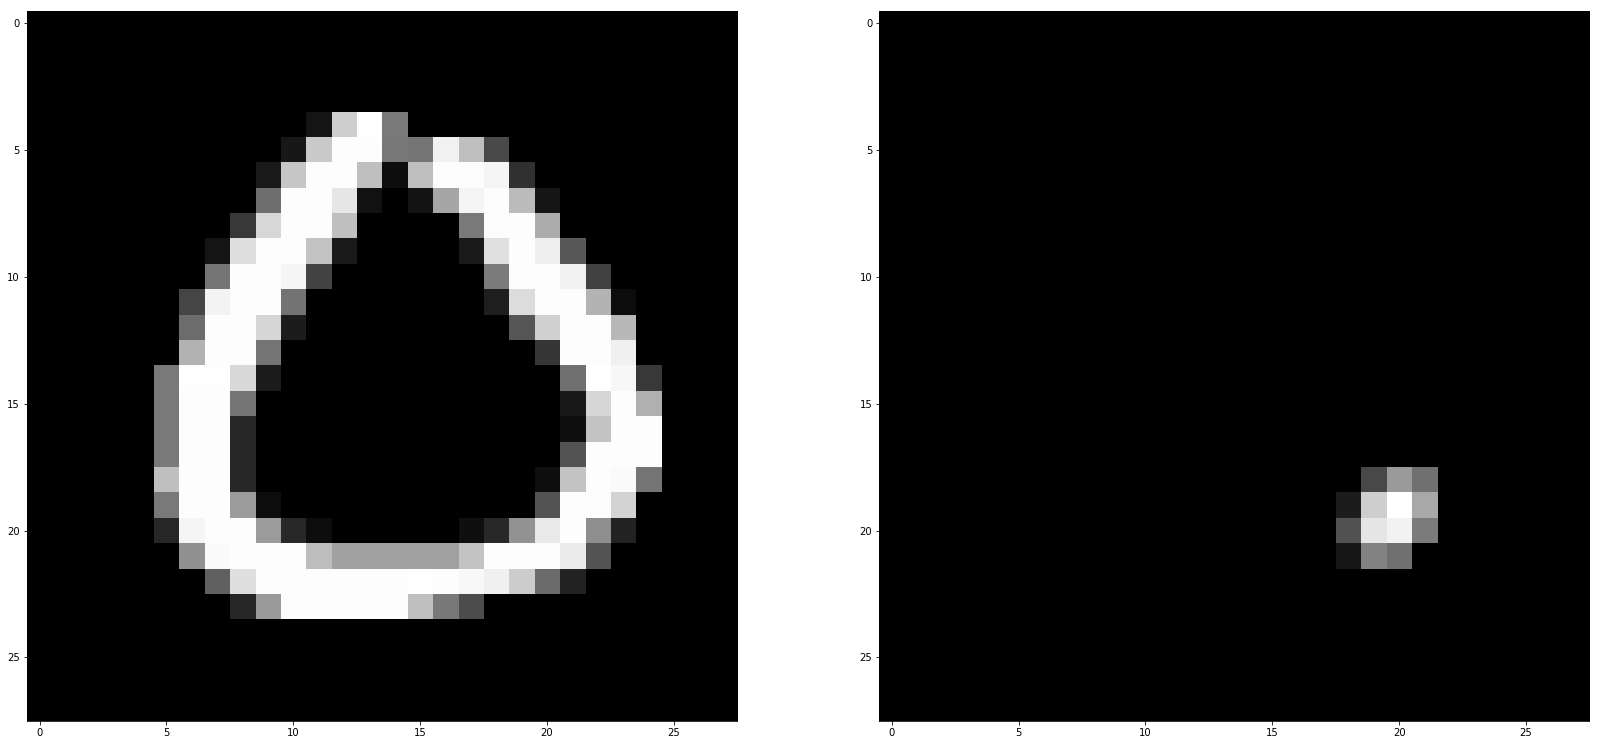

tensor(6574.9653, grad_fn=<MseLossBackward>)


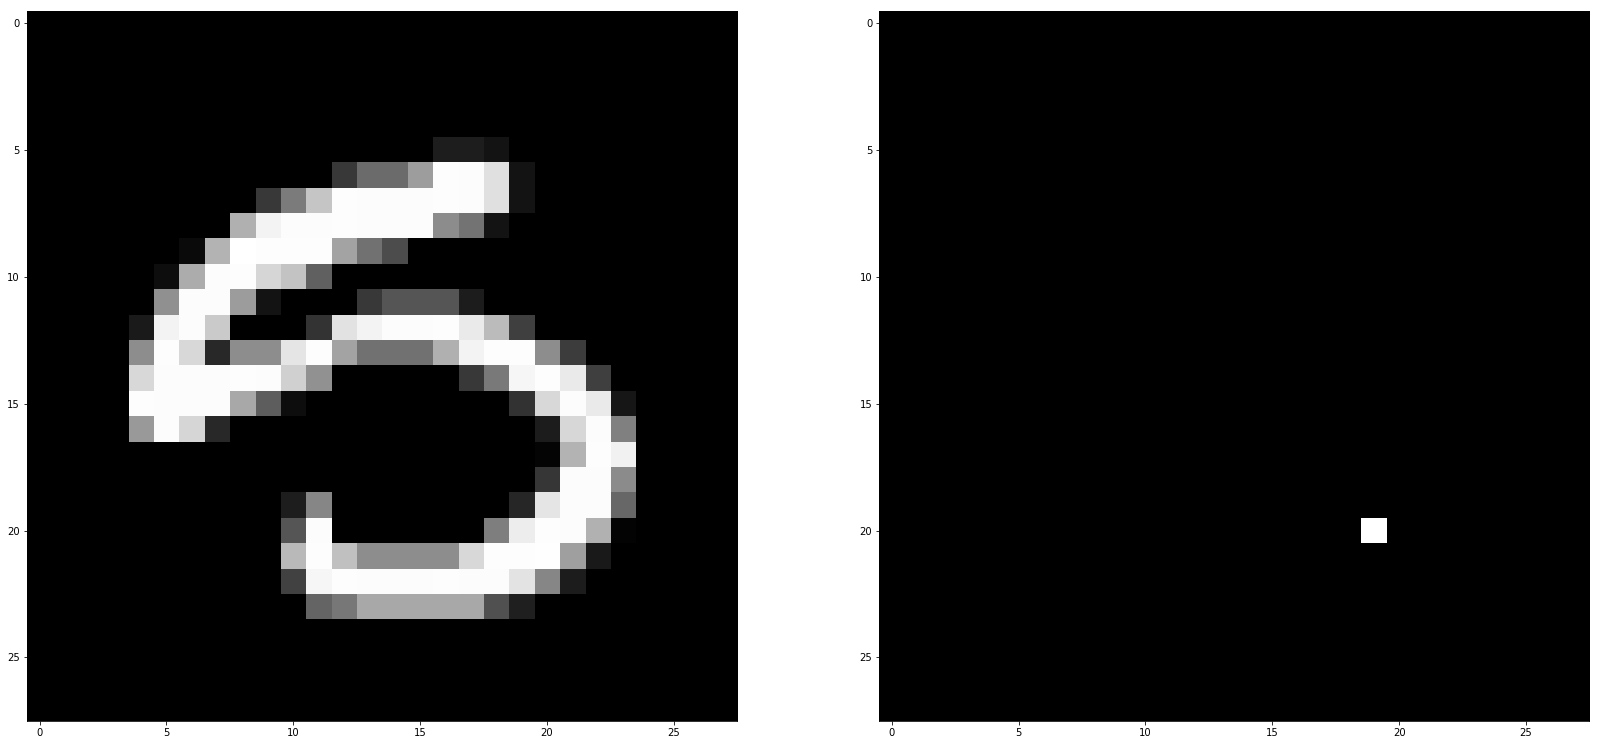

tensor(2948.2539, grad_fn=<MseLossBackward>)


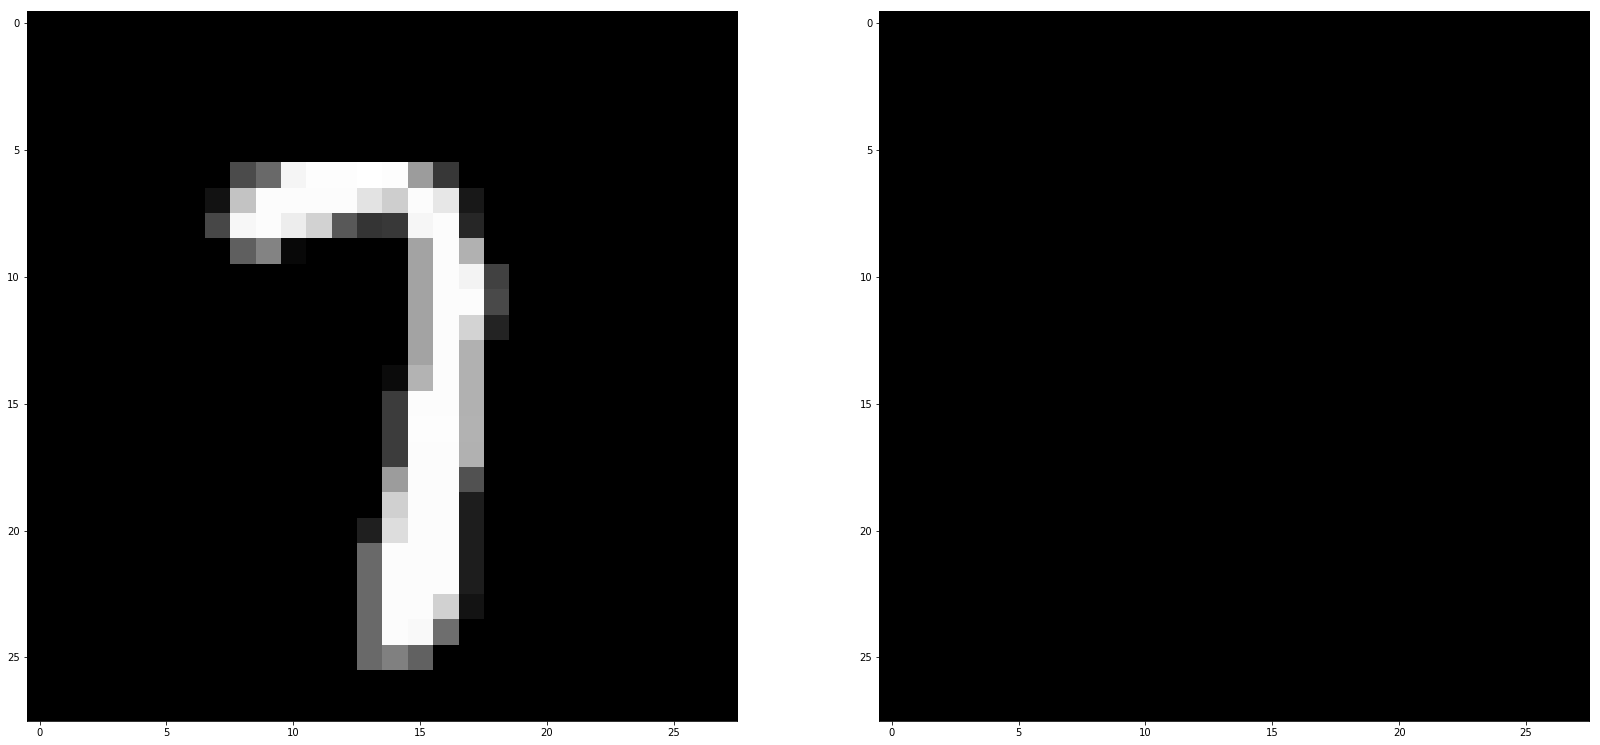

tensor(2560.9075, grad_fn=<MseLossBackward>)


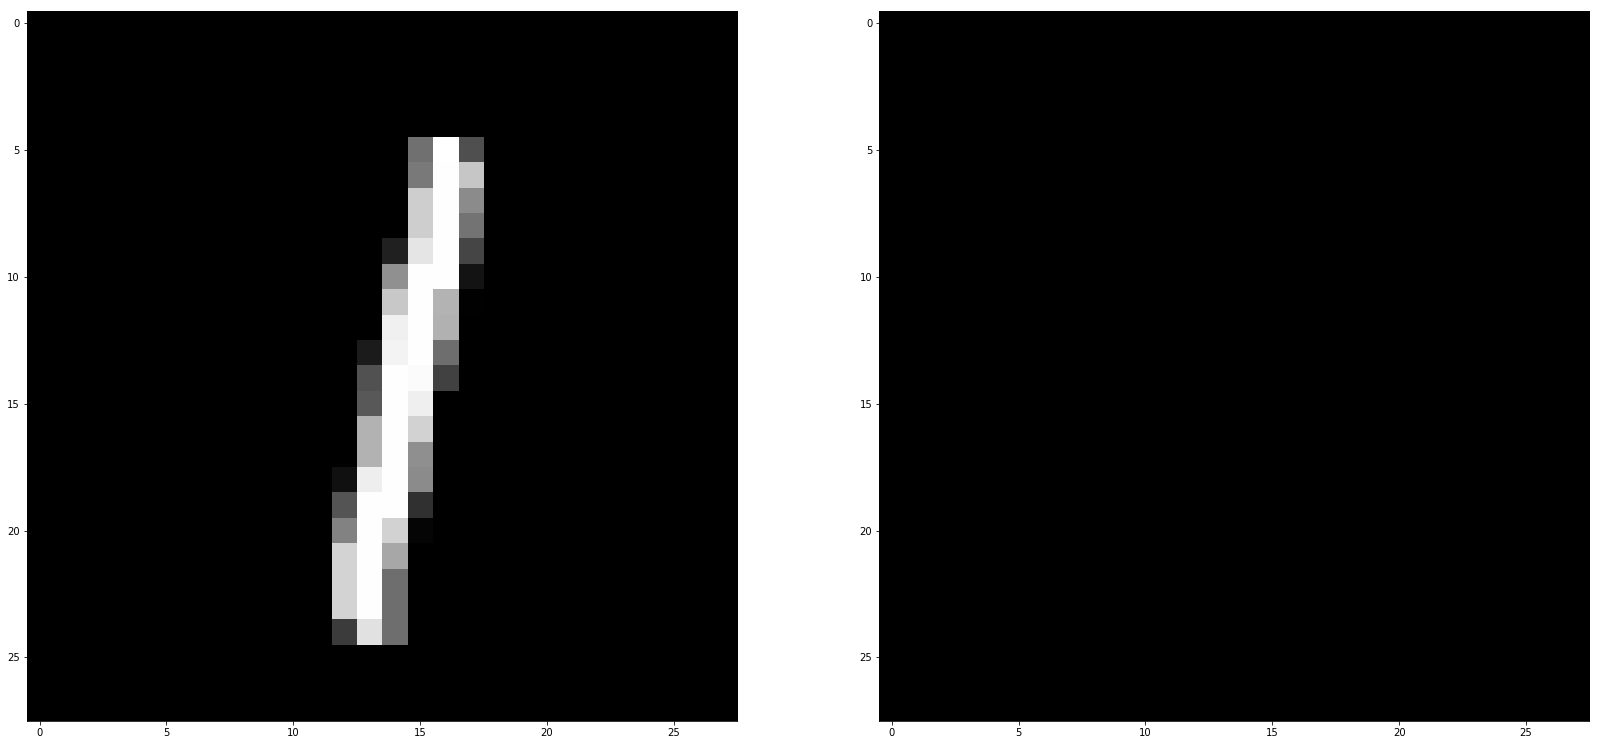

tensor(2433.4961, grad_fn=<MseLossBackward>)


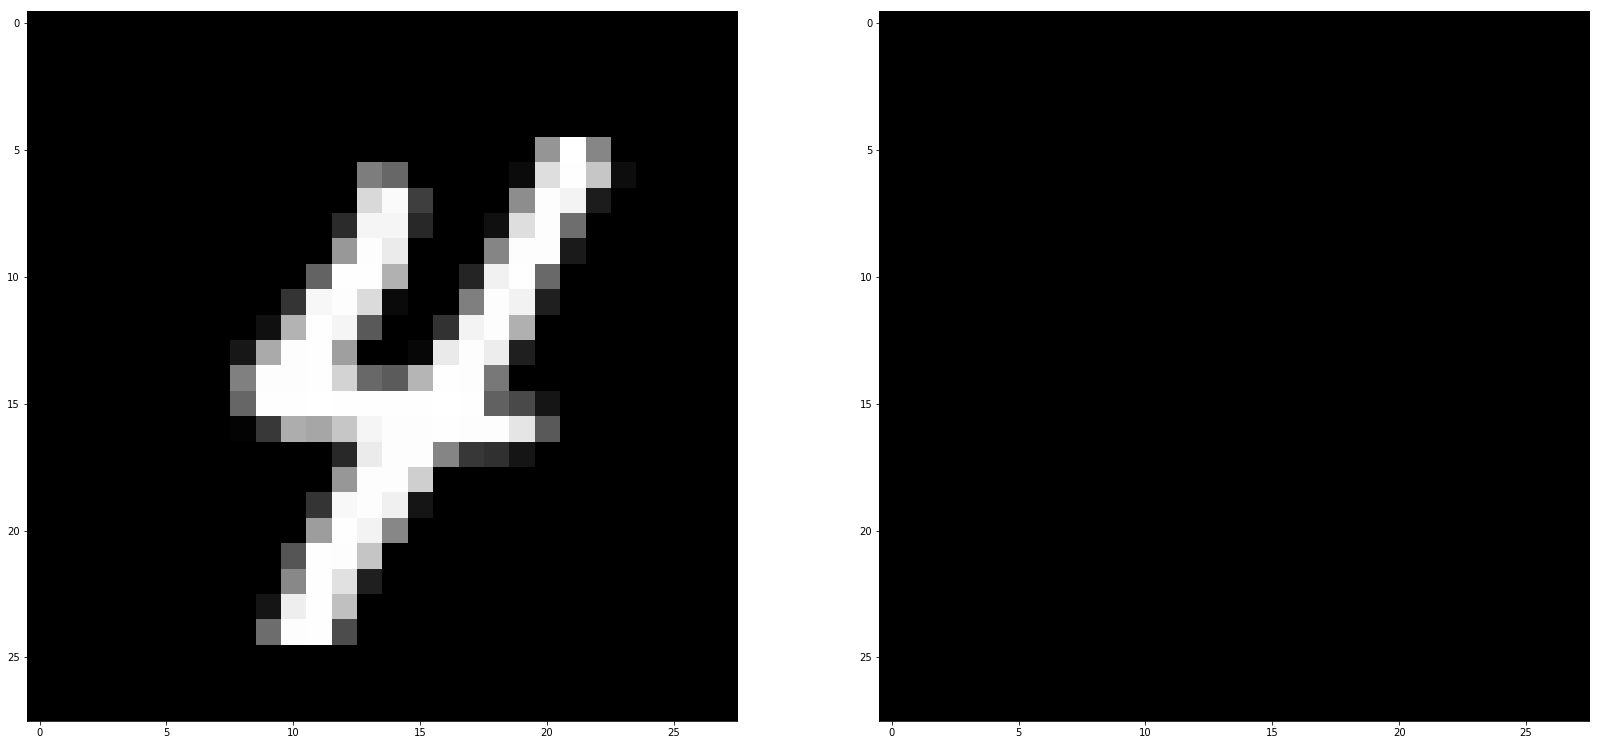

tensor(3863.7991, grad_fn=<MseLossBackward>)


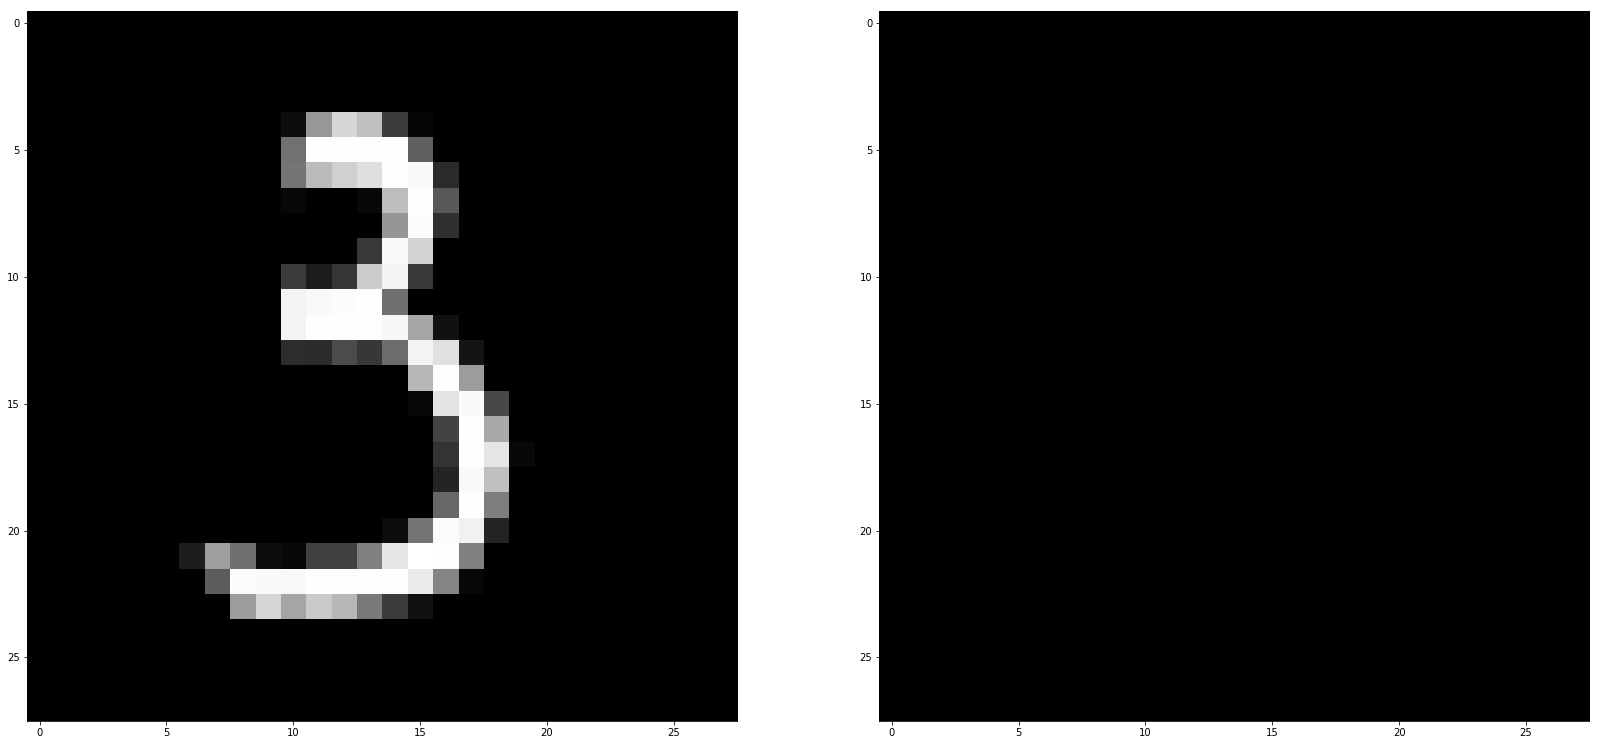

tensor(4033.0864, grad_fn=<MseLossBackward>)


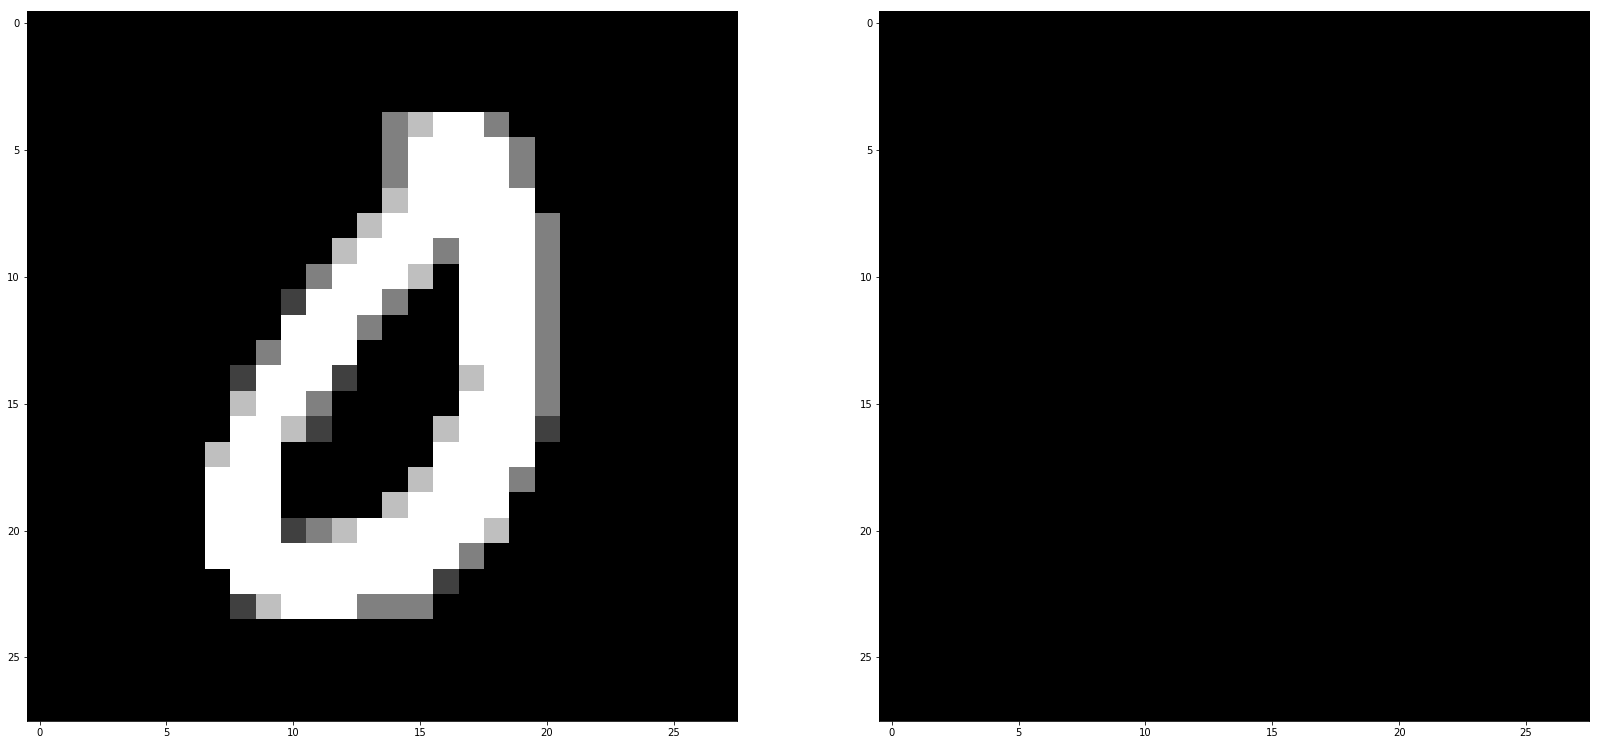

tensor(2399.3186, grad_fn=<MseLossBackward>)


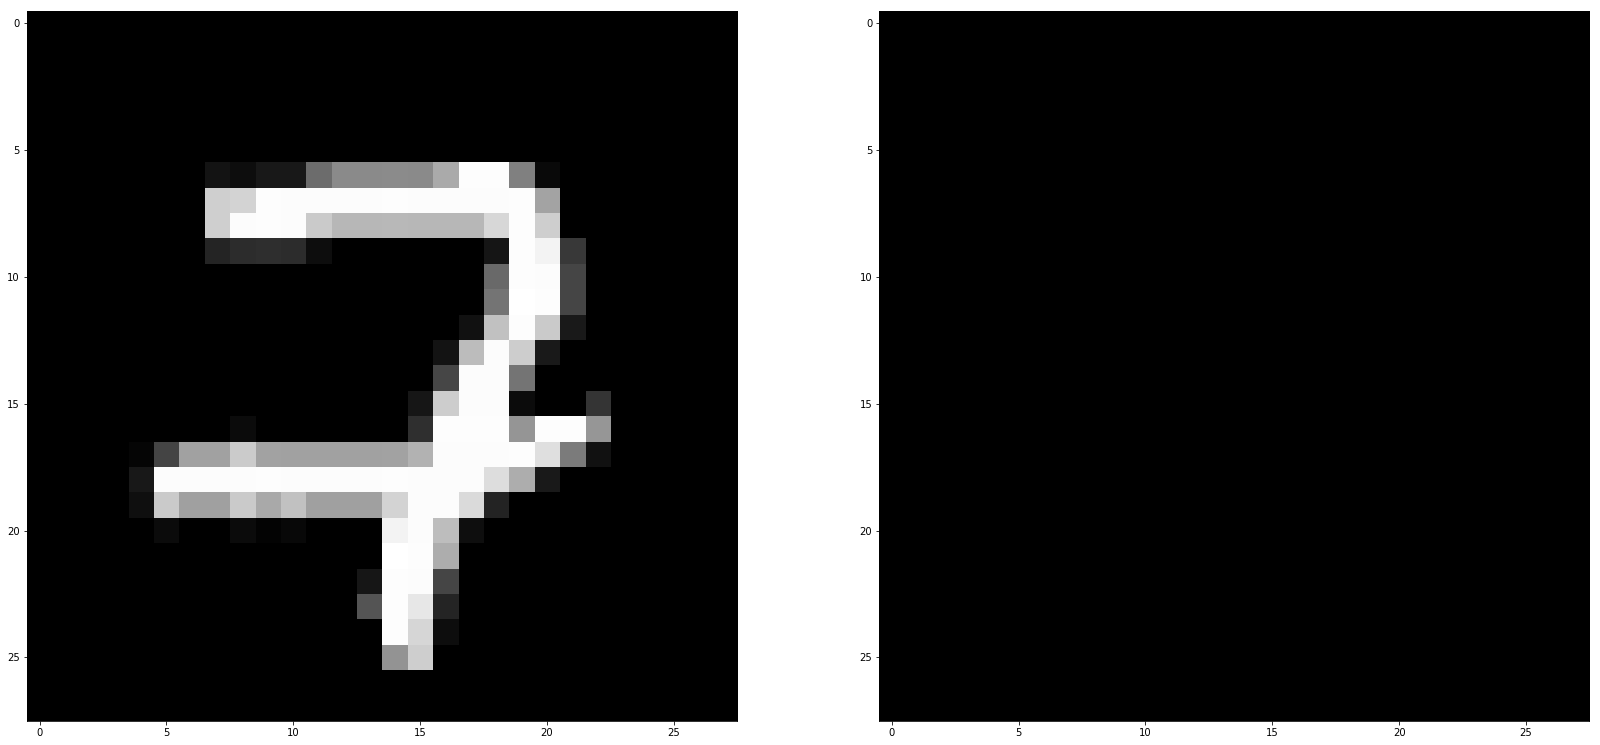

tensor(3036.0090, grad_fn=<MseLossBackward>)


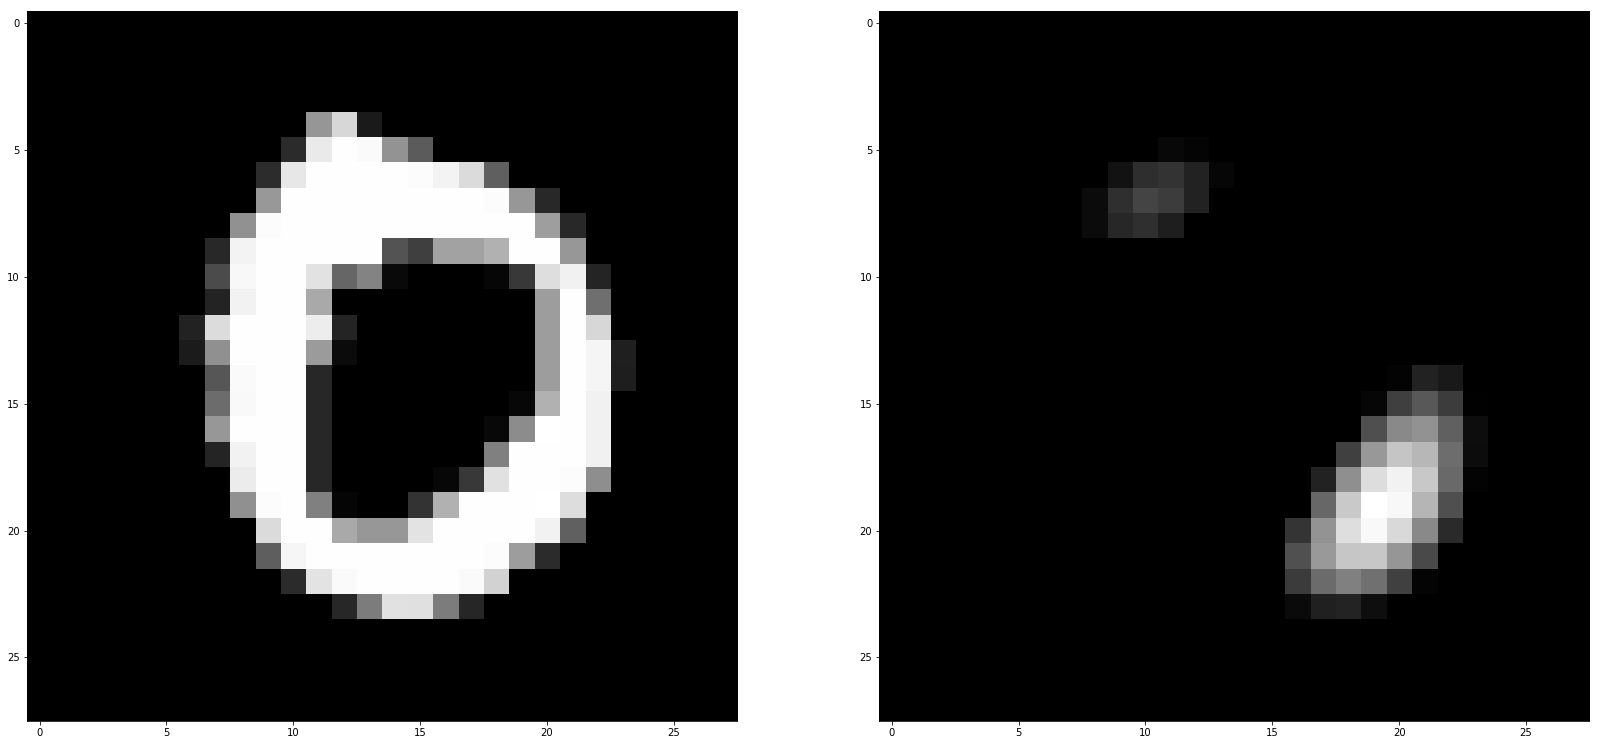

tensor(2785.7004, grad_fn=<MseLossBackward>)


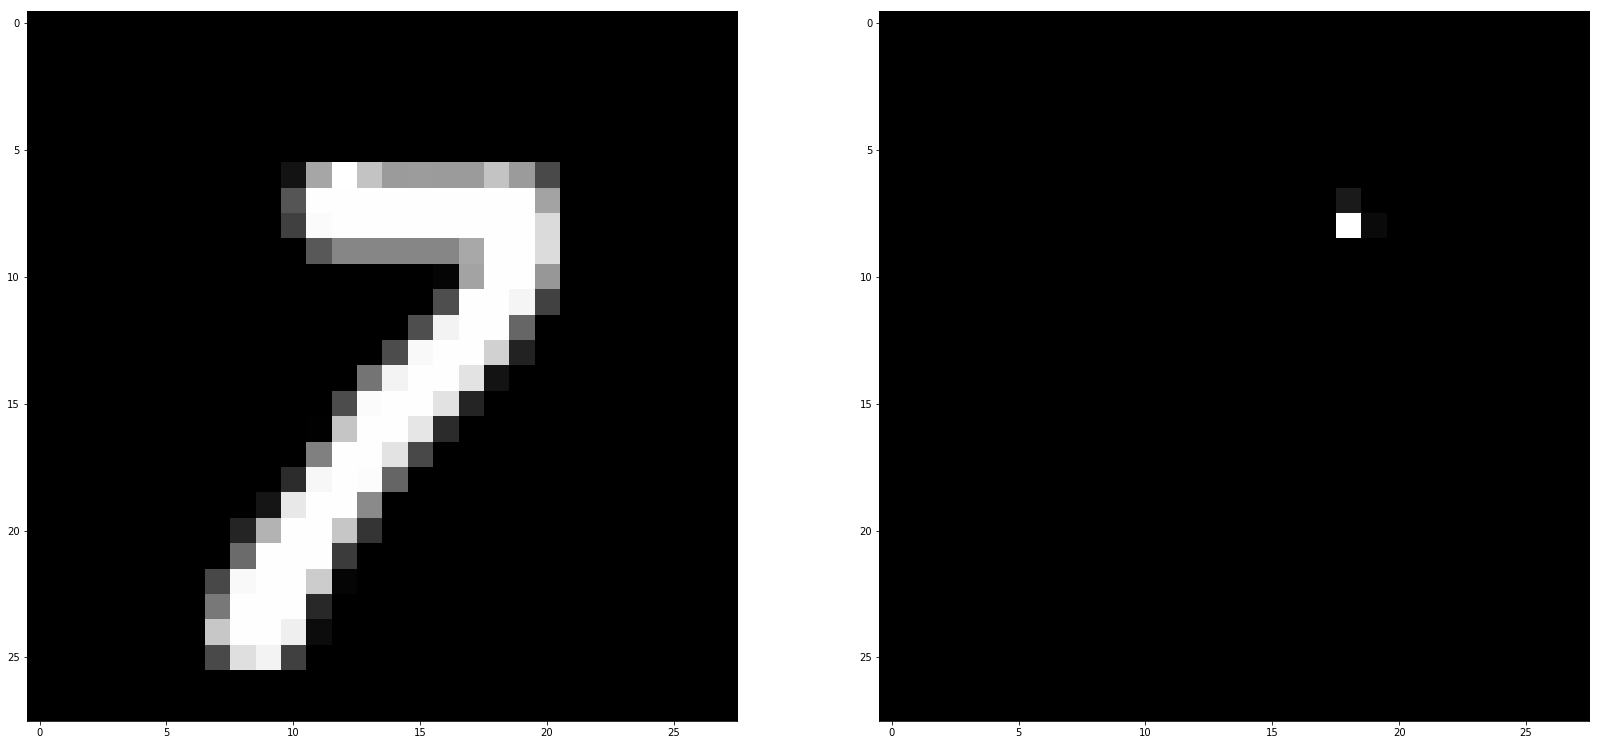

tensor(2421.9292, grad_fn=<MseLossBackward>)


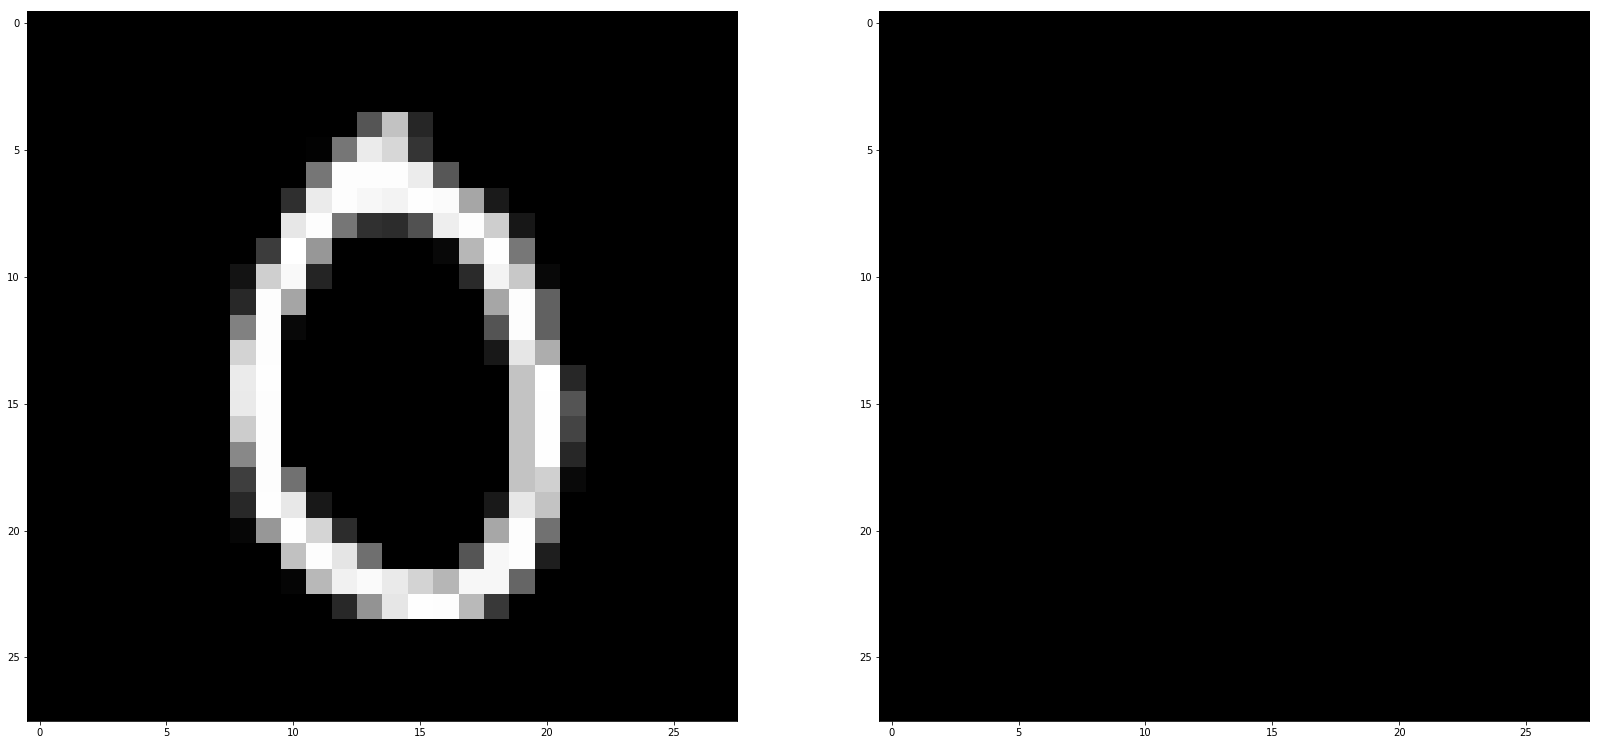

tensor(4245.0186, grad_fn=<MseLossBackward>)


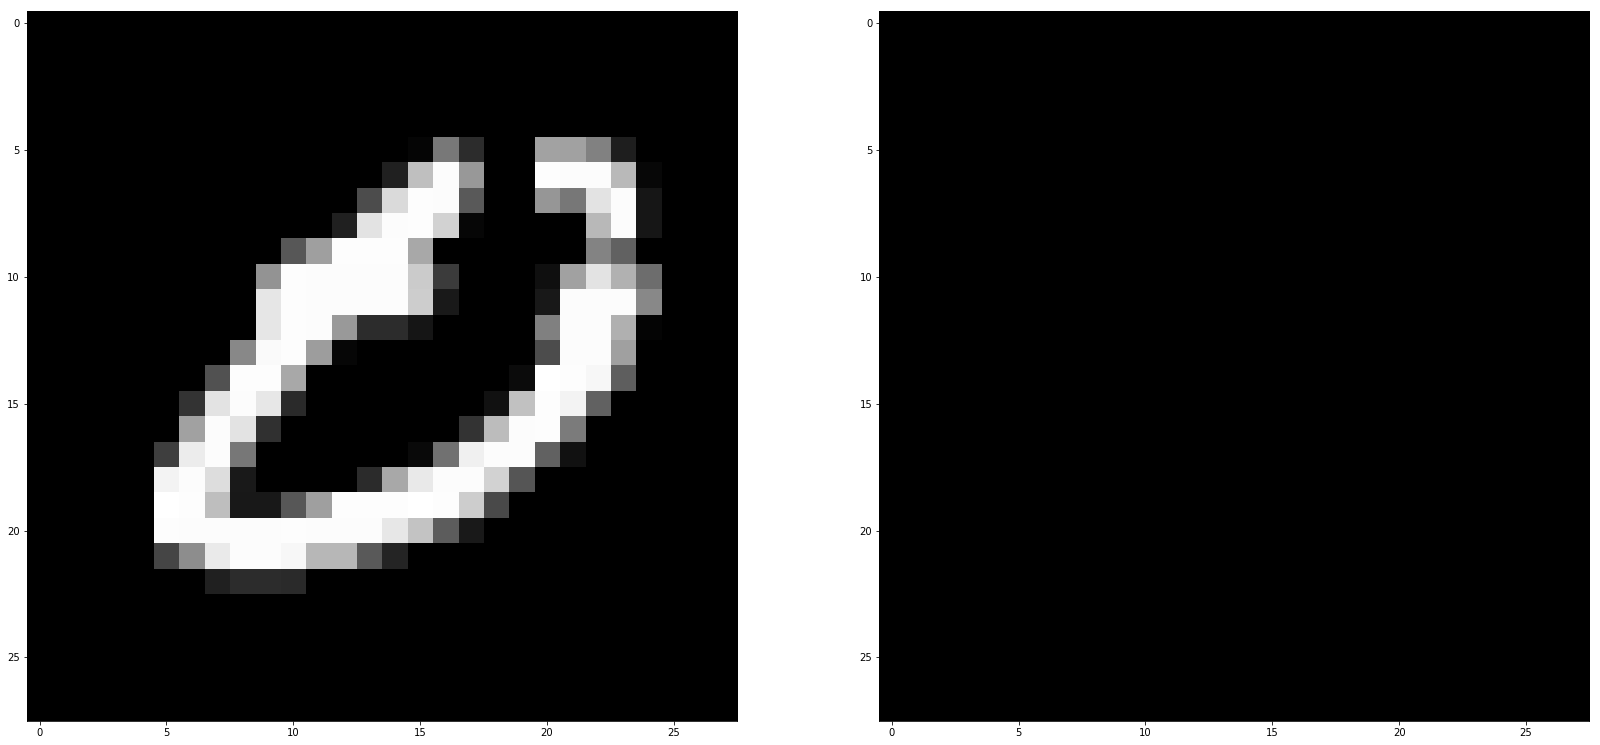

tensor(3502.7600, grad_fn=<MseLossBackward>)


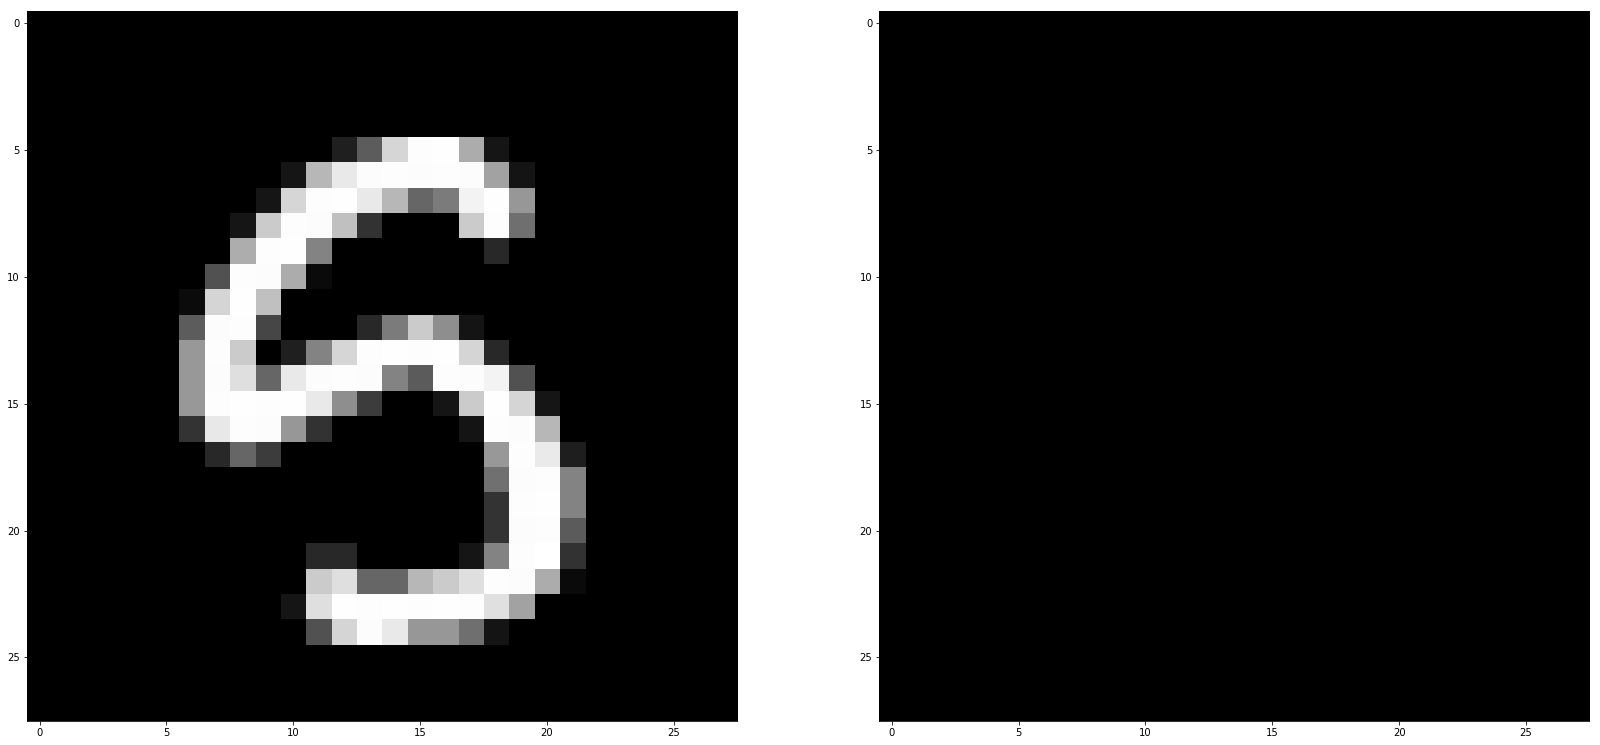

tensor(2702.9729, grad_fn=<MseLossBackward>)


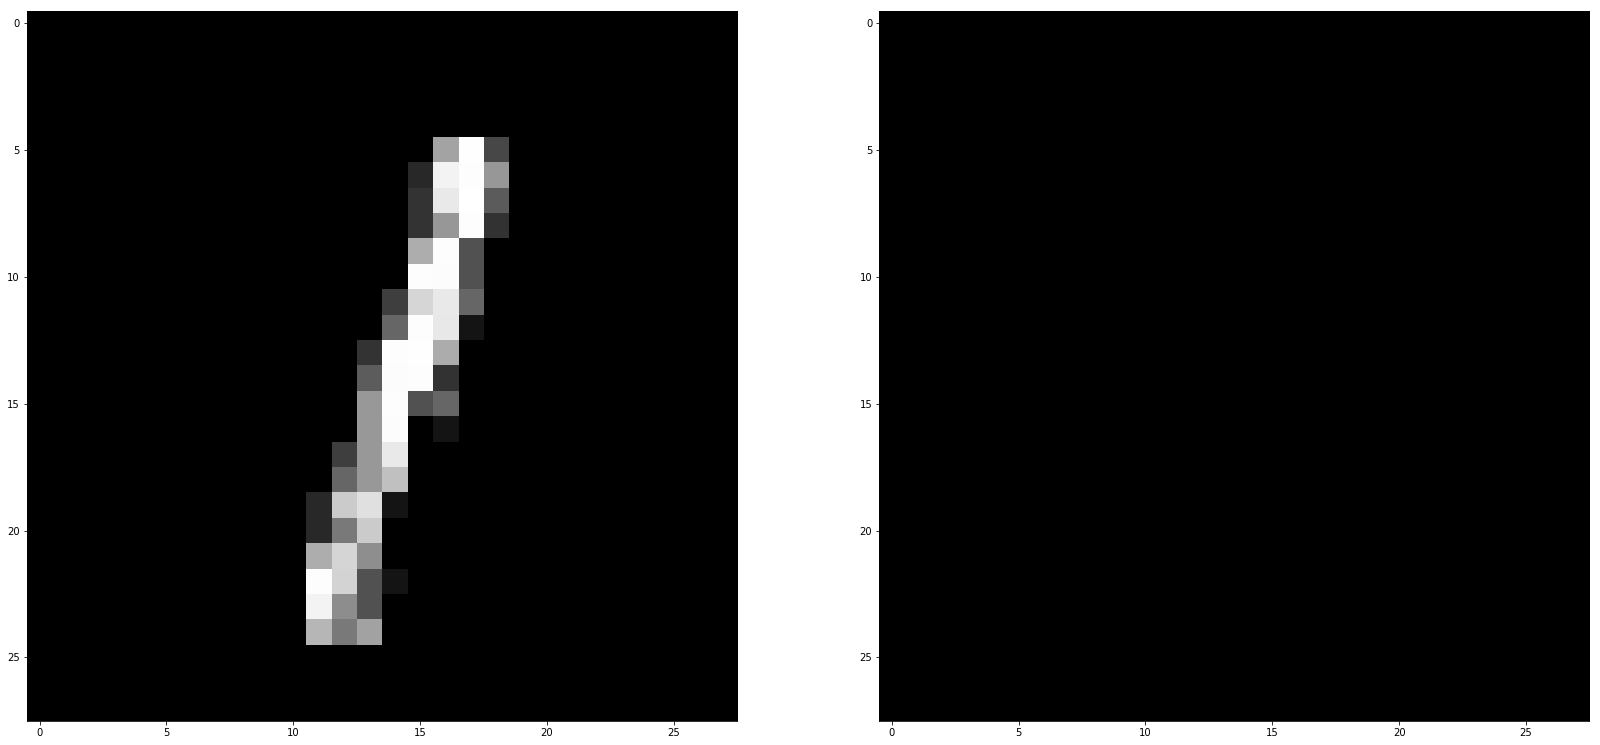

tensor(1639.4343, grad_fn=<MseLossBackward>)


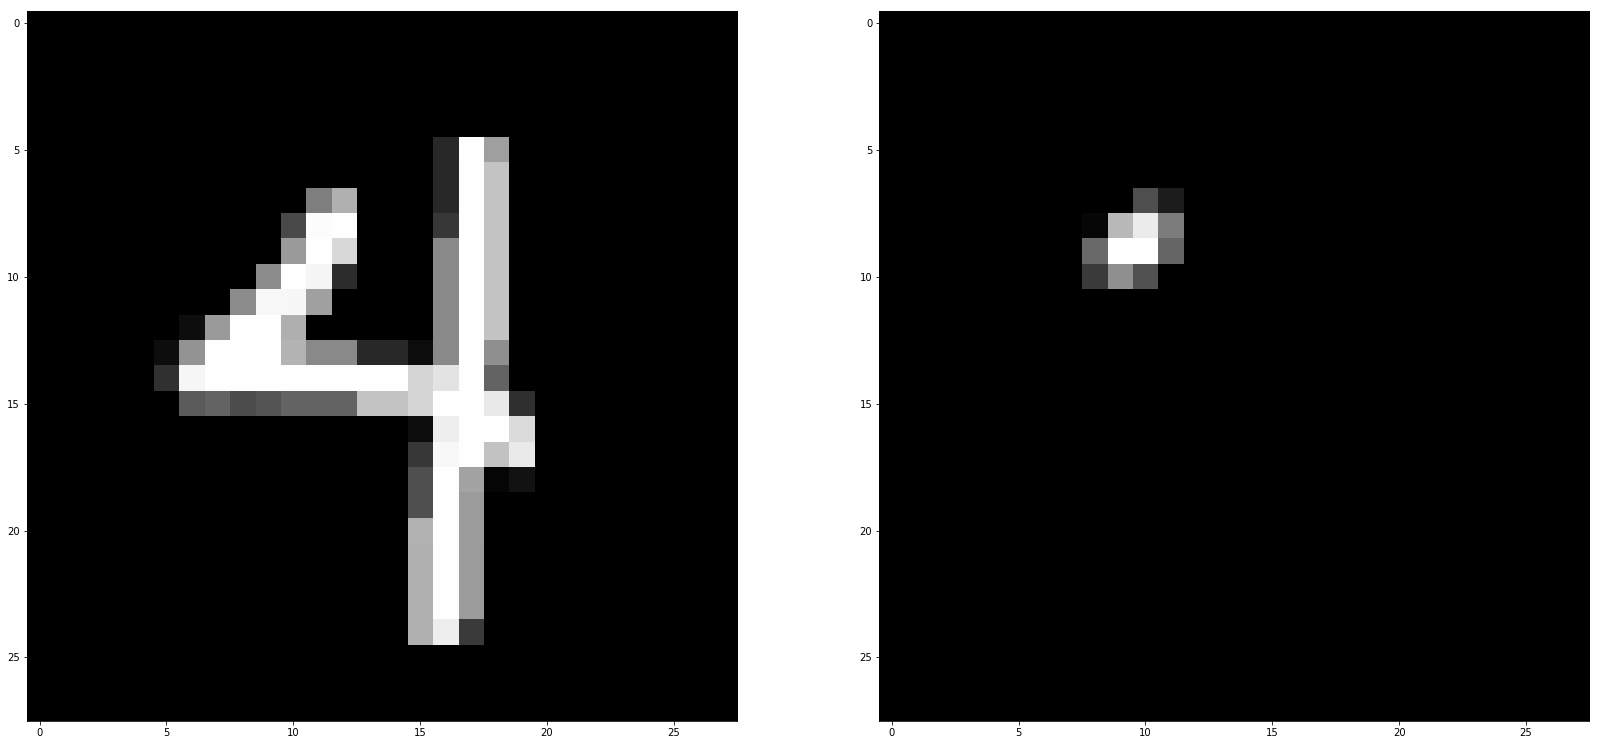

tensor(2947.3630, grad_fn=<MseLossBackward>)


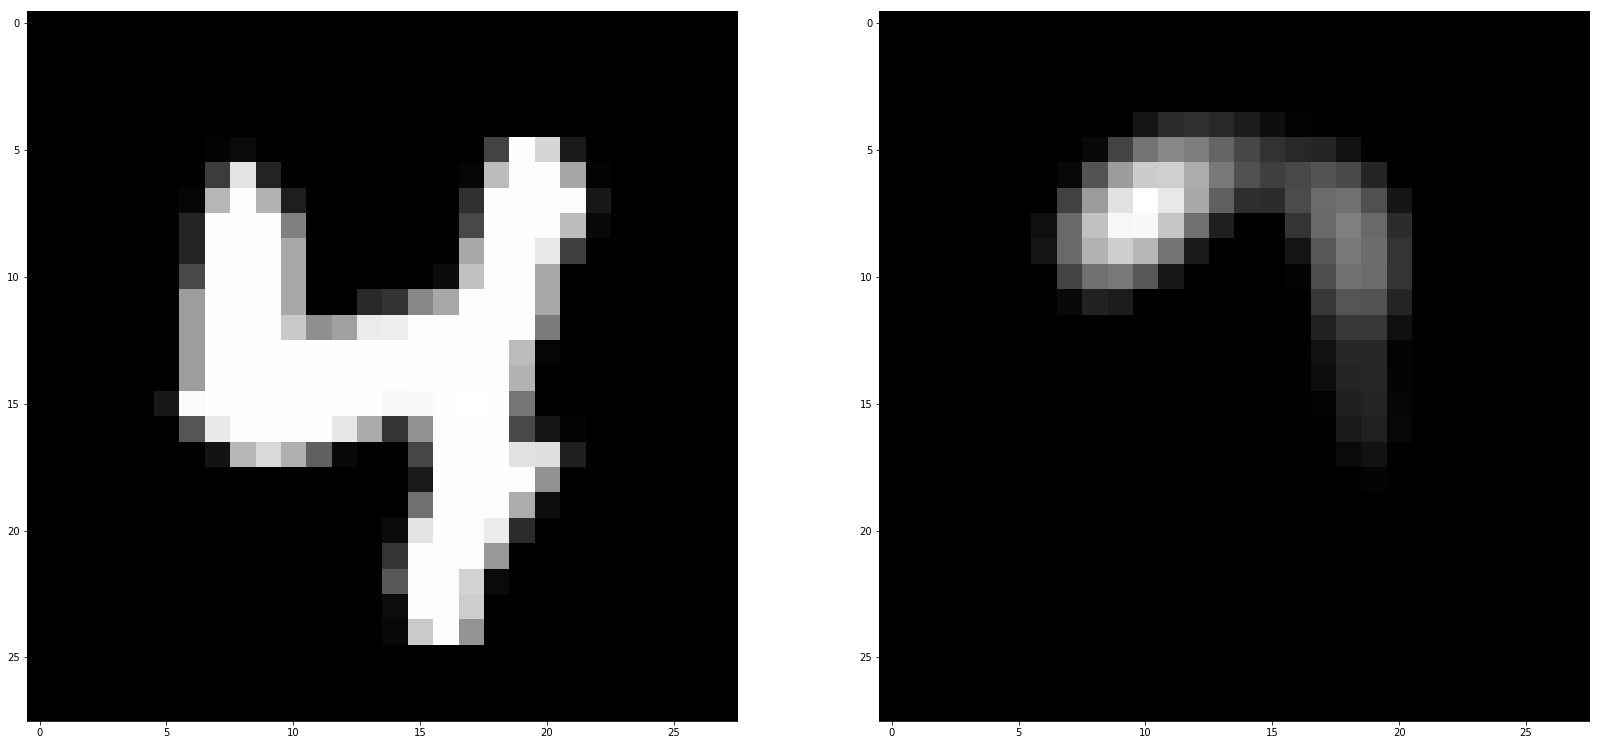

tensor(1523.8053, grad_fn=<MseLossBackward>)


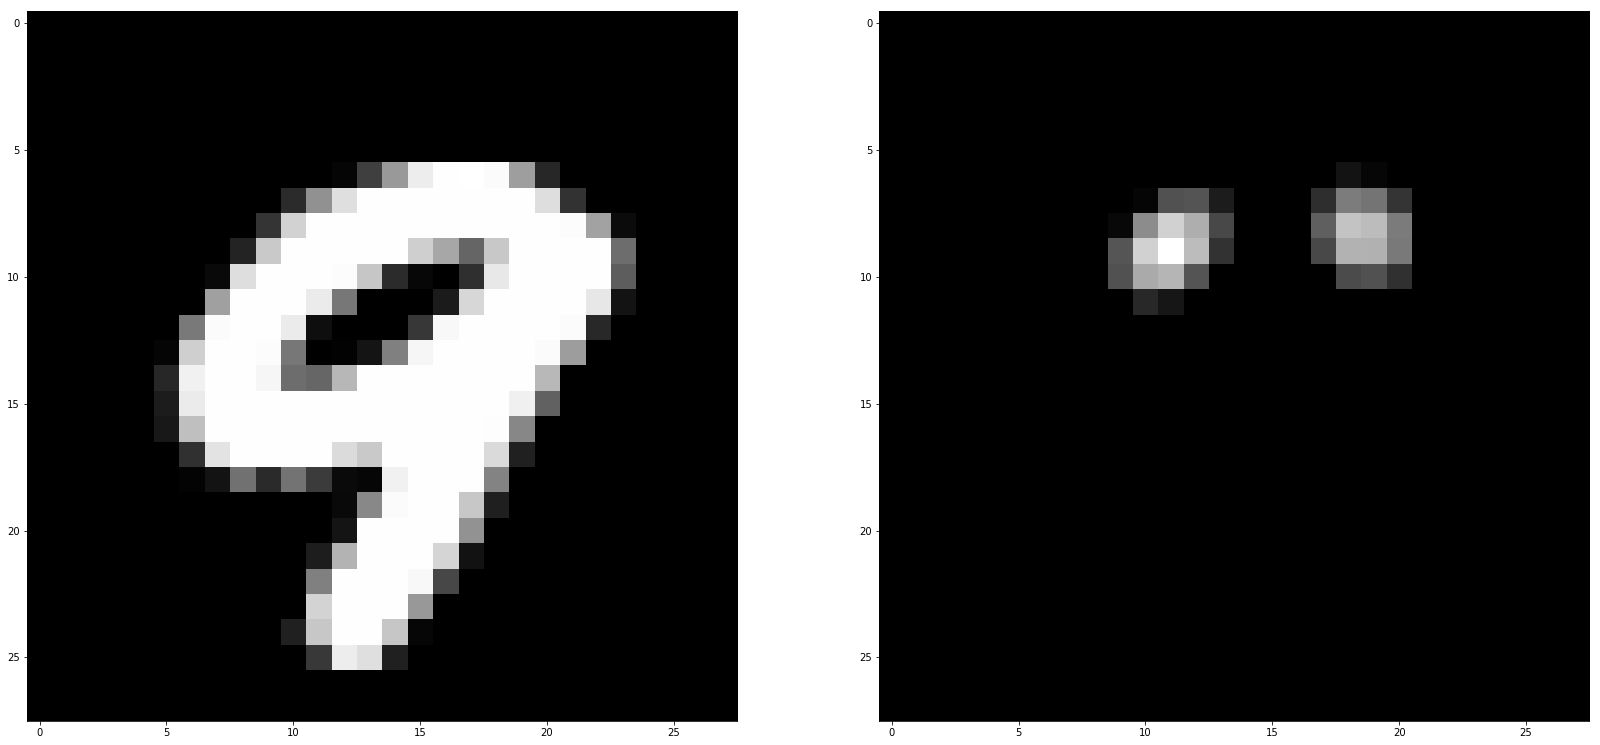

tensor(5833.1465, grad_fn=<MseLossBackward>)


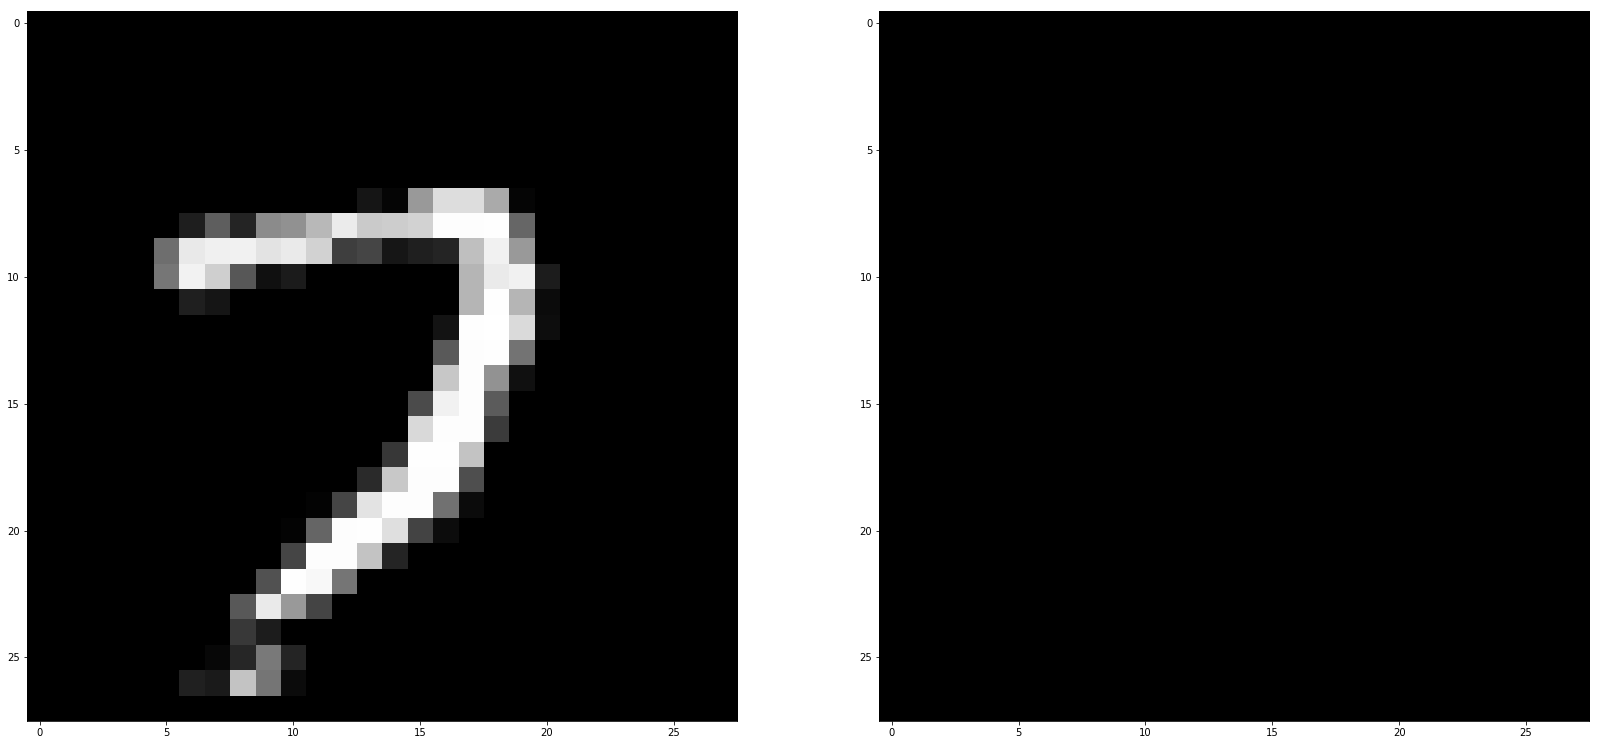

tensor(4165.9868, grad_fn=<MseLossBackward>)


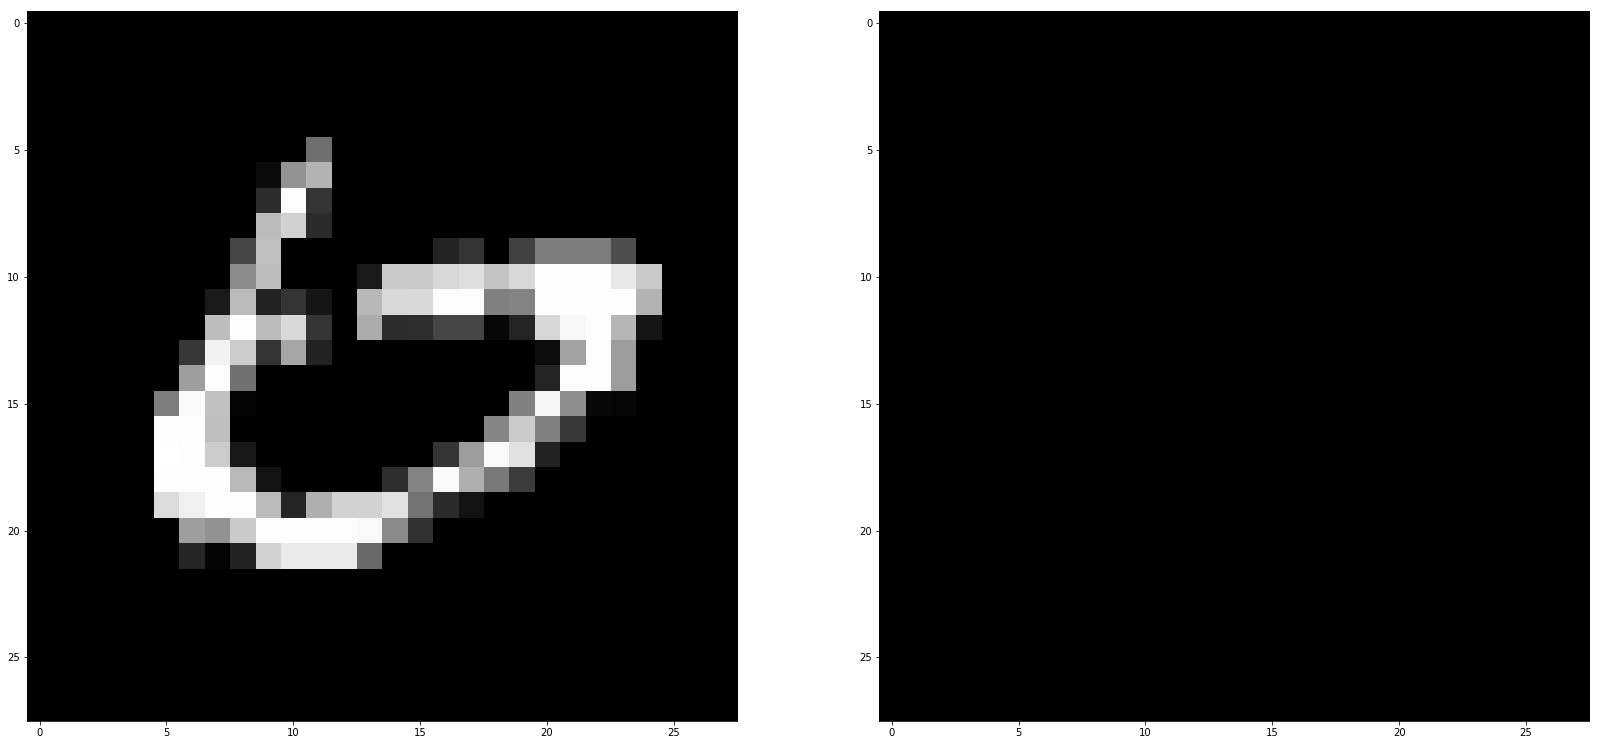

tensor(2573.5308, grad_fn=<MseLossBackward>)


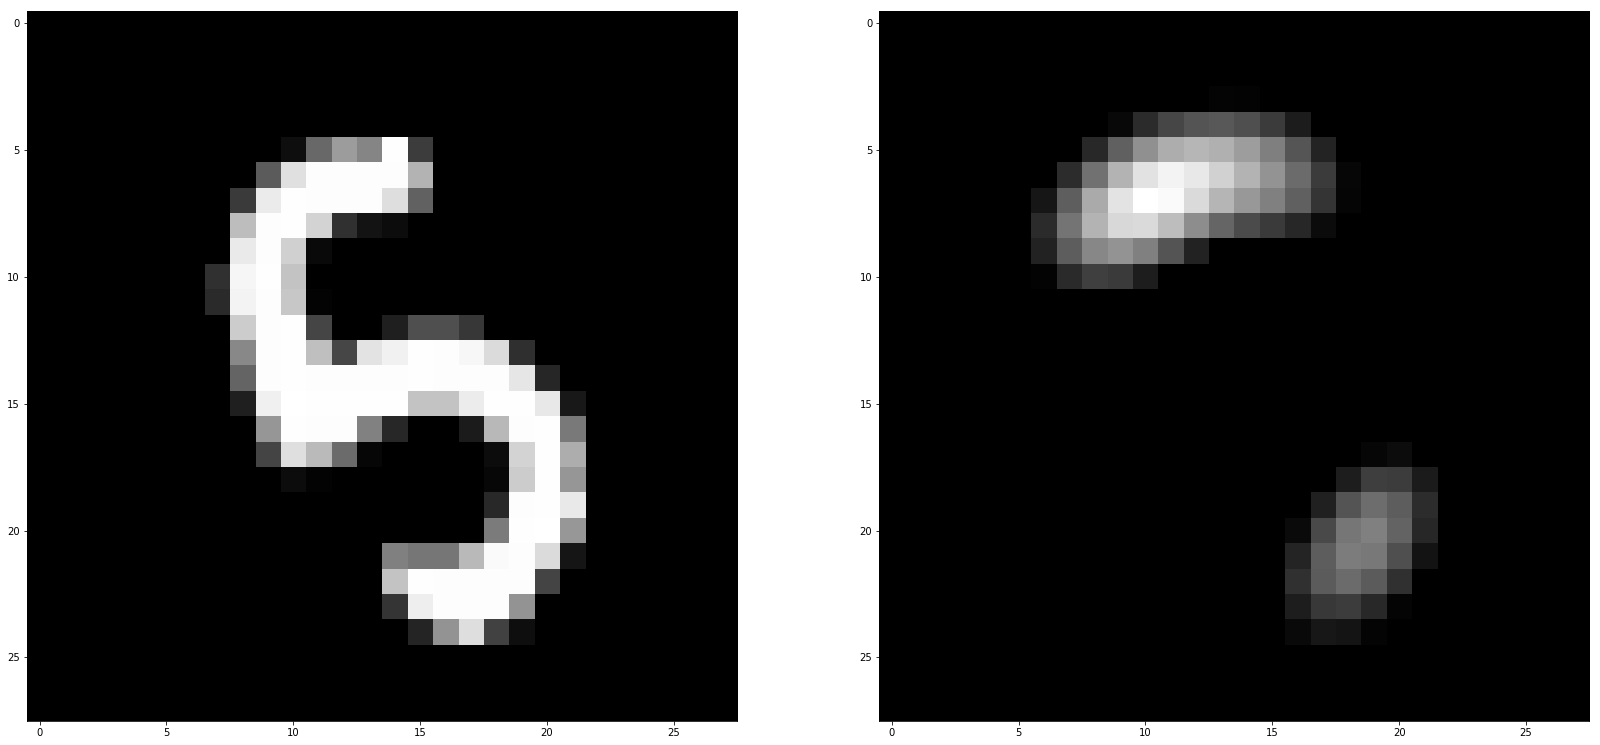

tensor(4861.6978, grad_fn=<MseLossBackward>)


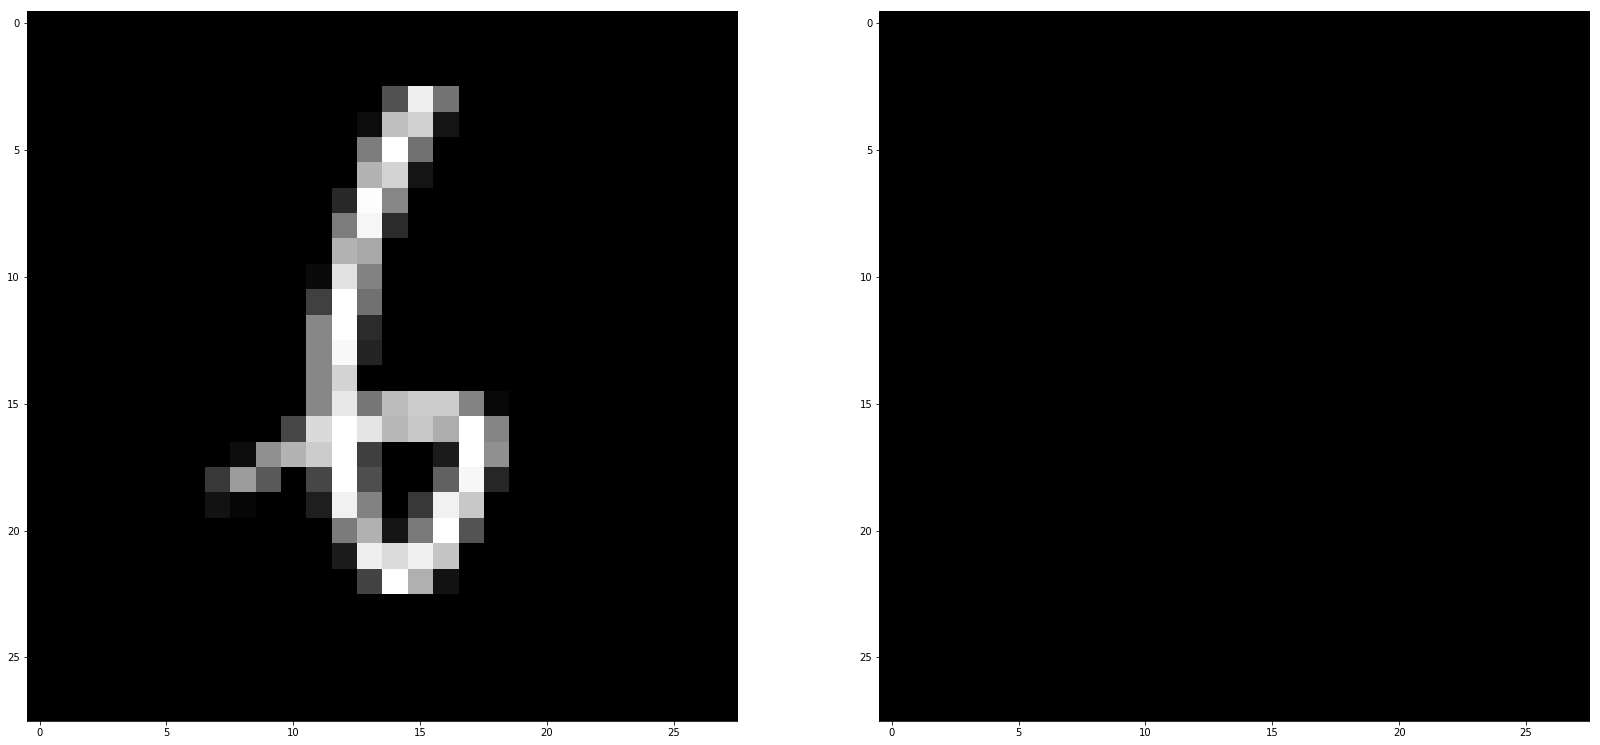

tensor(3917.1389, grad_fn=<MseLossBackward>)


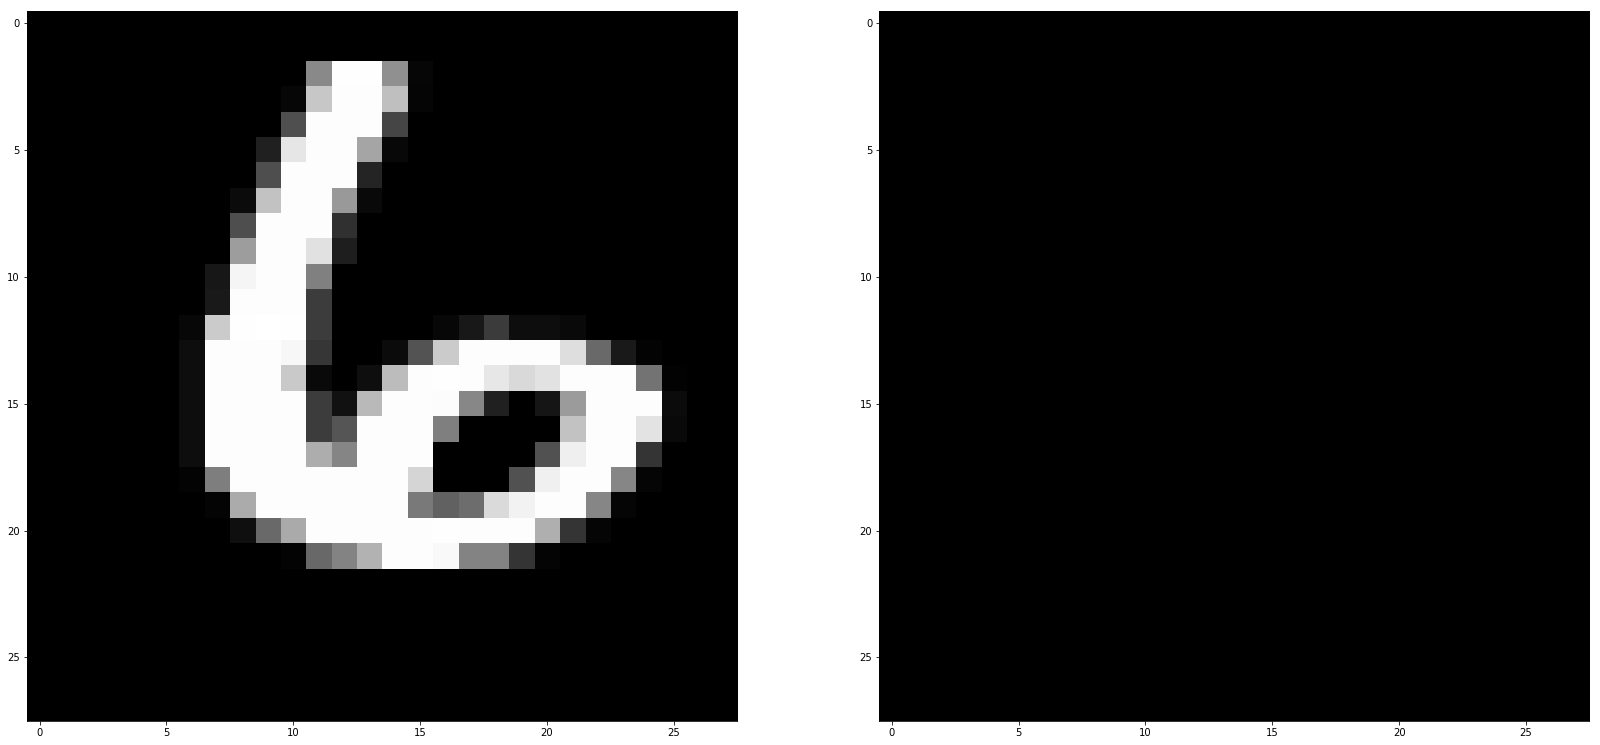

tensor(2928.9802, grad_fn=<MseLossBackward>)


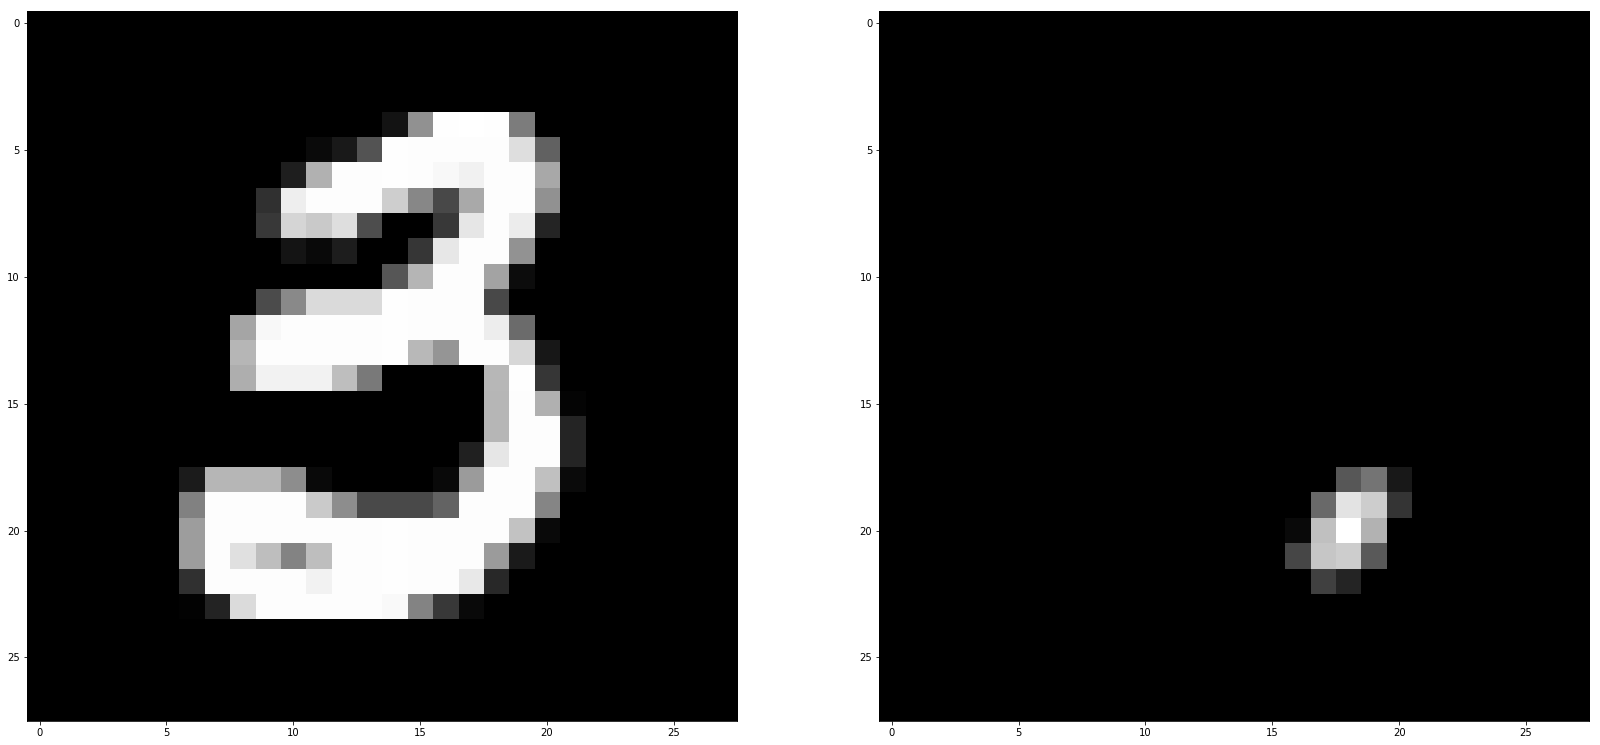

tensor(3241.3047, grad_fn=<MseLossBackward>)


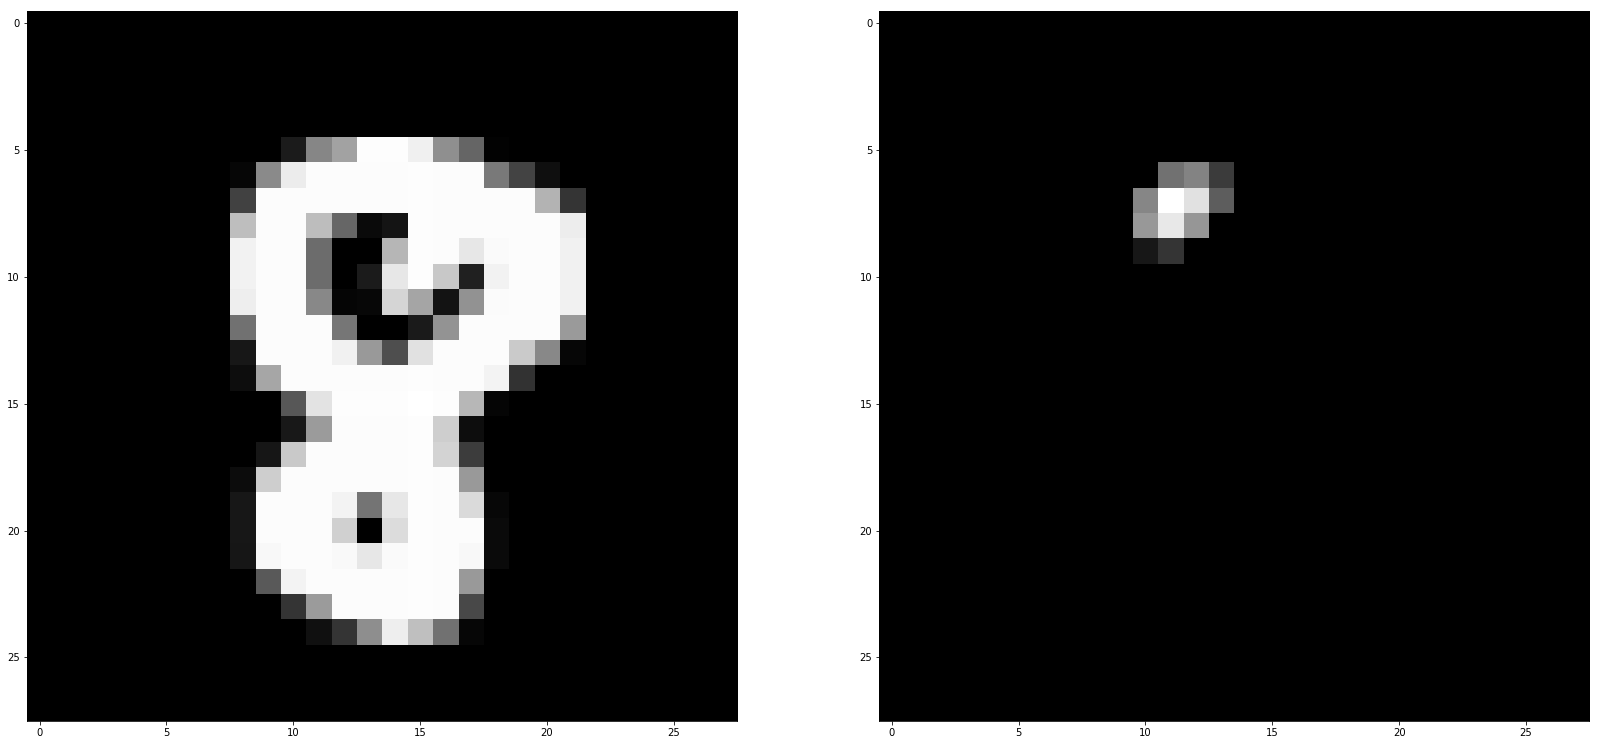

tensor(2605.1091, grad_fn=<MseLossBackward>)


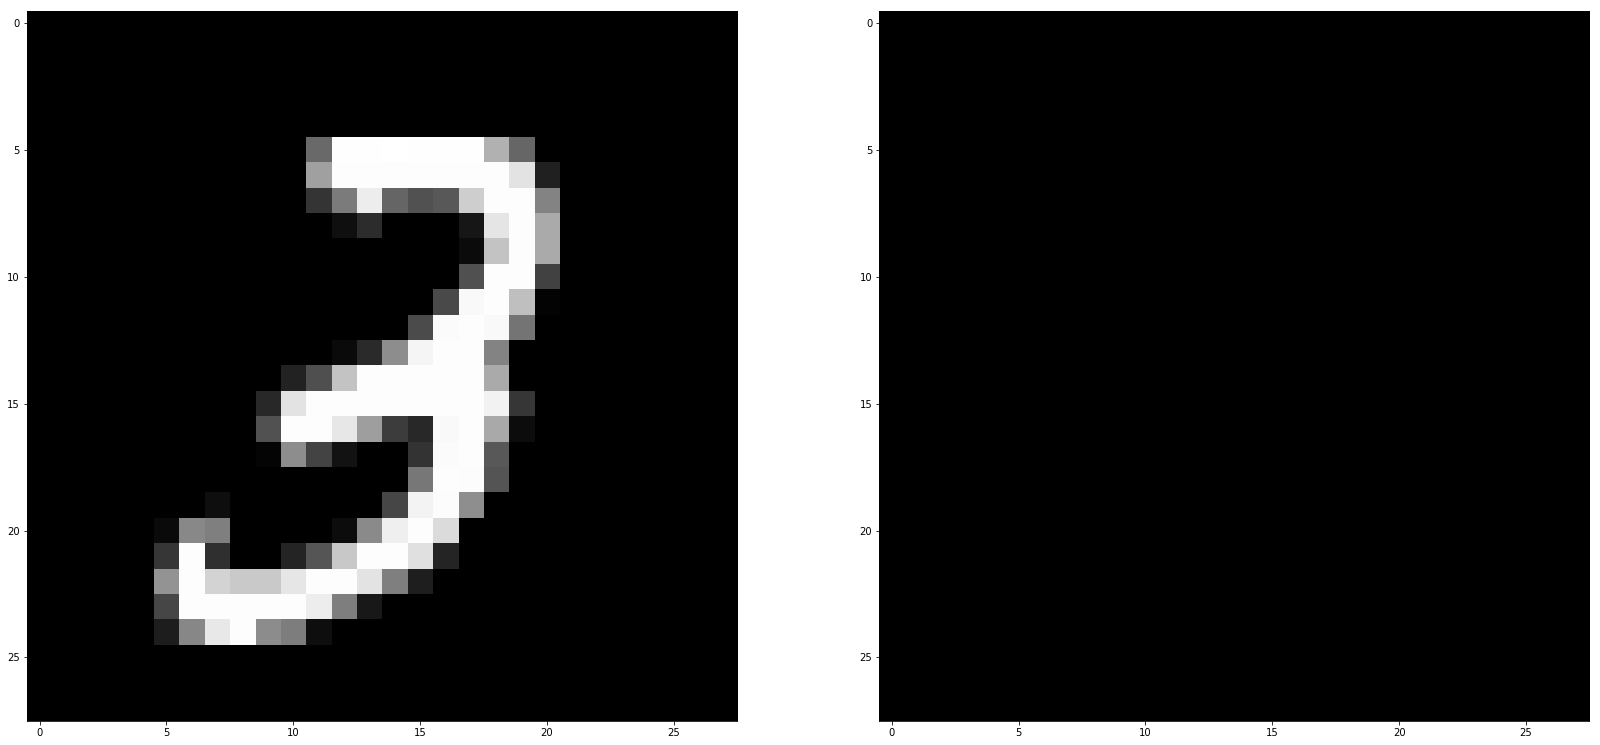

tensor(3585.8008, grad_fn=<MseLossBackward>)


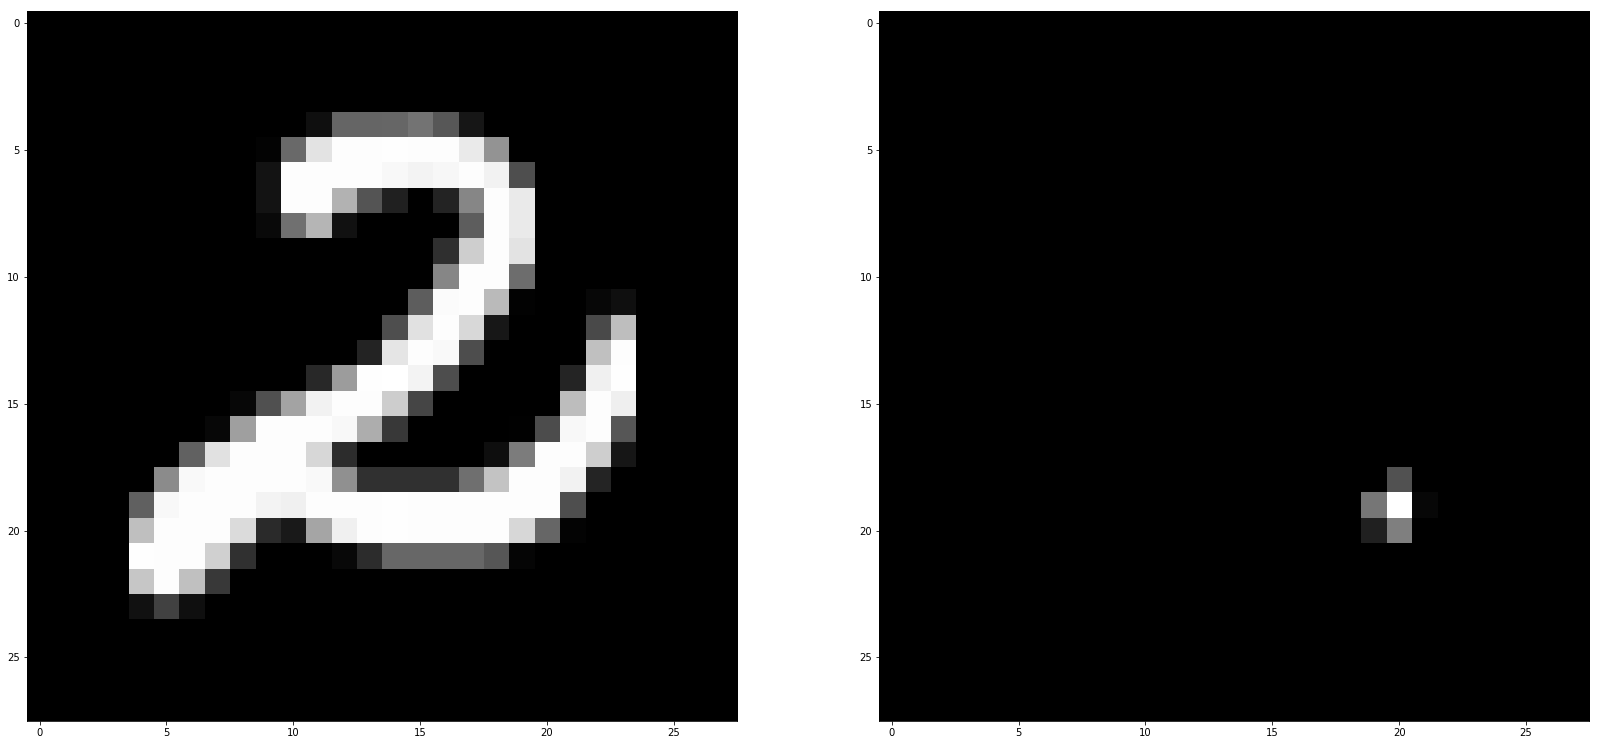

tensor(2346.2595, grad_fn=<MseLossBackward>)


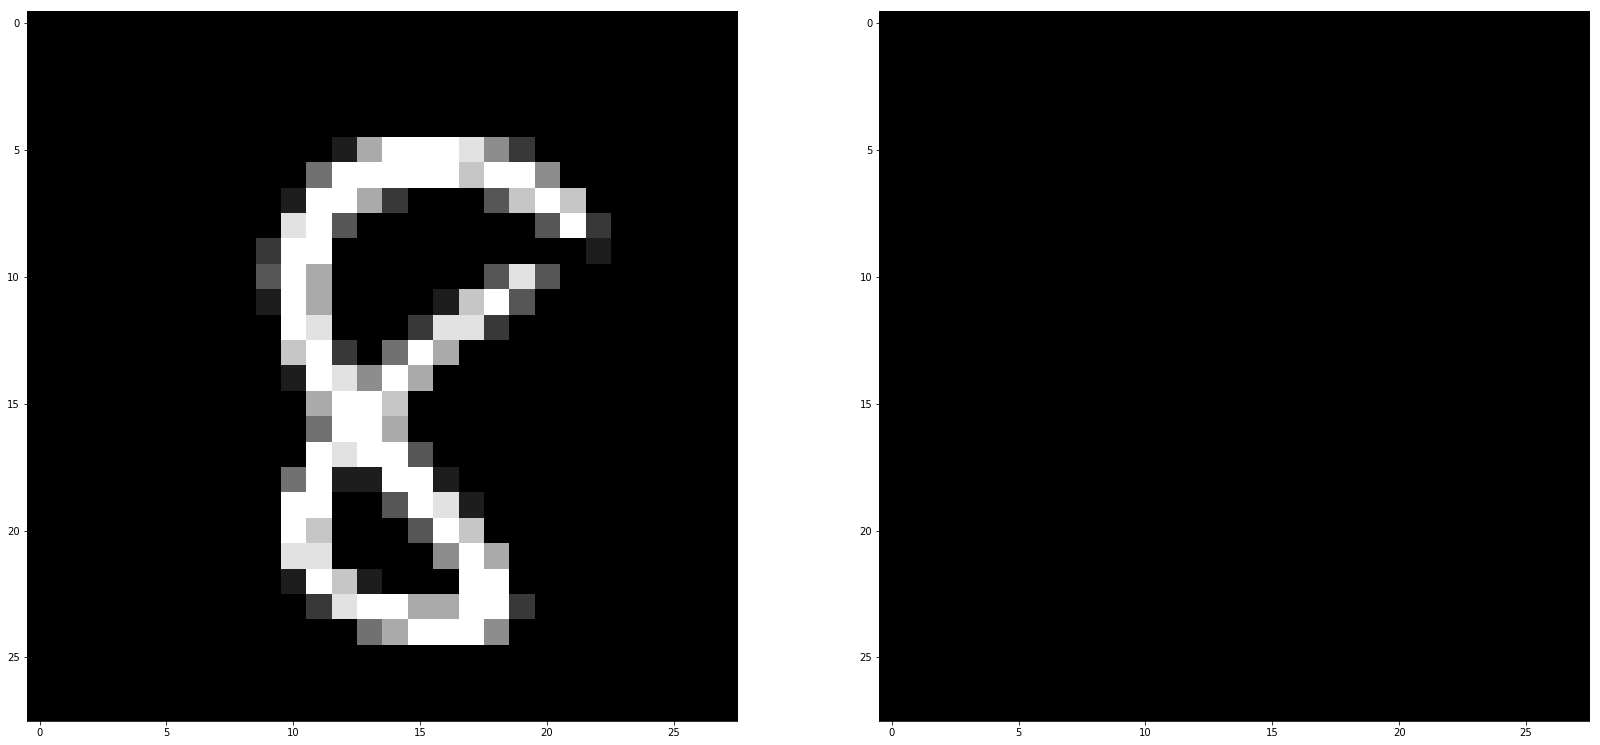

tensor(2806.4717, grad_fn=<MseLossBackward>)


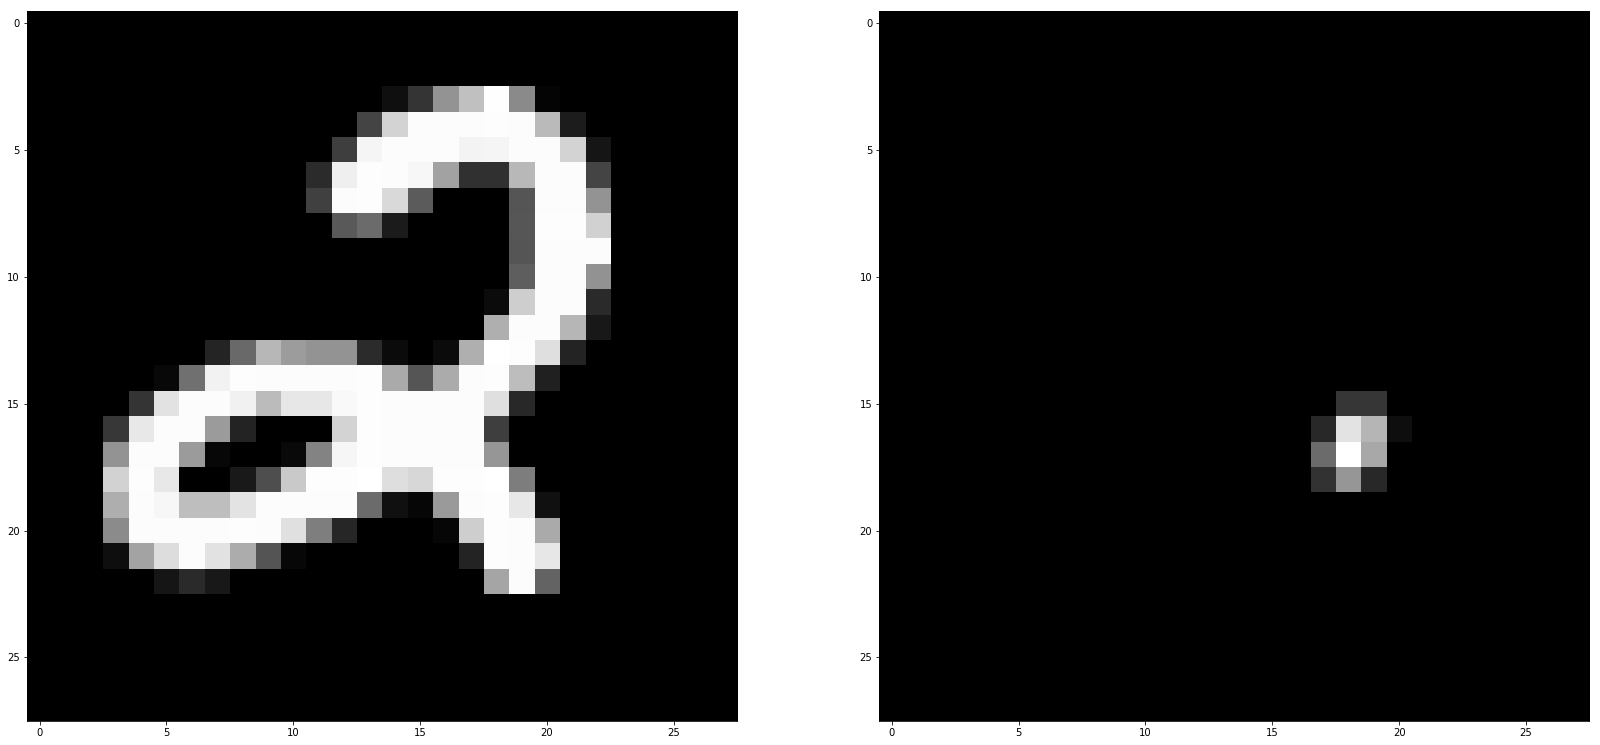

tensor(2141.4673, grad_fn=<MseLossBackward>)


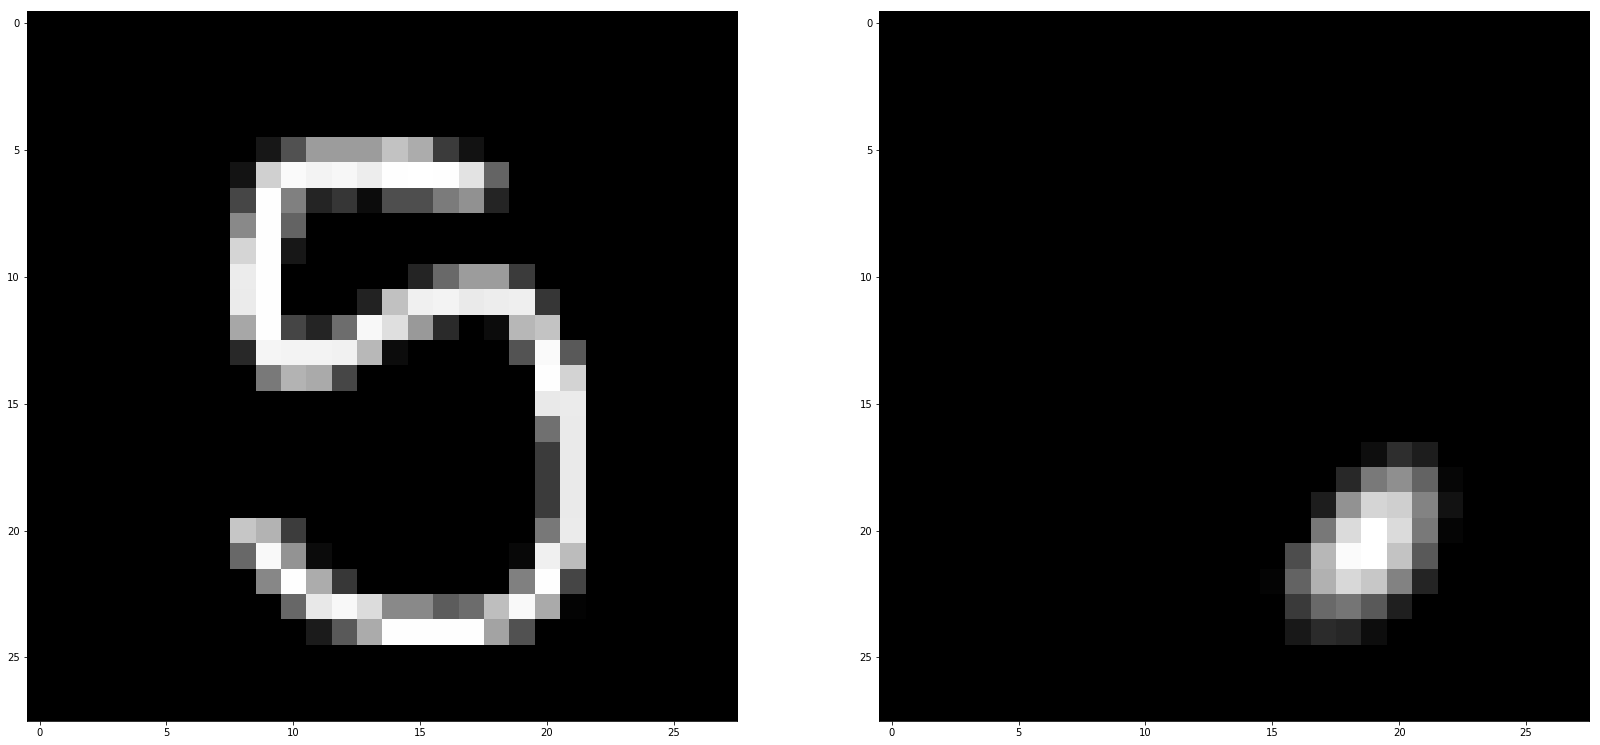

tensor(3103.4697, grad_fn=<MseLossBackward>)


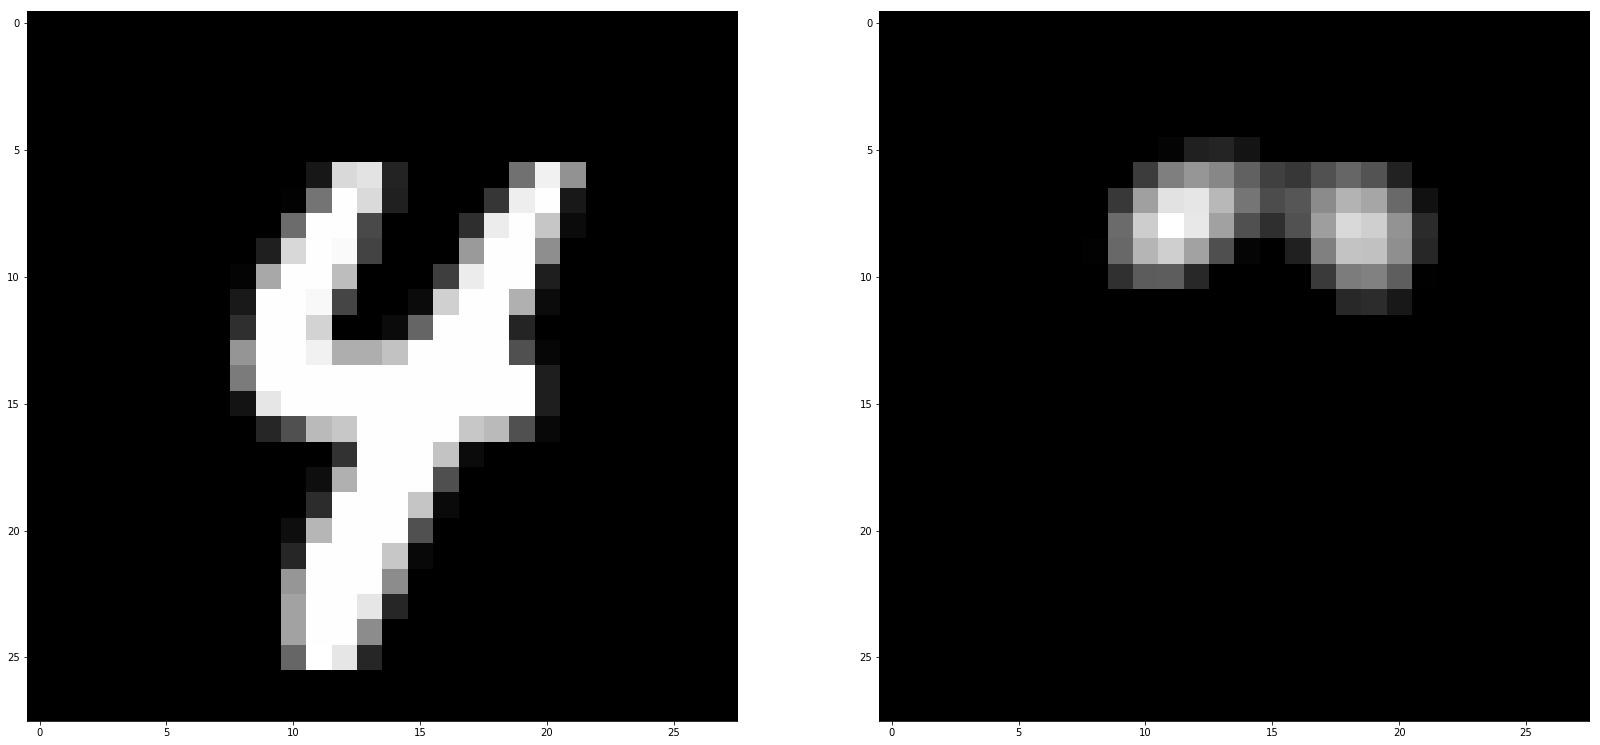

tensor(1662.6836, grad_fn=<MseLossBackward>)


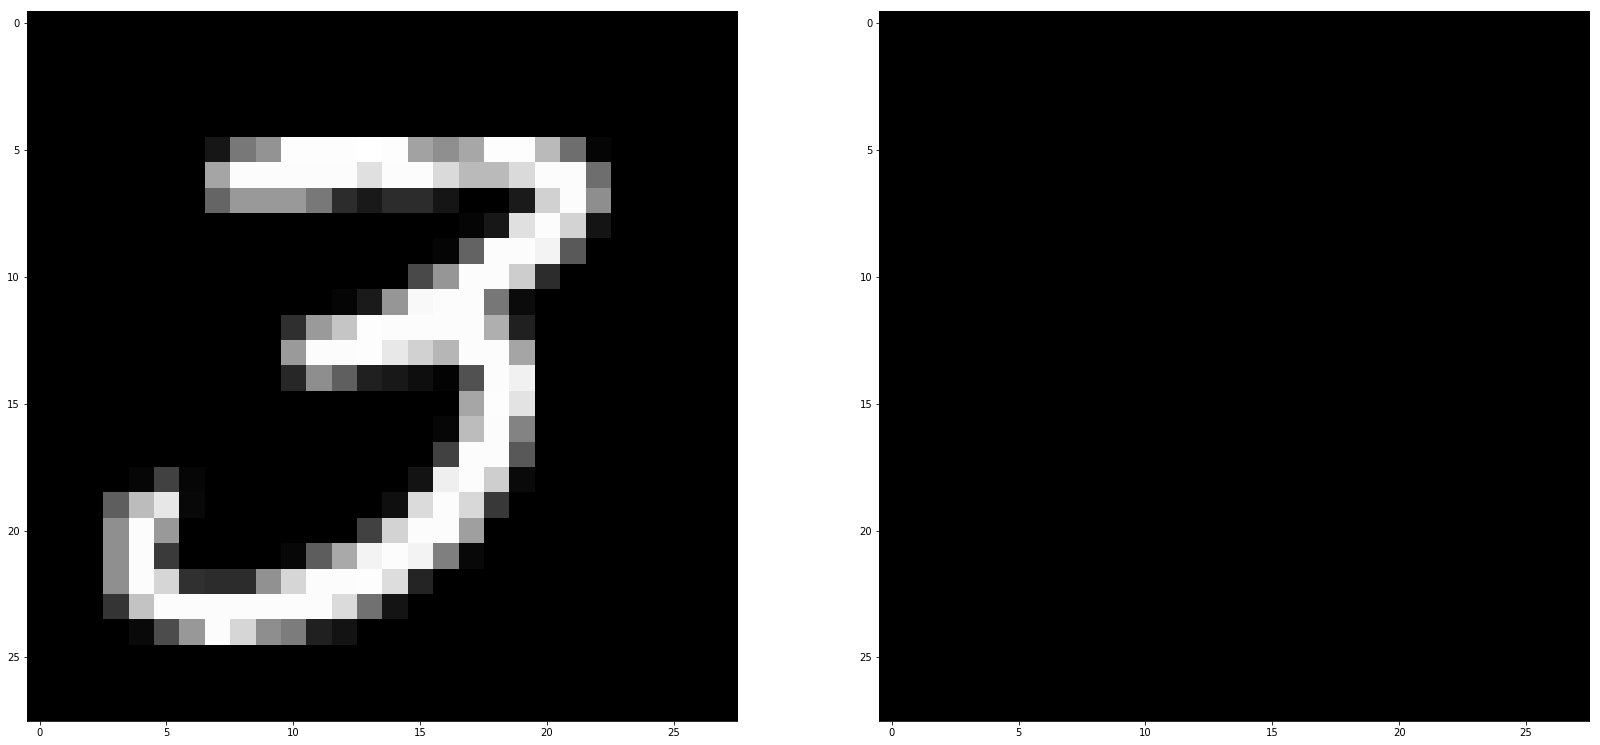

tensor(3275.2468, grad_fn=<MseLossBackward>)


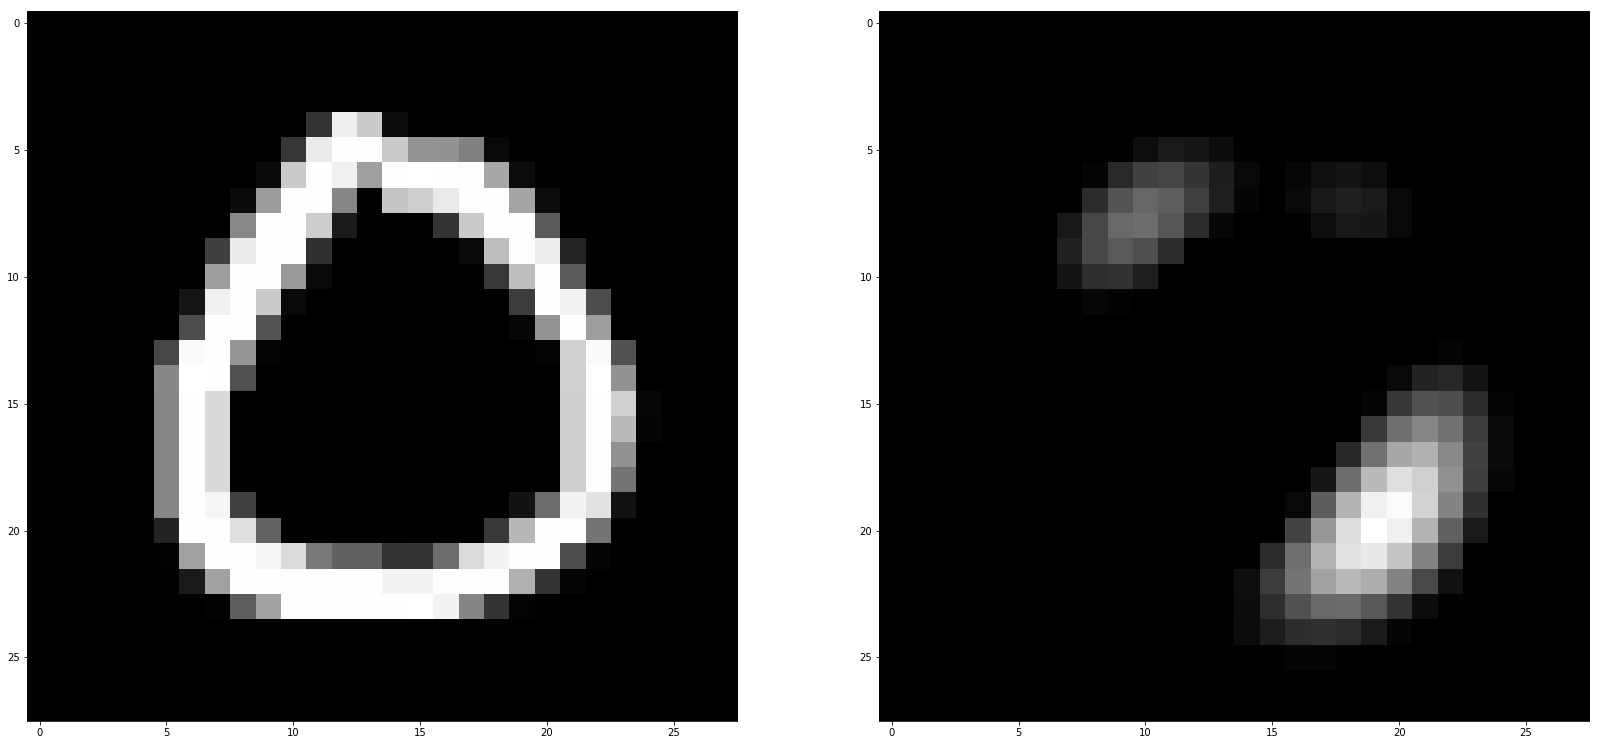

tensor(3920.5962, grad_fn=<MseLossBackward>)


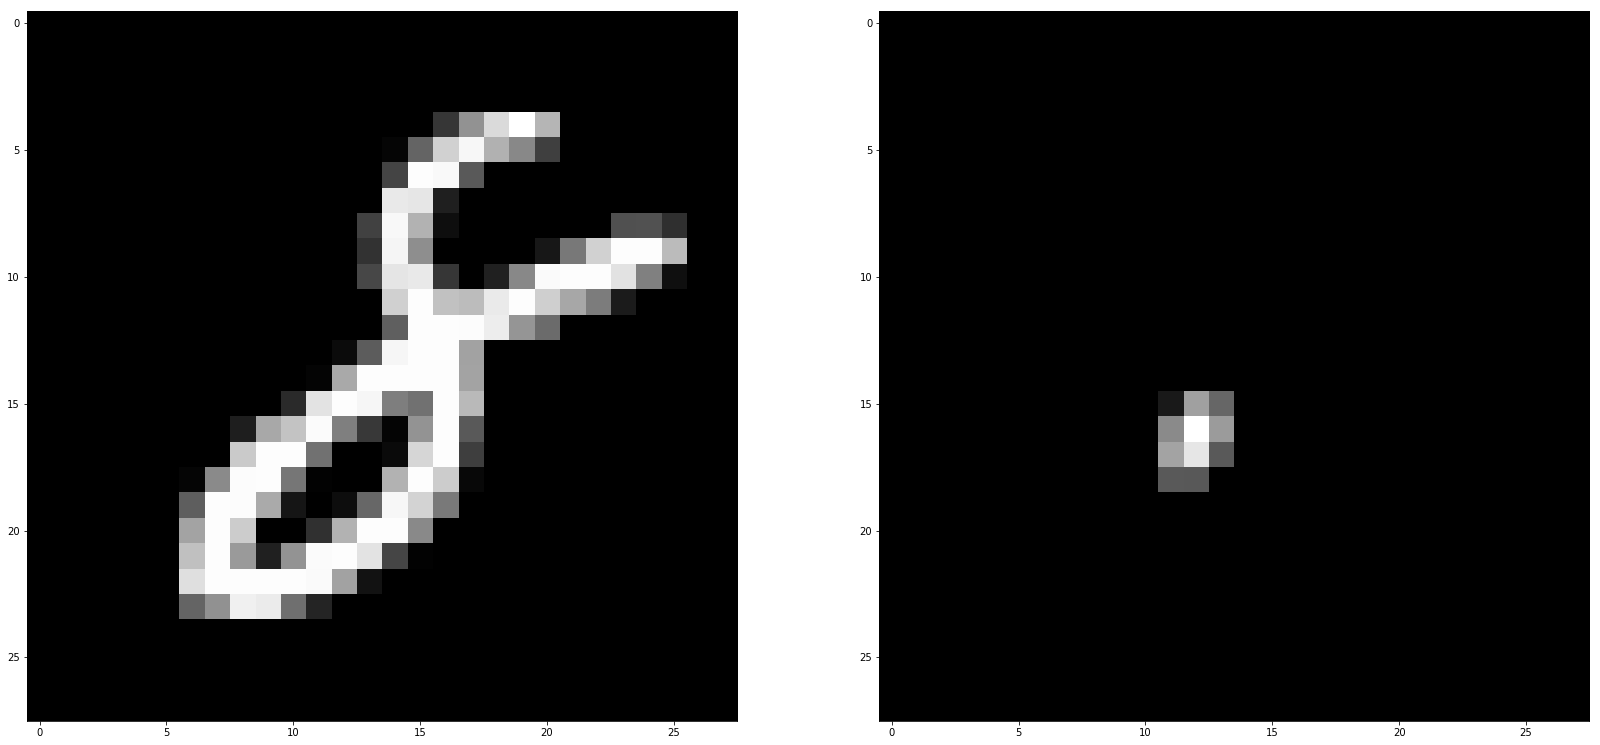

tensor(6567.2295, grad_fn=<MseLossBackward>)


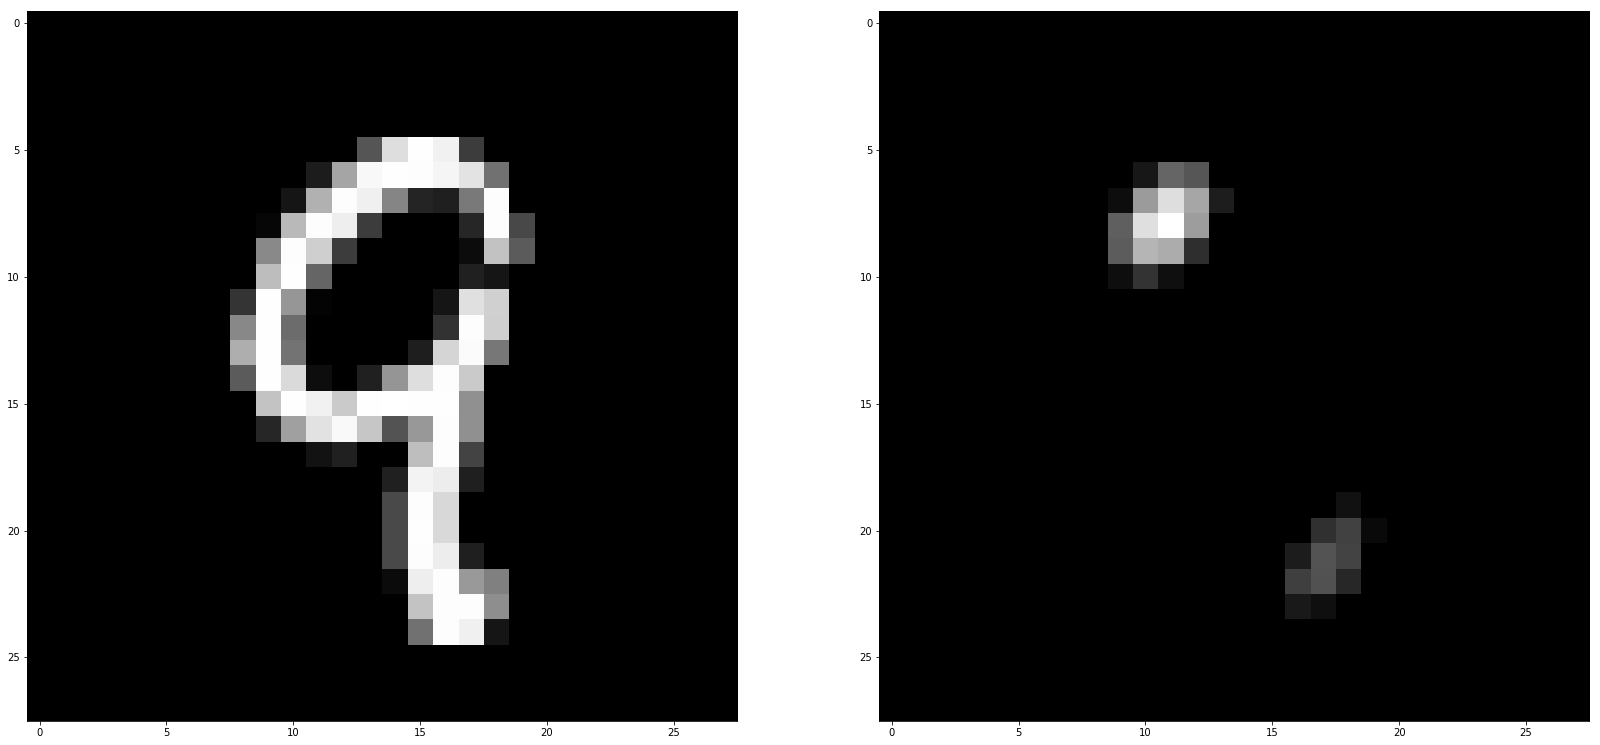

tensor(3527.6250, grad_fn=<MseLossBackward>)


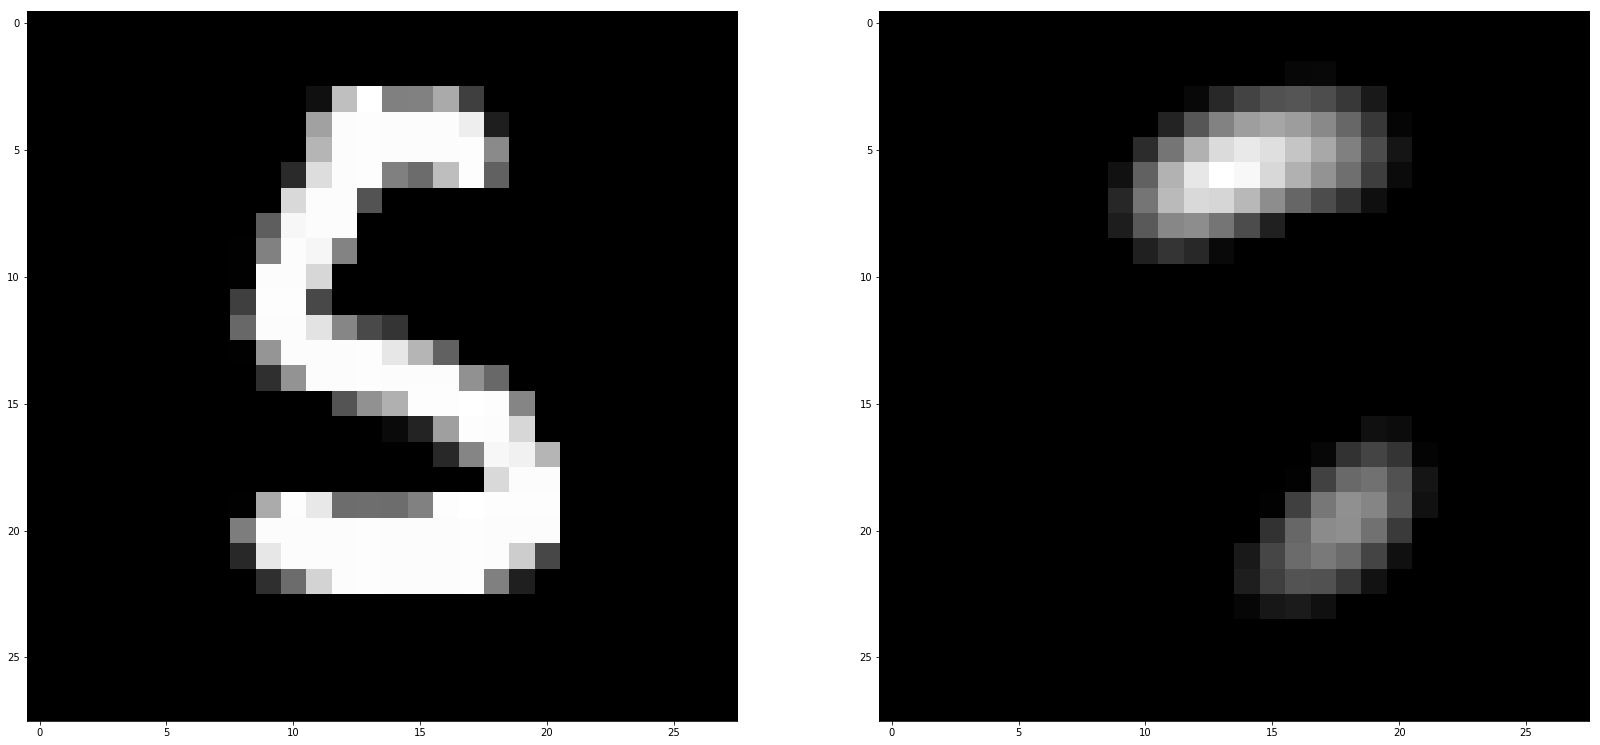

tensor(3124.7356, grad_fn=<MseLossBackward>)


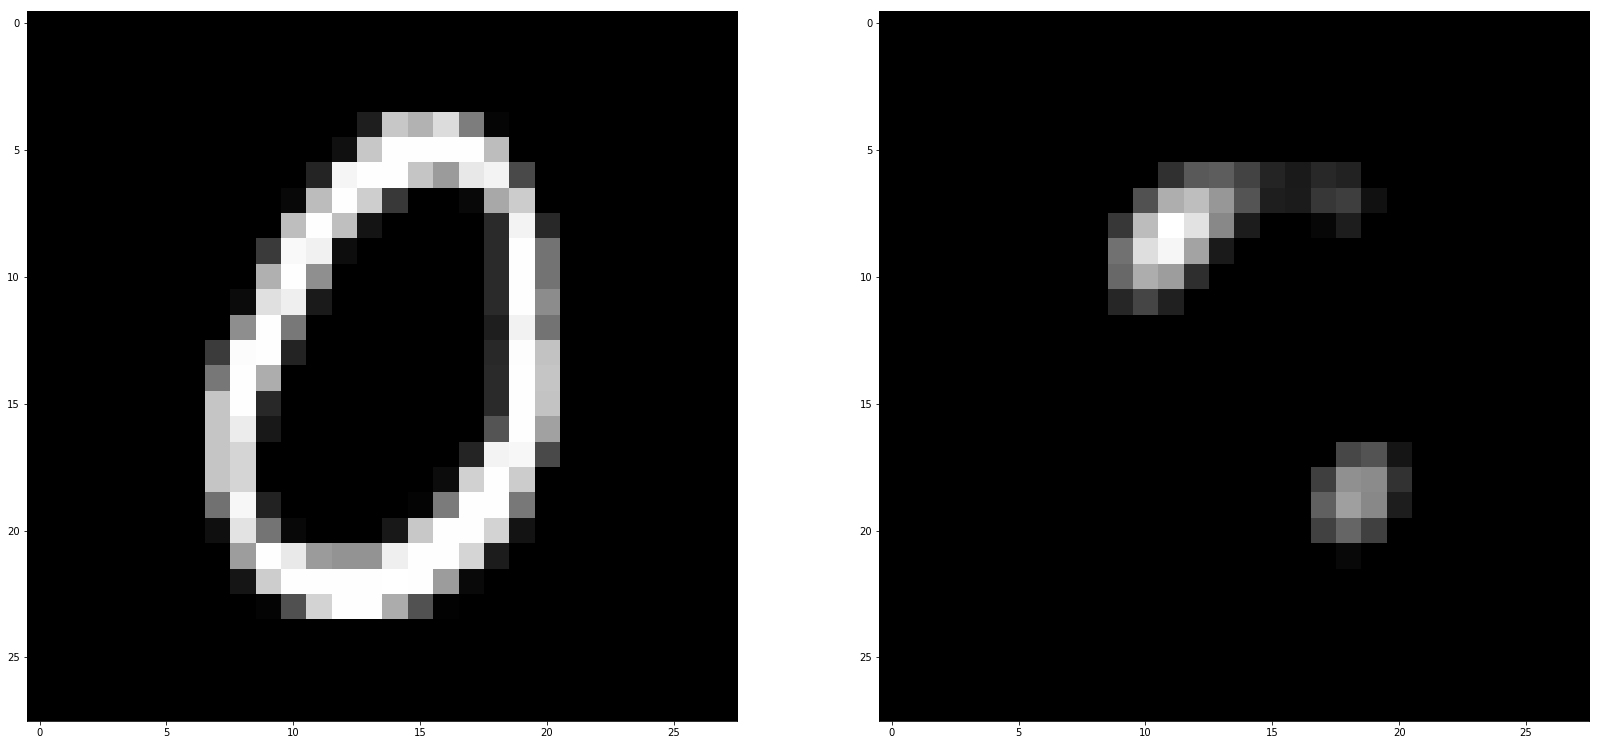

tensor(3128.0498, grad_fn=<MseLossBackward>)


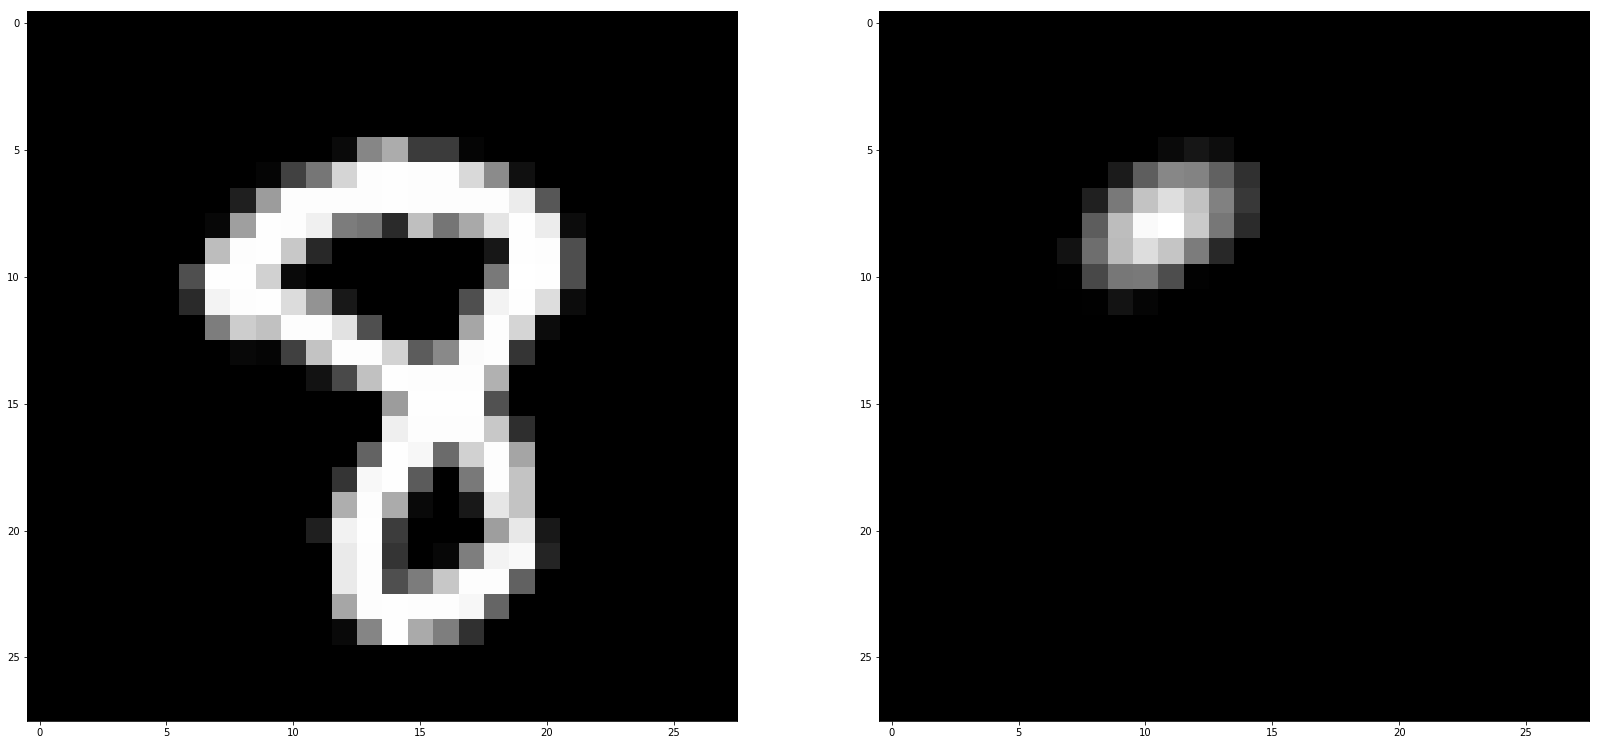

tensor(2983.7939, grad_fn=<MseLossBackward>)


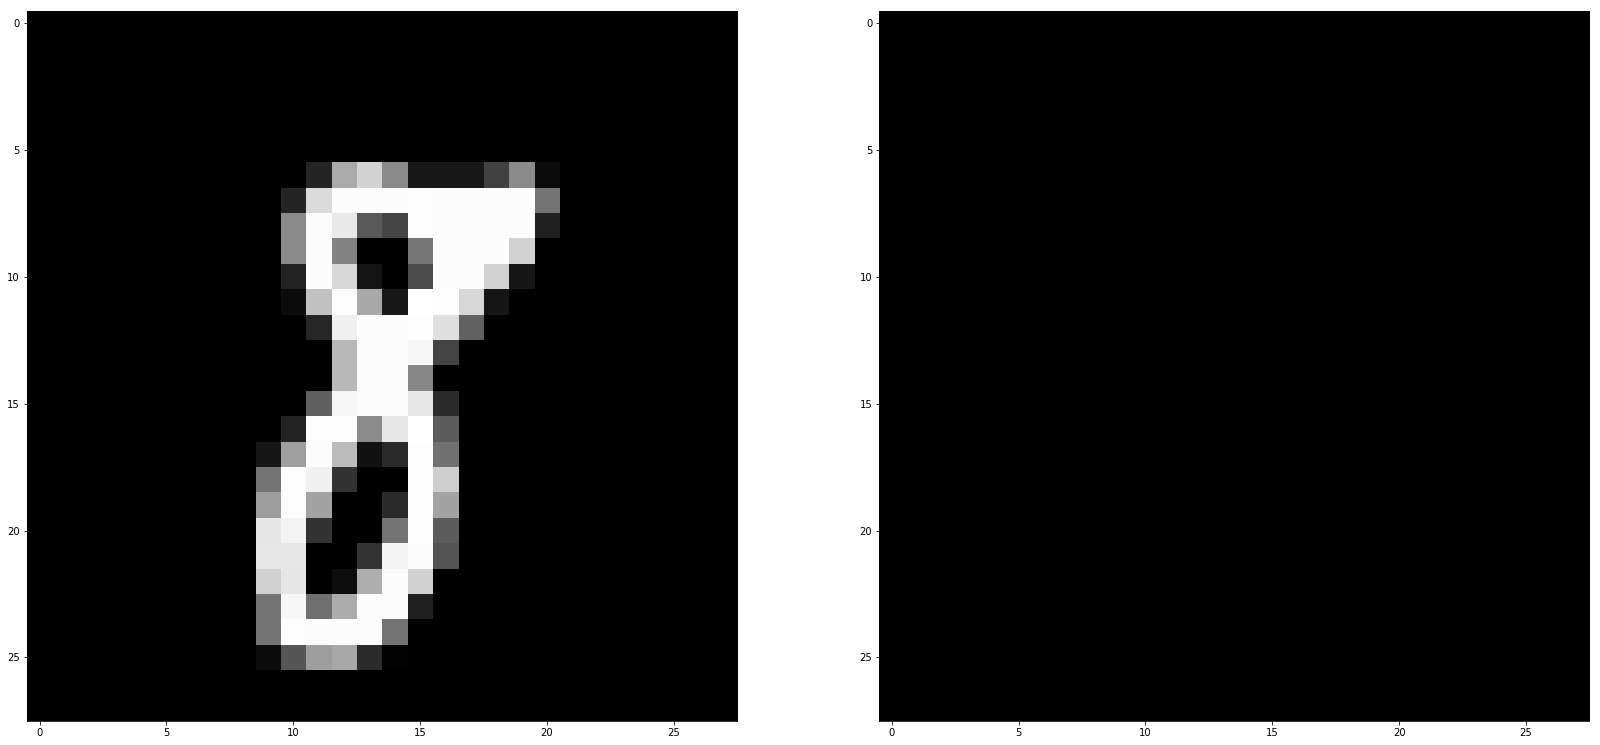

tensor(2504.3079, grad_fn=<MseLossBackward>)


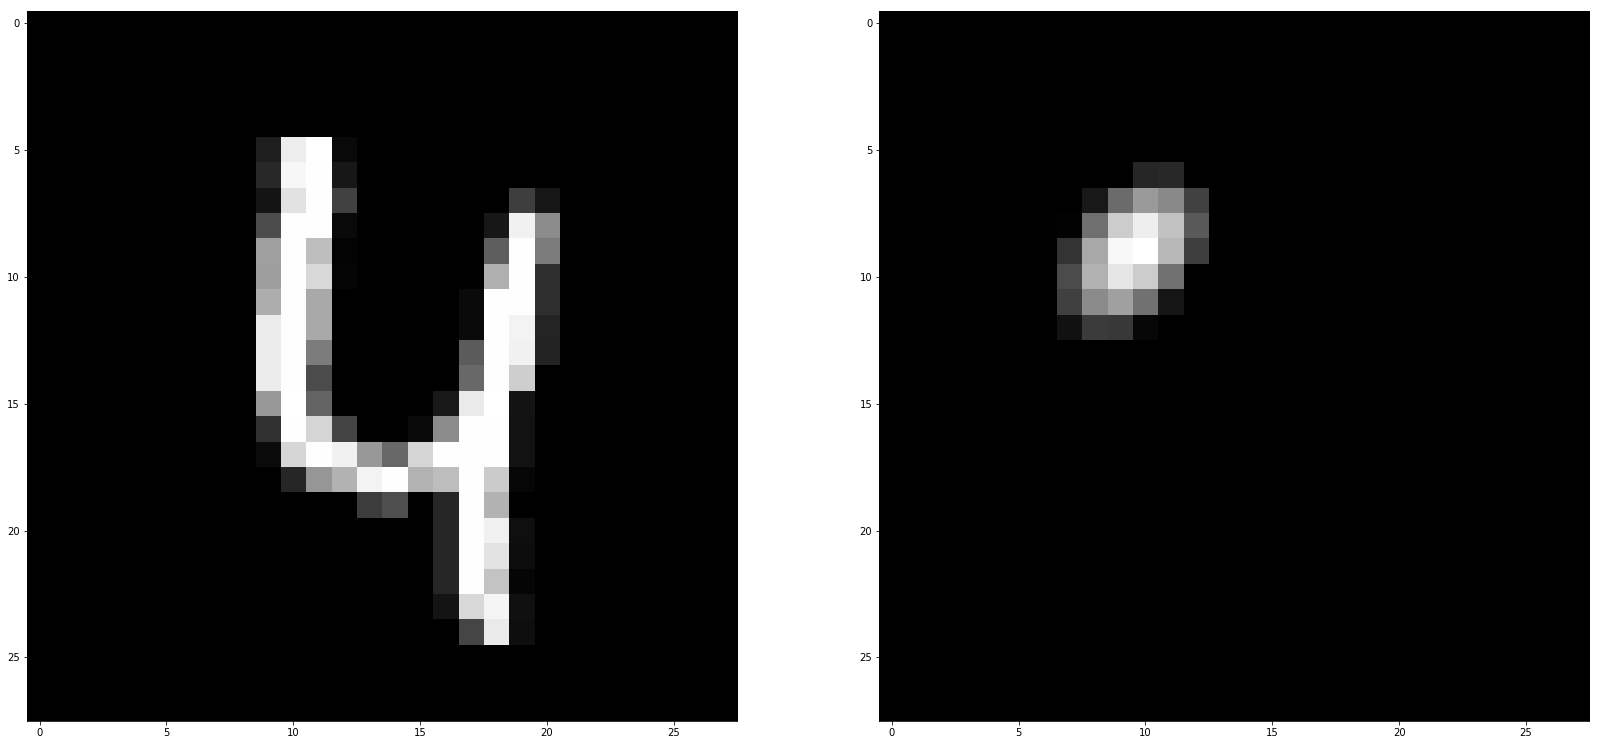

tensor(2680.3345, grad_fn=<MseLossBackward>)


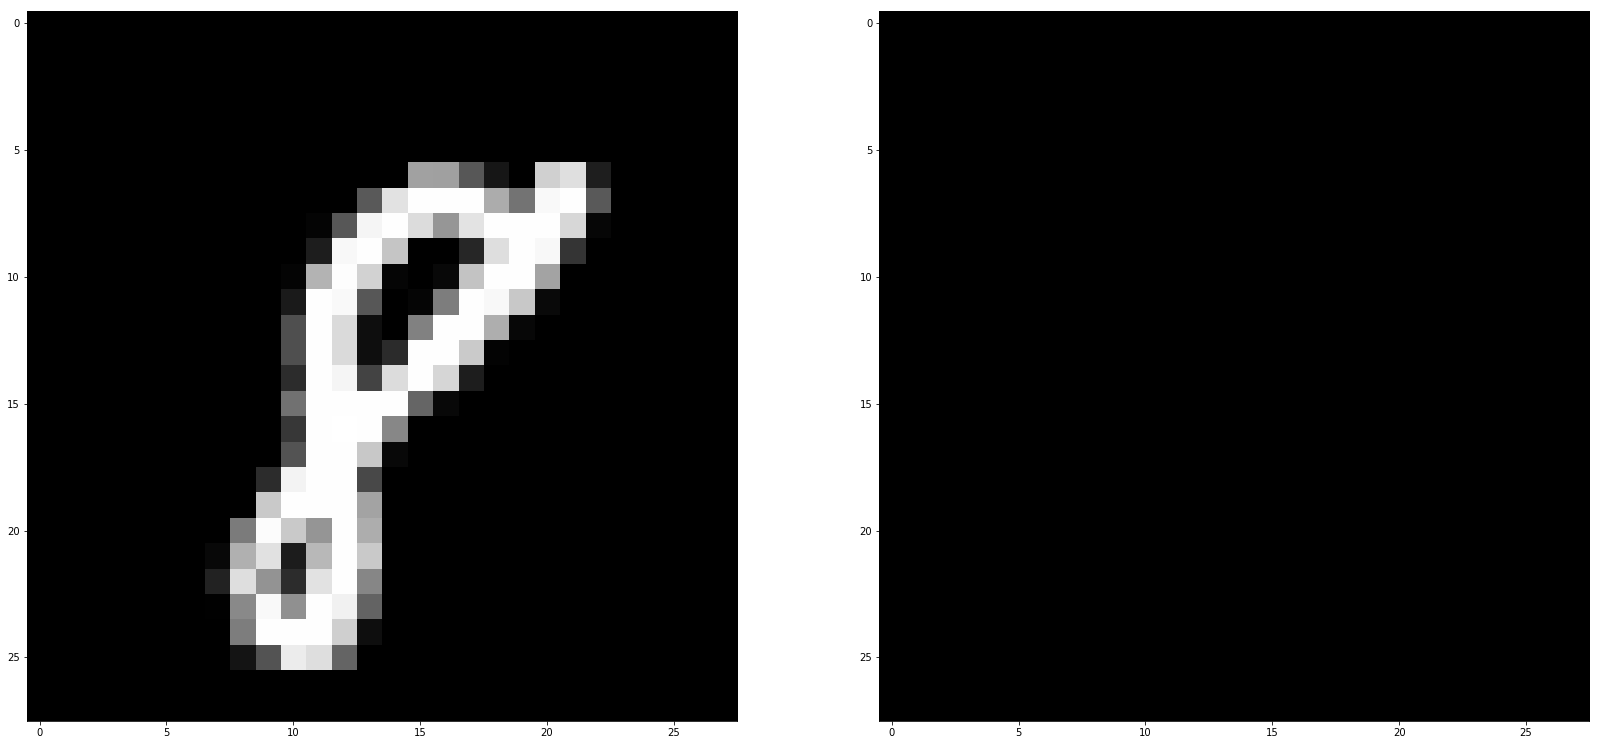

tensor(2239.4141, grad_fn=<MseLossBackward>)


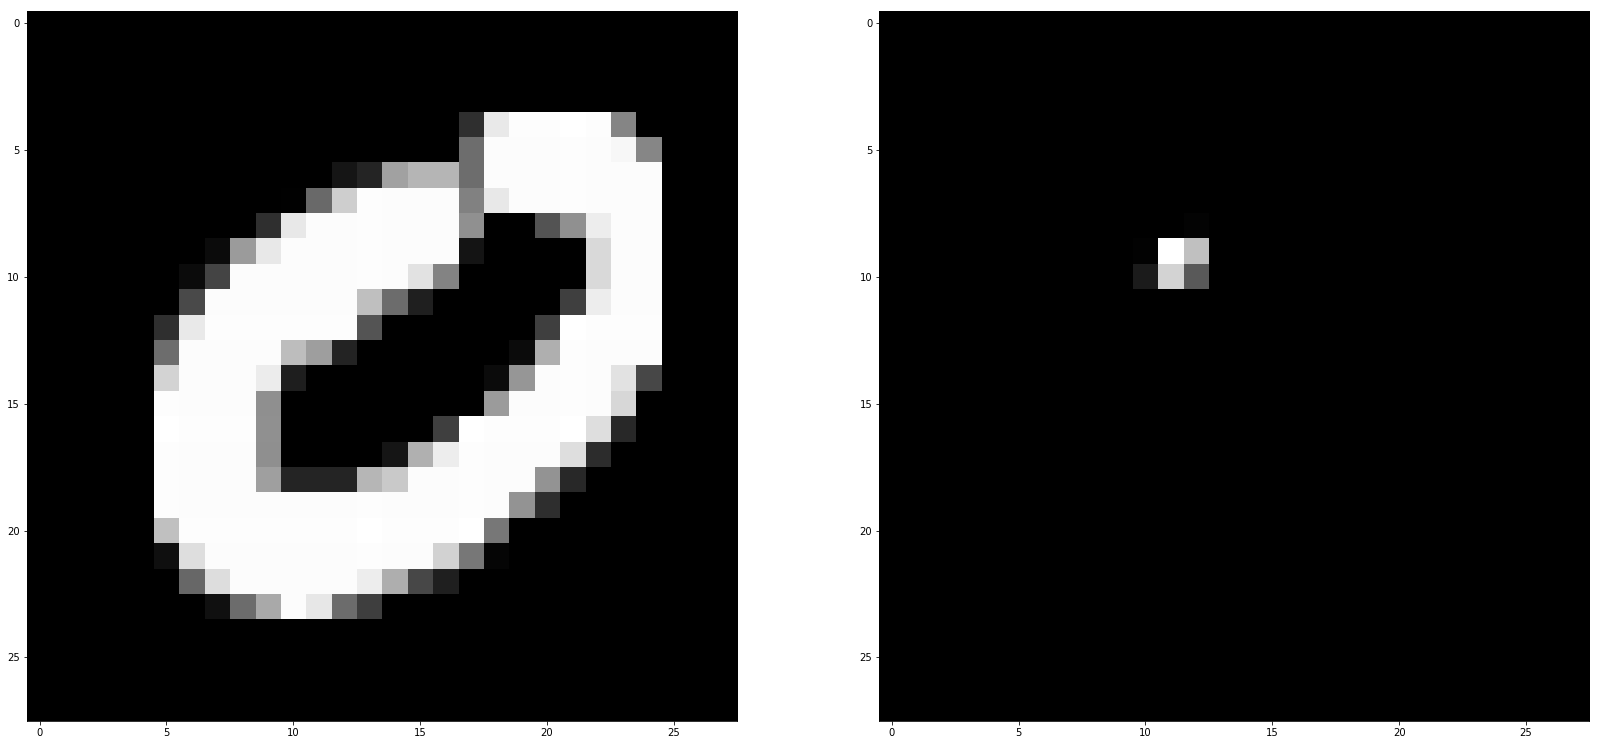

tensor(4156.2300, grad_fn=<MseLossBackward>)


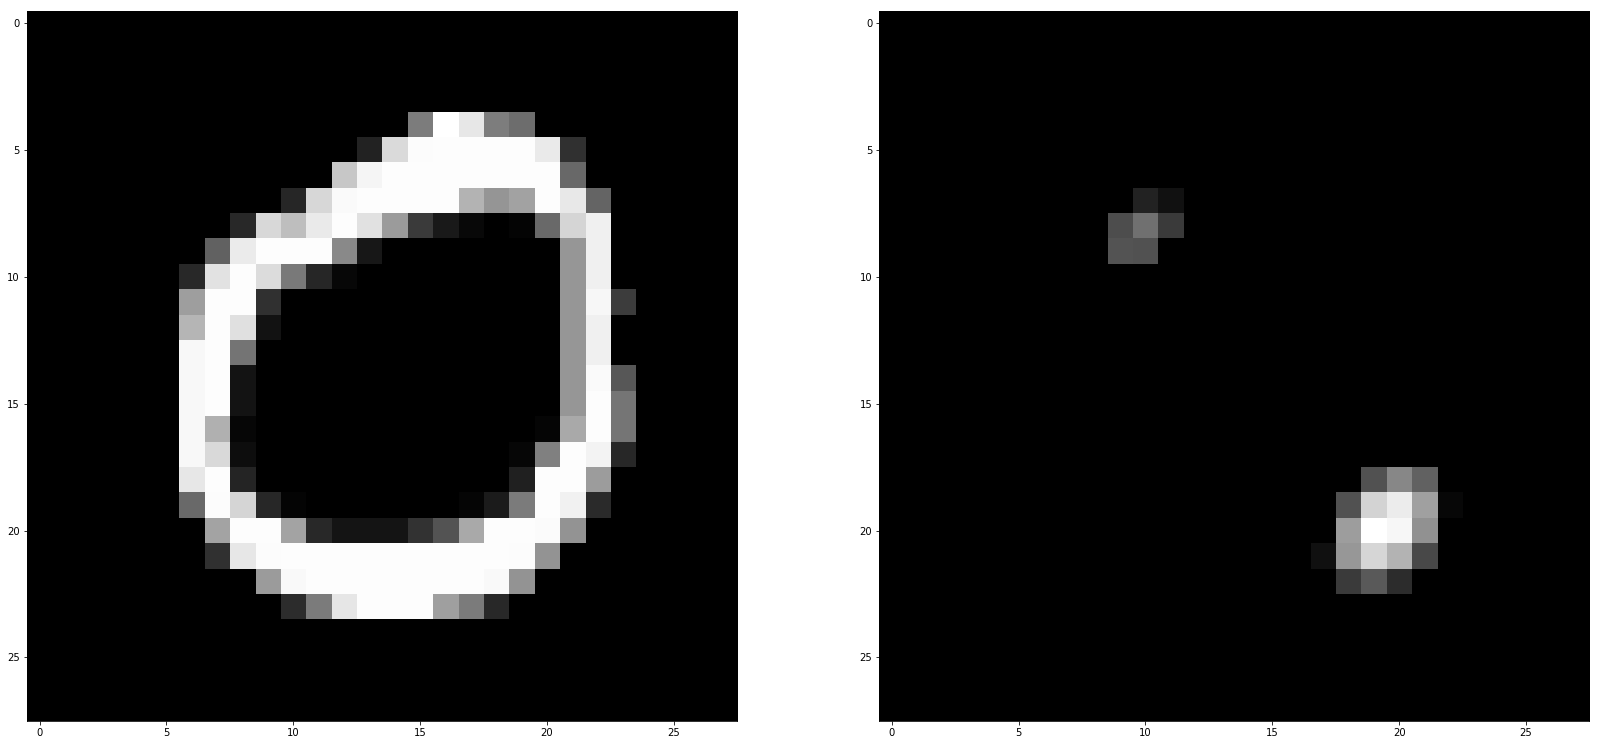

tensor(1323.3900, grad_fn=<MseLossBackward>)


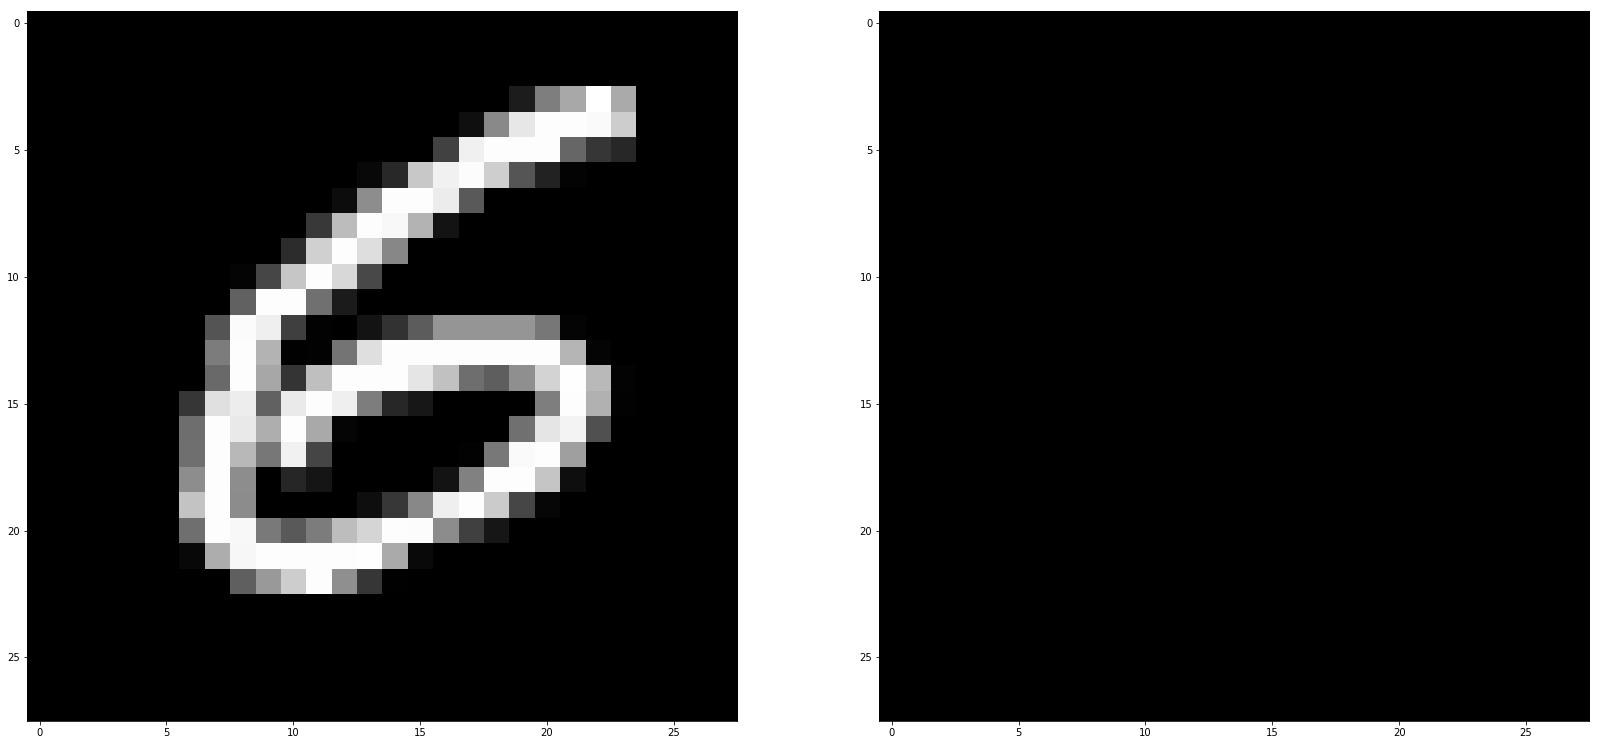

tensor(3724.2139, grad_fn=<MseLossBackward>)


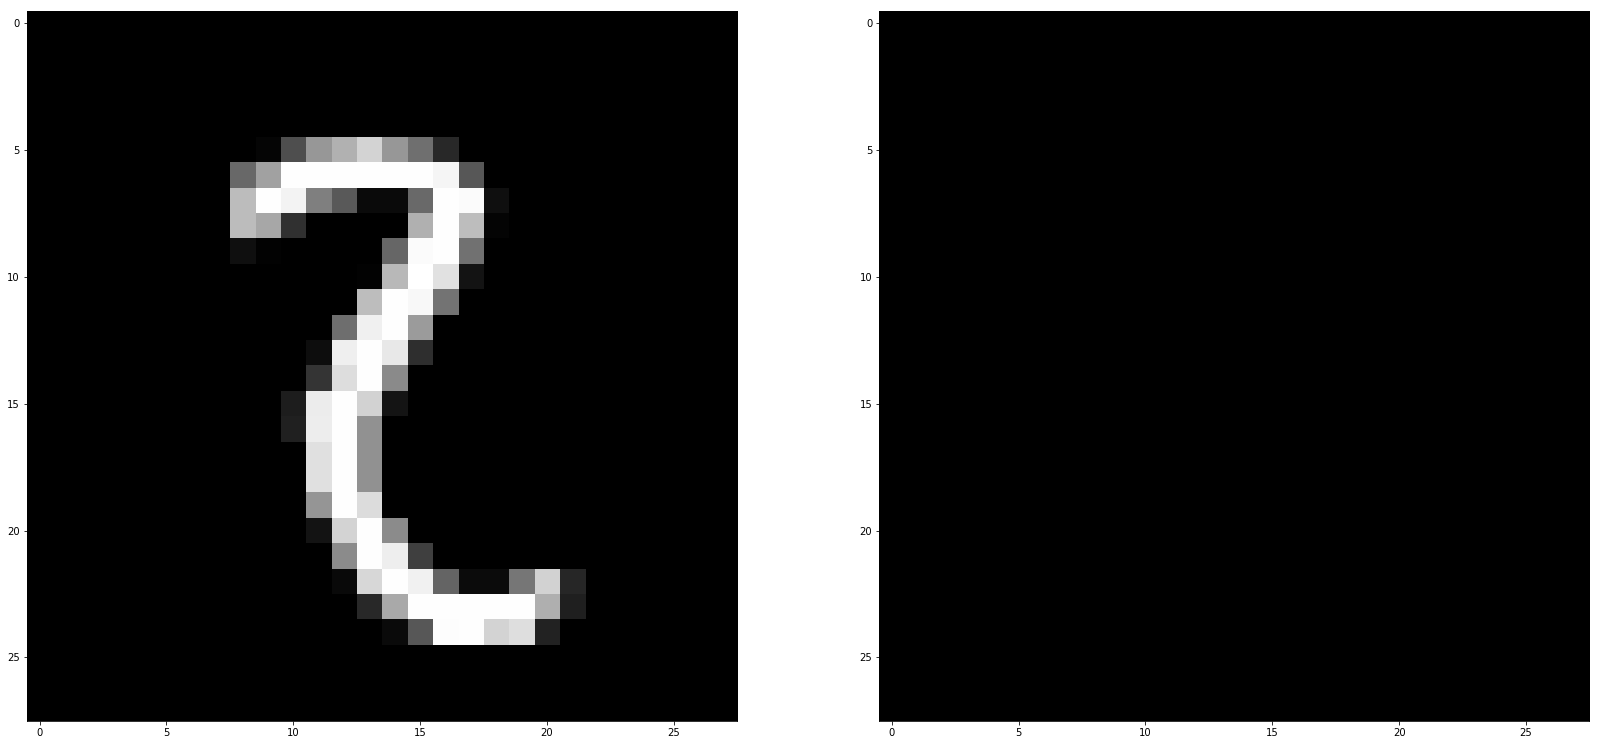

tensor(2367.9927, grad_fn=<MseLossBackward>)


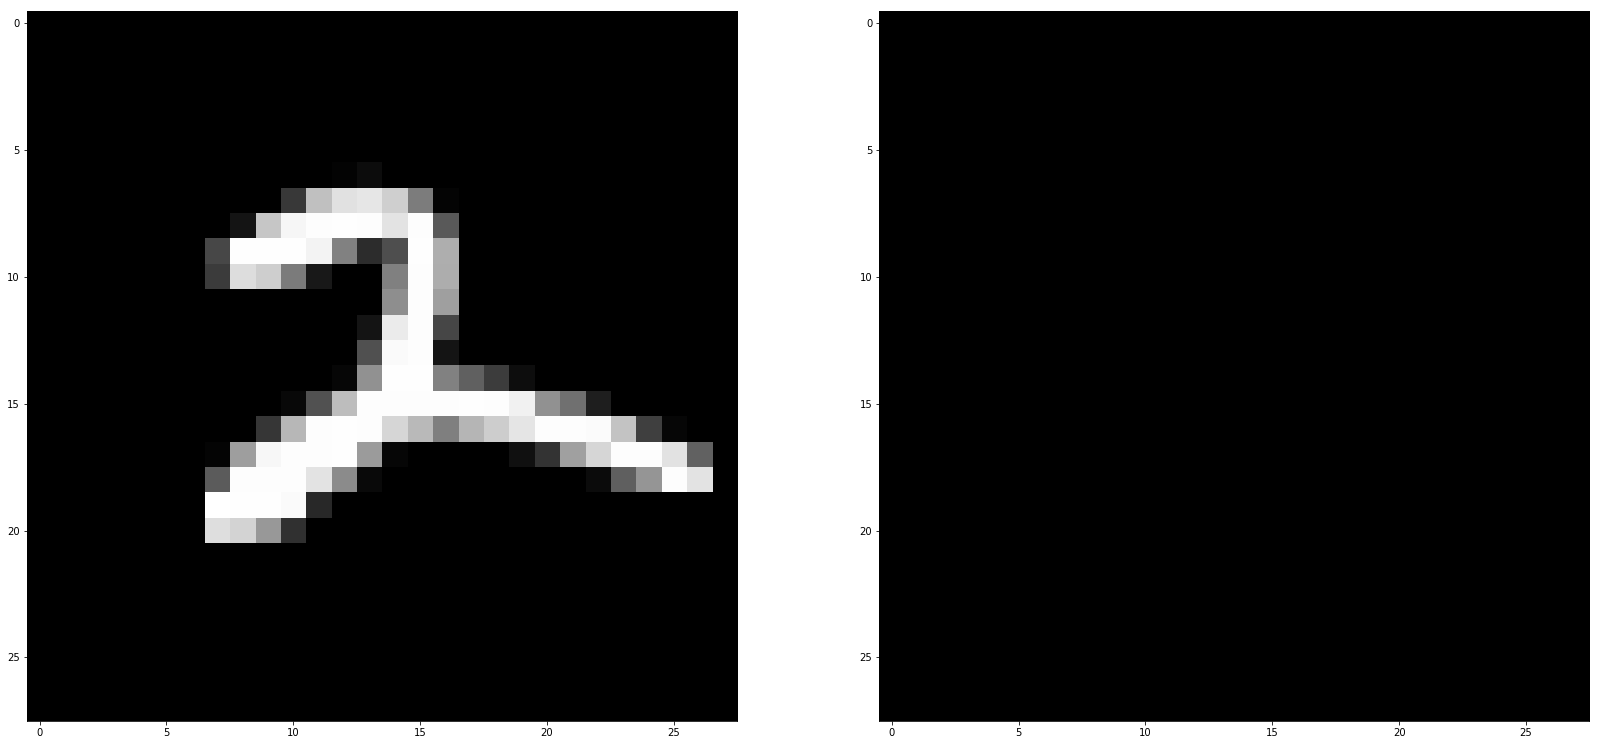

tensor(2941.7815, grad_fn=<MseLossBackward>)


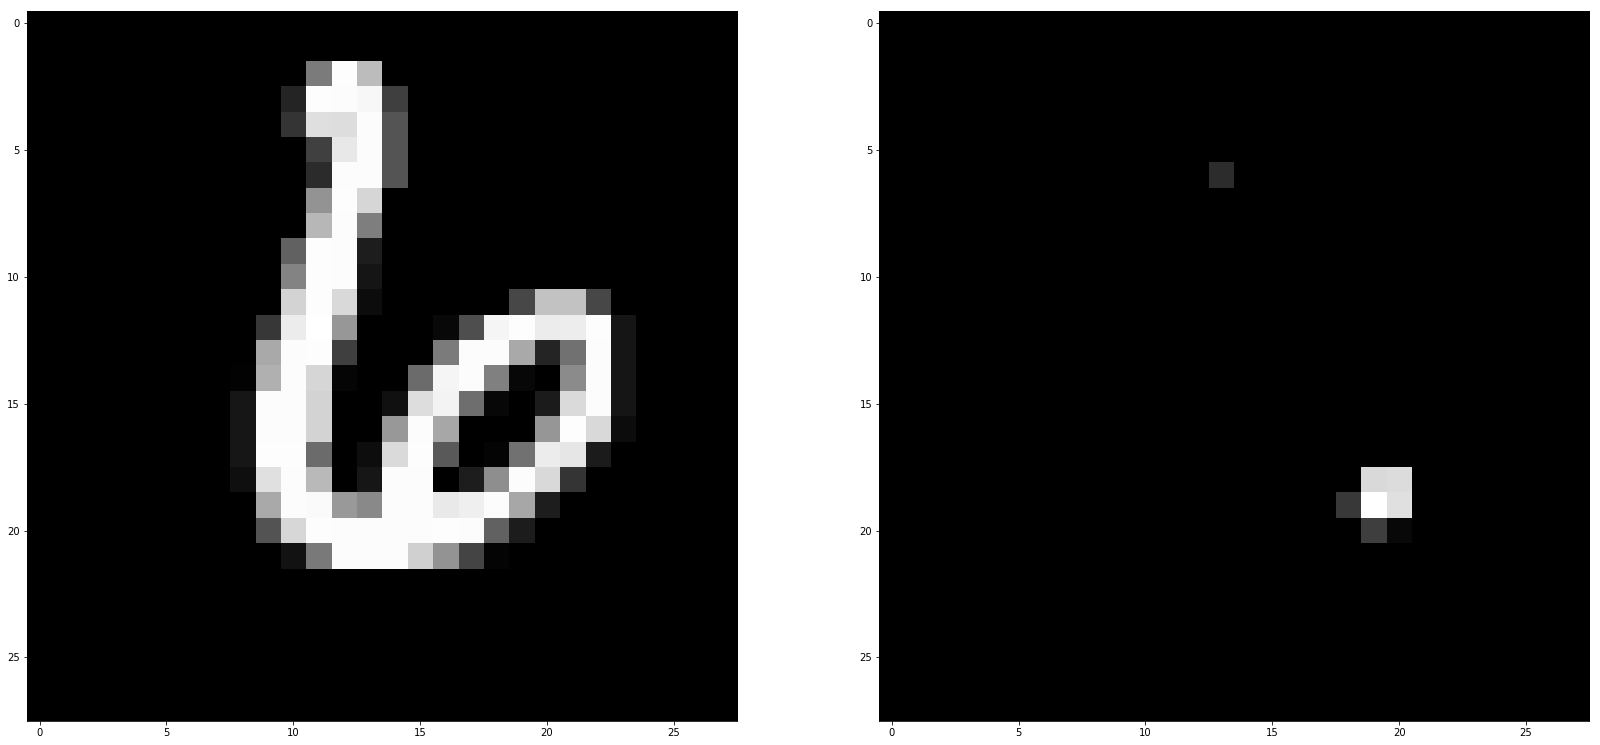

tensor(2919.9729, grad_fn=<MseLossBackward>)


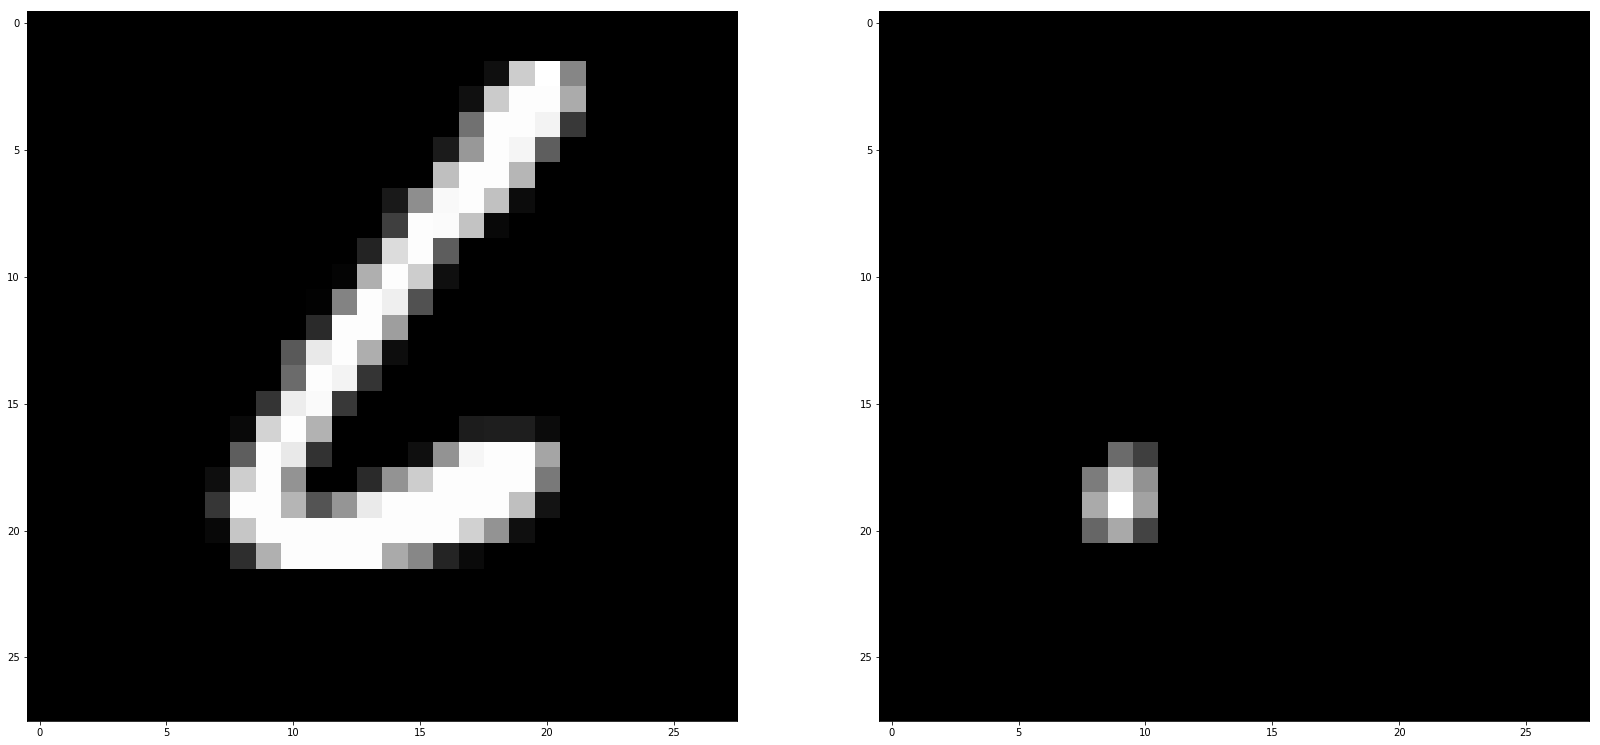

tensor(2718.4099, grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [57]:
epochs = 1
encoder.train()
decoder.train()
for epoch in range(epochs):
    for count, x in enumerate(data_train):
        optimizer.zero_grad()
        z = encoder(x)
        y = decoder(z)
        criterion = nn.MSELoss()
        loss = criterion(y.view(-1, 28, 28), x.view(-1, 28,28))
        loss.backward()
        optimizer.step() 
        if count % 1000 == 0:
            print(loss)
            index = np.random.randint(len(data_test))
            encoder.eval()
            decoder.eval()
            z = encoder(data_test[index])
            y = decoder(z)
            y_vis = y.detach().numpy().reshape(28,28)
            x_vis = data_test[index].numpy()

            encoder.train()
            decoder.train()

            fig = plt.figure(figsize=(28,28))
            fig.add_subplot(1, 2, 1)
            plt.imshow(x_vis, cmap='gray')
            fig.add_subplot(1, 2, 2)
            plt.imshow(y_vis, cmap='gray')
            plt.show()